In [1]:
%config Completer.use_jedi = False

In [2]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
from sklearn.preprocessing import StandardScaler, LabelEncoder, MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score
from bayes_opt import BayesianOptimization

import matplotlib.pyplot as plt
import seaborn as sns
import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
#         print(os.path.join(dirname, filename))
        pass

# Read Train Data

In [3]:
all_train_data = pd.read_csv('data_train.csv')
all_train_data

,Ids,Labels
0,2e69e9384_2020-10-06_13,True
1,2e6992c7c_2020-10-02_17,True
2,2e69ef474_2020-09-13_19,True
3,2e69c5fd4_2020-10-10_15,True
4,2e6992134_2020-09-12_11,True
...,...,...
71331,2e69eea5c_2020-11-09_10,False
71332,2e69c5944_2020-10-27_12,True
71333,2e69f2cd4_2020-11-07_14,True
71334,2e68e64e4_2020-09-23_9,False


In [4]:
all_test_data = pd.read_csv('data_test.csv')
all_test_data

,Ids
0,2e6992a84_2020-11-25_18
1,2e68e62f4_2020-11-29_20
2,2e68e81a4_2020-11-27_10
3,2e69eec04_2020-11-24_7
4,2e698e4a4_2020-11-27_8
...,...
13836,2e68dd414_2020-11-26_5
13837,2e698541c_2020-11-24_22
13838,2e69e8e0c_2020-11-24_10
13839,2e699a1cc_2020-11-24_18


# Cleaning Alerts Data

In [5]:
all_alerts_data = pd.read_csv('alerts.csv')
alerts_data = all_alerts_data.copy()

In [6]:
alerts_data

,id,pub_millis,s2id_15,s2token_15,road_type,street,city,magvar,reliability,report_description,report_rating,confidence,type,subtype,report_by_municipality_user,n_thumbs_up,longitude,latitude
0,177876895,1603331480000,3344466888162803712,2e69eeea4,1,NaN,Depok,0,9,NaN,0,1,ROAD_CLOSED,ROAD_CLOSED_EVENT,NaN,NaN,106.788545,-6.359846
1,179156987,1604487892000,3344463130066419712,2e69eb7f4,6,N8 Jalan Raya Bogor,Depok,170,7,NaN,1,1,JAM,JAM_HEAVY_TRAFFIC,NaN,0.0,106.867141,-6.383855
2,181688703,1605666614000,3344367648648462336,2e6994a84,7,NaN,Bekasi,0,8,NaN,0,1,ROAD_CLOSED,ROAD_CLOSED_EVENT,NaN,NaN,106.921974,-6.379087
3,173055165,1601895721000,3344374458319110144,2e699ad9c,2,Flyover Tegal Gede,Cikarang,319,10,NaN,5,0,WEATHERHAZARD,HAZARD_ON_ROAD_POT_HOLE,NaN,NaN,107.143656,-6.300441
4,173802602,1602464394000,3344466709921660928,2e69eec0c,2,Tanjakan Kembar,Depok,310,5,NaN,3,0,JAM,JAM_HEAVY_TRAFFIC,NaN,NaN,106.793950,-6.365677
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7800657,171213053,1601258425000,3344175981437911040,2e68e6564,7,Ir Haji Juanda,Bandung,0,6,NaN,0,0,ROAD_CLOSED,ROAD_CLOSED_EVENT,NaN,NaN,107.613518,-6.889047
7800658,172373573,1601809265000,3344356103776370688,2e698a284,1,Mutiara Gading,Tarumajaya,101,5,NaN,3,0,JAM,JAM_STAND_STILL_TRAFFIC,NaN,NaN,107.004148,-6.162891
7800659,166701219,1599012052000,3344175940635721728,2e68e64cc,7,Diponegoro,Bandung,0,6,NaN,0,0,ROAD_CLOSED,ROAD_CLOSED_EVENT,NaN,0.0,107.619330,-6.901280
7800660,172955801,1602073655000,3344365275679031296,2e69927fc,2,Wibawa Mukti 2,Bekasi,200,5,NaN,2,0,JAM,JAM_HEAVY_TRAFFIC,NaN,NaN,106.959589,-6.294933


In [7]:
alerts_data['pub_millis'] = pd.to_datetime(alerts_data['pub_millis'], unit='ms')
#add time column
alerts_data['pub_time'] = [d.time() for d in alerts_data['pub_millis']]
#add date column
alerts_data['pub_date'] = [d.date() for d in alerts_data['pub_millis']]
#add hour column
alerts_data['hour'] = pd.to_datetime(alerts_data['pub_millis']).dt.hour
alerts_data['report_description'].value_counts()


dropped_columns = [['report_description','report_by_municipality_user','n_thumbs_up']]
for col in dropped_columns:
    alerts_clean = alerts_data.drop(col,axis=1)

In [8]:
alerts_clean

,id,pub_millis,s2id_15,s2token_15,road_type,street,city,magvar,reliability,report_rating,confidence,type,subtype,longitude,latitude,pub_time,pub_date,hour
0,177876895,2020-10-22 01:51:20,3344466888162803712,2e69eeea4,1,NaN,Depok,0,9,0,1,ROAD_CLOSED,ROAD_CLOSED_EVENT,106.788545,-6.359846,01:51:20,2020-10-22,1
1,179156987,2020-11-04 11:04:52,3344463130066419712,2e69eb7f4,6,N8 Jalan Raya Bogor,Depok,170,7,1,1,JAM,JAM_HEAVY_TRAFFIC,106.867141,-6.383855,11:04:52,2020-11-04,11
2,181688703,2020-11-18 02:30:14,3344367648648462336,2e6994a84,7,NaN,Bekasi,0,8,0,1,ROAD_CLOSED,ROAD_CLOSED_EVENT,106.921974,-6.379087,02:30:14,2020-11-18,2
3,173055165,2020-10-05 11:02:01,3344374458319110144,2e699ad9c,2,Flyover Tegal Gede,Cikarang,319,10,5,0,WEATHERHAZARD,HAZARD_ON_ROAD_POT_HOLE,107.143656,-6.300441,11:02:01,2020-10-05,11
4,173802602,2020-10-12 00:59:54,3344466709921660928,2e69eec0c,2,Tanjakan Kembar,Depok,310,5,3,0,JAM,JAM_HEAVY_TRAFFIC,106.793950,-6.365677,00:59:54,2020-10-12,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7800657,171213053,2020-09-28 02:00:25,3344175981437911040,2e68e6564,7,Ir Haji Juanda,Bandung,0,6,0,0,ROAD_CLOSED,ROAD_CLOSED_EVENT,107.613518,-6.889047,02:00:25,2020-09-28,2
7800658,172373573,2020-10-04 11:01:05,3344356103776370688,2e698a284,1,Mutiara Gading,Tarumajaya,101,5,3,0,JAM,JAM_STAND_STILL_TRAFFIC,107.004148,-6.162891,11:01:05,2020-10-04,11
7800659,166701219,2020-09-02 02:00:52,3344175940635721728,2e68e64cc,7,Diponegoro,Bandung,0,6,0,0,ROAD_CLOSED,ROAD_CLOSED_EVENT,107.619330,-6.901280,02:00:52,2020-09-02,2
7800660,172955801,2020-10-07 12:27:35,3344365275679031296,2e69927fc,2,Wibawa Mukti 2,Bekasi,200,5,2,0,JAM,JAM_HEAVY_TRAFFIC,106.959589,-6.294933,12:27:35,2020-10-07,12


# Features Encoder

In [9]:
from sklearn.preprocessing import LabelEncoder
encoder=LabelEncoder()
all_train_data['Labels']=encoder.fit_transform(all_train_data['Labels'])
all_train_data[['s2token_15','pub_date','hour']] = all_train_data['Ids'].str.split('_',expand=True)
all_test_data[['s2token_15','pub_date','hour']] = all_test_data['Ids'].str.split('_',expand=True)

In [10]:
all_train_data

,Ids,Labels,s2token_15,pub_date,hour
0,2e69e9384_2020-10-06_13,1,2e69e9384,2020-10-06,13
1,2e6992c7c_2020-10-02_17,1,2e6992c7c,2020-10-02,17
2,2e69ef474_2020-09-13_19,1,2e69ef474,2020-09-13,19
3,2e69c5fd4_2020-10-10_15,1,2e69c5fd4,2020-10-10,15
4,2e6992134_2020-09-12_11,1,2e6992134,2020-09-12,11
...,...,...,...,...,...
71331,2e69eea5c_2020-11-09_10,0,2e69eea5c,2020-11-09,10
71332,2e69c5944_2020-10-27_12,1,2e69c5944,2020-10-27,12
71333,2e69f2cd4_2020-11-07_14,1,2e69f2cd4,2020-11-07,14
71334,2e68e64e4_2020-09-23_9,0,2e68e64e4,2020-09-23,9


# See how imbalance the label is

[47183 24153]


C:\Users\hutom\anaconda3\envs\tensorflow2\lib\site-packages\seaborn\_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


Text(0.5, 1.0, 'Target variable count')

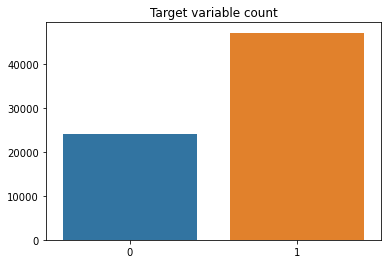

In [11]:
x=all_train_data['Labels'].value_counts().values
print(x)
sns.barplot([1,0],x)
plt.title('Target variable count')

In [12]:
%%time
# From kernel https://www.kaggle.com/gemartin/load-data-reduce-memory-usage
# WARNING! THIS CAN DAMAGE THE DATA 
def reduce_mem_usage2(df):
    """ iterate through all the columns of a dataframe and modify the data type
        to reduce memory usage.        
    """
    start_mem = df.memory_usage().sum() / 1024**2
    print('Memory usage of dataframe is {:.2f} MB'.format(start_mem))
    
    for col in df.columns:
        col_type = df[col].dtype
        
        if col_type != object:
            c_min = df[col].min()
            c_max = df[col].max()
            if str(col_type)[:3] == 'int':
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)  
            else:
                if c_min > np.finfo(np.float16).min and c_max < np.finfo(np.float16).max:
                    df[col] = df[col].astype(np.float16)
                elif c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                    df[col] = df[col].astype(np.float32)
                else:
                    df[col] = df[col].astype(np.float64)
        else:
            df[col] = df[col].astype('category')

    end_mem = df.memory_usage().sum() / 1024**2
    print('Memory usage after optimization is: {:.2f} MB'.format(end_mem))
    print('Decreased by {:.1f}%'.format(100 * (start_mem - end_mem) / start_mem))
    
    return df

Wall time: 0 ns


In [13]:
%%time
all_train_data = reduce_mem_usage2(all_train_data)
all_test_data = reduce_mem_usage2(all_test_data)

Memory usage of dataframe is 2.72 MB
Memory usage after optimization is: 3.34 MB
Decreased by -22.6%
Memory usage of dataframe is 0.42 MB
Memory usage after optimization is: 0.77 MB
Decreased by -81.7%
Wall time: 138 ms


In [14]:
all_train_data['pub_date'] = pd.to_datetime(all_train_data['pub_date'], errors='coerce')
all_train_data['day'] = all_train_data['pub_date'].dt.day_name() 

In [15]:
all_test_data['pub_date'] = pd.to_datetime(all_test_data['pub_date'], errors='coerce')
all_test_data['day'] = all_test_data['pub_date'].dt.day_name() 

In [16]:
import s2cell
all_train_data['latitude']=all_train_data['s2token_15'].apply (lambda row: s2cell.token_to_lat_lon(row)[0])
all_train_data['longitude']=all_train_data['s2token_15'].apply (lambda row: s2cell.token_to_lat_lon(row)[1])

all_test_data['latitude']=all_test_data['s2token_15'].apply (lambda row: s2cell.token_to_lat_lon(row)[0])
all_test_data['longitude']=all_test_data['s2token_15'].apply (lambda row: s2cell.token_to_lat_lon(row)[1])


In [17]:
all_train_data['Labels']=pd.to_numeric(all_train_data['Labels'])
all_train_data['hour']=pd.to_numeric(all_train_data['hour'])
all_test_data['hour']=pd.to_numeric(all_test_data['hour'])
y_train_all = all_train_data['Labels']
all_train_data['day']=encoder.fit_transform(all_train_data['day'])
all_test_data['day']=encoder.fit_transform(all_test_data['day'])

In [18]:
dropped_columns = ['Labels','Ids','pub_date','s2token_15']
for col in dropped_columns:
    all_train_data = all_train_data.drop(col,axis=1)

In [19]:
dropped_columns_test = ['Ids','pub_date','s2token_15']

for col in dropped_columns_test:
    all_test_data = all_test_data.drop(col,axis=1)

In [20]:
all_train_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 71336 entries, 0 to 71335
Data columns (total 4 columns):
 #   Column     Non-Null Count  Dtype   
---  ------     --------------  -----   
 0   hour       71336 non-null  int64   
 1   day        71336 non-null  int32   
 2   latitude   71336 non-null  category
 3   longitude  71336 non-null  float64 
dtypes: category(1), float64(1), int32(1), int64(1)
memory usage: 1.7 MB


In [21]:
all_test_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 13841 entries, 0 to 13840
Data columns (total 4 columns):
 #   Column     Non-Null Count  Dtype   
---  ------     --------------  -----   
 0   hour       13841 non-null  int64   
 1   day        13841 non-null  int32   
 2   latitude   13841 non-null  category
 3   longitude  13841 non-null  float64 
dtypes: category(1), float64(1), int32(1), int64(1)
memory usage: 377.3 KB


In [22]:
y_train_all.head()

0    1
1    1
2    1
3    1
4    1
Name: Labels, dtype: int8

In [23]:
all_train_data["longitude"] = all_train_data["longitude"].astype("float64")
all_train_data["latitude"] = all_train_data["latitude"].astype("float64")
all_test_data["longitude"] = all_test_data["longitude"].astype("float64")
all_test_data["latitude"] = all_test_data["latitude"].astype("float64")

<div align='left'><font size='4' color='#229954'>Splitting to train and validation</font></div>


- We will now split the train dataset into train and validation set.
- We will keeep 20% of data for validation.

In [24]:
# X_train_, X_test_, y_train_, y_test_ = train_test_split(all_train_data,y_train_all, test_size=0.2, random_state=38)



## [Resampling](#5)<a id="5"></a> <br>

A widely adopted technique for dealing with highly unbalanced datasets is called resampling. It consists of removing samples from the majority class (under-sampling) and / or adding more examples from the minority class (over-sampling).

![](https://raw.githubusercontent.com/rafjaa/machine_learning_fecib/master/src/static/img/resampling.png)

## [Resampling Techniques using sklearn](#6)<a id="6"></a> <br>

<div align='left'><font size='4' color=' #6c3483'> 1.Oversample minority class </font></div>

Oversampling can be defined as adding more copies of the minority class. Oversampling can be a good choice when you don’t have a ton of data to work with.

We will use the resampling module from Scikit-Learn to randomly replicate samples from the minority class.

In [25]:
# from sklearn.utils import resample


# X=pd.concat([X_train_,y_train_],axis=1)


# not_jam=X[X.Labels==0]
# jam=X[X.Labels==1]

# # upsample minority
# jam_upsampled = resample(jam,
#                           replace=True, # sample with replacement
#                           n_samples=len(not_jam), # match number in majority class
#                           random_state=27) # reproducible results

# # combine majority and upsampled minority
# upsampled = pd.concat([not_jam, jam_upsampled])

# # check new class counts
# upsampled.Labels.value_counts()



In [26]:
# y=upsampled.Labels.value_counts()
# sns.barplot(y=y,x=[0,1])
# plt.title('upsampled data class count')
# plt.ylabel('count')

In [27]:
# upsampled.info()

In [28]:
# upsampled["longitude"] = upsampled["longitude"].astype("float64")
# upsampled["latitude"] = upsampled["latitude"].astype("float64")

In [29]:
# upsampled.info()

In [30]:
# # Split new upsampled Dataset
# y_train_all = upsampled['Labels']
# dropped_columns = ['Labels']
# for col in dropped_columns:
#     all_train_data = upsampled.drop(col,axis=1)

In [31]:
# all_test_data["longitude"] = all_test_data["longitude"].astype("float64")
# all_test_data["latitude"] = all_test_data["latitude"].astype("float64")

In [32]:
# all_test_data.info()

# CatBoost

In [33]:
X_train_, X_test_, y_train_, y_test_ = train_test_split(all_train_data,y_train_all, test_size=0.2, random_state=38)


In [34]:
from catboost import Pool, CatBoostClassifier, cv
model = CatBoostClassifier(iterations=5000, learning_rate=0.01, l2_leaf_reg=3.5,colsample_bylevel= 0.09890530836500062,
                           depth= 4, boosting_type= "Plain",  eval_metric='Logloss',use_best_model=True,
                           random_seed=42,bootstrap_type= "Bayesian", bagging_temperature= 3.1351041422561403)
cate_features_index = np.where(X_train_.dtypes != float)[0] 


In [35]:
model.fit(X_train_, y_train_, cat_features=cate_features_index,eval_set=(X_test_, y_test_))


0:	learn: 0.6920868	test: 0.6920508	best: 0.6920508 (0)	total: 66.6ms	remaining: 5m 32s
1:	learn: 0.6910479	test: 0.6909762	best: 0.6909762 (1)	total: 77.8ms	remaining: 3m 14s
2:	learn: 0.6895588	test: 0.6894083	best: 0.6894083 (2)	total: 100ms	remaining: 2m 46s
3:	learn: 0.6885618	test: 0.6883762	best: 0.6883762 (3)	total: 111ms	remaining: 2m 18s
4:	learn: 0.6869989	test: 0.6867512	best: 0.6867512 (4)	total: 137ms	remaining: 2m 16s
5:	learn: 0.6859943	test: 0.6857206	best: 0.6857206 (5)	total: 156ms	remaining: 2m 10s
6:	learn: 0.6850566	test: 0.6847488	best: 0.6847488 (6)	total: 168ms	remaining: 1m 59s
7:	learn: 0.6841379	test: 0.6837964	best: 0.6837964 (7)	total: 179ms	remaining: 1m 51s
8:	learn: 0.6829735	test: 0.6825339	best: 0.6825339 (8)	total: 193ms	remaining: 1m 47s
9:	learn: 0.6820920	test: 0.6816200	best: 0.6816200 (9)	total: 205ms	remaining: 1m 42s
10:	learn: 0.6812285	test: 0.6807243	best: 0.6807243 (10)	total: 216ms	remaining: 1m 37s
11:	learn: 0.6803364	test: 0.6798085	be

103:	learn: 0.6382244	test: 0.6352906	best: 0.6352906 (103)	total: 1.46s	remaining: 1m 8s
104:	learn: 0.6380999	test: 0.6351543	best: 0.6351543 (104)	total: 1.47s	remaining: 1m 8s
105:	learn: 0.6379779	test: 0.6350207	best: 0.6350207 (105)	total: 1.49s	remaining: 1m 8s
106:	learn: 0.6378583	test: 0.6348896	best: 0.6348896 (106)	total: 1.5s	remaining: 1m 8s
107:	learn: 0.6373770	test: 0.6343664	best: 0.6343664 (107)	total: 1.52s	remaining: 1m 8s
108:	learn: 0.6372621	test: 0.6342402	best: 0.6342402 (108)	total: 1.53s	remaining: 1m 8s
109:	learn: 0.6371496	test: 0.6341165	best: 0.6341165 (109)	total: 1.54s	remaining: 1m 8s
110:	learn: 0.6370393	test: 0.6339952	best: 0.6339952 (110)	total: 1.55s	remaining: 1m 8s
111:	learn: 0.6368882	test: 0.6338325	best: 0.6338325 (111)	total: 1.57s	remaining: 1m 8s
112:	learn: 0.6367237	test: 0.6336624	best: 0.6336624 (112)	total: 1.59s	remaining: 1m 8s
113:	learn: 0.6365381	test: 0.6334841	best: 0.6334841 (113)	total: 1.6s	remaining: 1m 8s
114:	learn: 

204:	learn: 0.6291857	test: 0.6253068	best: 0.6253068 (204)	total: 2.86s	remaining: 1m 6s
205:	learn: 0.6287908	test: 0.6248776	best: 0.6248776 (205)	total: 2.88s	remaining: 1m 7s
206:	learn: 0.6287752	test: 0.6248579	best: 0.6248579 (206)	total: 2.89s	remaining: 1m 6s
207:	learn: 0.6287269	test: 0.6248101	best: 0.6248101 (207)	total: 2.9s	remaining: 1m 6s
208:	learn: 0.6286832	test: 0.6247631	best: 0.6247631 (208)	total: 2.92s	remaining: 1m 6s
209:	learn: 0.6286209	test: 0.6246992	best: 0.6246992 (209)	total: 2.94s	remaining: 1m 6s
210:	learn: 0.6286066	test: 0.6246809	best: 0.6246809 (210)	total: 2.95s	remaining: 1m 6s
211:	learn: 0.6285925	test: 0.6246629	best: 0.6246629 (211)	total: 2.96s	remaining: 1m 6s
212:	learn: 0.6285788	test: 0.6246453	best: 0.6246453 (212)	total: 2.98s	remaining: 1m 6s
213:	learn: 0.6285077	test: 0.6245685	best: 0.6245685 (213)	total: 3s	remaining: 1m 7s
214:	learn: 0.6284945	test: 0.6245514	best: 0.6245514 (214)	total: 3.01s	remaining: 1m 7s
215:	learn: 0.

300:	learn: 0.6237813	test: 0.6192303	best: 0.6192303 (300)	total: 4.25s	remaining: 1m 6s
301:	learn: 0.6237790	test: 0.6192265	best: 0.6192265 (301)	total: 4.26s	remaining: 1m 6s
302:	learn: 0.6237768	test: 0.6192228	best: 0.6192228 (302)	total: 4.27s	remaining: 1m 6s
303:	learn: 0.6237746	test: 0.6192191	best: 0.6192191 (303)	total: 4.29s	remaining: 1m 6s
304:	learn: 0.6237725	test: 0.6192156	best: 0.6192156 (304)	total: 4.3s	remaining: 1m 6s
305:	learn: 0.6237704	test: 0.6192120	best: 0.6192120 (305)	total: 4.31s	remaining: 1m 6s
306:	learn: 0.6237684	test: 0.6192085	best: 0.6192085 (306)	total: 4.33s	remaining: 1m 6s
307:	learn: 0.6237664	test: 0.6192051	best: 0.6192051 (307)	total: 4.34s	remaining: 1m 6s
308:	learn: 0.6237644	test: 0.6192017	best: 0.6192017 (308)	total: 4.35s	remaining: 1m 6s
309:	learn: 0.6237339	test: 0.6191708	best: 0.6191708 (309)	total: 4.37s	remaining: 1m 6s
310:	learn: 0.6237320	test: 0.6191675	best: 0.6191675 (310)	total: 4.38s	remaining: 1m 6s
311:	learn:

398:	learn: 0.6197126	test: 0.6147725	best: 0.6147725 (398)	total: 5.6s	remaining: 1m 4s
399:	learn: 0.6196505	test: 0.6147059	best: 0.6147059 (399)	total: 5.62s	remaining: 1m 4s
400:	learn: 0.6196501	test: 0.6147050	best: 0.6147050 (400)	total: 5.64s	remaining: 1m 4s
401:	learn: 0.6195885	test: 0.6146278	best: 0.6146278 (401)	total: 5.65s	remaining: 1m 4s
402:	learn: 0.6195882	test: 0.6146269	best: 0.6146269 (402)	total: 5.66s	remaining: 1m 4s
403:	learn: 0.6195226	test: 0.6145483	best: 0.6145483 (403)	total: 5.68s	remaining: 1m 4s
404:	learn: 0.6194170	test: 0.6144386	best: 0.6144386 (404)	total: 5.7s	remaining: 1m 4s
405:	learn: 0.6194167	test: 0.6144378	best: 0.6144378 (405)	total: 5.71s	remaining: 1m 4s
406:	learn: 0.6194164	test: 0.6144369	best: 0.6144369 (406)	total: 5.72s	remaining: 1m 4s
407:	learn: 0.6194028	test: 0.6144254	best: 0.6144254 (407)	total: 5.74s	remaining: 1m 4s
408:	learn: 0.6194026	test: 0.6144246	best: 0.6144246 (408)	total: 5.75s	remaining: 1m 4s
409:	learn: 

502:	learn: 0.6177816	test: 0.6125807	best: 0.6125807 (502)	total: 7.02s	remaining: 1m 2s
503:	learn: 0.6177751	test: 0.6125763	best: 0.6125763 (503)	total: 7.03s	remaining: 1m 2s
504:	learn: 0.6177751	test: 0.6125760	best: 0.6125760 (504)	total: 7.04s	remaining: 1m 2s
505:	learn: 0.6177749	test: 0.6125756	best: 0.6125756 (505)	total: 7.06s	remaining: 1m 2s
506:	learn: 0.6177749	test: 0.6125754	best: 0.6125754 (506)	total: 7.07s	remaining: 1m 2s
507:	learn: 0.6177749	test: 0.6125752	best: 0.6125752 (507)	total: 7.08s	remaining: 1m 2s
508:	learn: 0.6177748	test: 0.6125750	best: 0.6125750 (508)	total: 7.1s	remaining: 1m 2s
509:	learn: 0.6177748	test: 0.6125748	best: 0.6125748 (509)	total: 7.11s	remaining: 1m 2s
510:	learn: 0.6177748	test: 0.6125745	best: 0.6125745 (510)	total: 7.12s	remaining: 1m 2s
511:	learn: 0.6177675	test: 0.6125693	best: 0.6125693 (511)	total: 7.14s	remaining: 1m 2s
512:	learn: 0.6177582	test: 0.6125621	best: 0.6125621 (512)	total: 7.15s	remaining: 1m 2s
513:	learn:

603:	learn: 0.6165170	test: 0.6112390	best: 0.6112390 (603)	total: 8.41s	remaining: 1m 1s
604:	learn: 0.6164614	test: 0.6111997	best: 0.6111997 (604)	total: 8.43s	remaining: 1m 1s
605:	learn: 0.6164568	test: 0.6111969	best: 0.6111969 (605)	total: 8.45s	remaining: 1m 1s
606:	learn: 0.6164568	test: 0.6111969	best: 0.6111969 (606)	total: 8.46s	remaining: 1m 1s
607:	learn: 0.6164212	test: 0.6111561	best: 0.6111561 (607)	total: 8.47s	remaining: 1m 1s
608:	learn: 0.6164212	test: 0.6111560	best: 0.6111560 (608)	total: 8.48s	remaining: 1m 1s
609:	learn: 0.6164212	test: 0.6111560	best: 0.6111560 (609)	total: 8.49s	remaining: 1m 1s
610:	learn: 0.6164212	test: 0.6111559	best: 0.6111559 (610)	total: 8.5s	remaining: 1m 1s
611:	learn: 0.6163721	test: 0.6110998	best: 0.6110998 (611)	total: 8.52s	remaining: 1m 1s
612:	learn: 0.6163205	test: 0.6110357	best: 0.6110357 (612)	total: 8.54s	remaining: 1m 1s
613:	learn: 0.6163205	test: 0.6110357	best: 0.6110357 (613)	total: 8.55s	remaining: 1m 1s
614:	learn:

709:	learn: 0.6155160	test: 0.6101454	best: 0.6101454 (709)	total: 9.83s	remaining: 59.4s
710:	learn: 0.6154908	test: 0.6101074	best: 0.6101074 (710)	total: 9.85s	remaining: 59.4s
711:	learn: 0.6154908	test: 0.6101074	best: 0.6101074 (711)	total: 9.86s	remaining: 59.4s
712:	learn: 0.6154592	test: 0.6100666	best: 0.6100666 (712)	total: 9.88s	remaining: 59.4s
713:	learn: 0.6154310	test: 0.6100334	best: 0.6100334 (713)	total: 9.9s	remaining: 59.4s
714:	learn: 0.6154310	test: 0.6100334	best: 0.6100334 (714)	total: 9.91s	remaining: 59.4s
715:	learn: 0.6153596	test: 0.6099628	best: 0.6099628 (715)	total: 9.94s	remaining: 59.5s
716:	learn: 0.6153084	test: 0.6099060	best: 0.6099060 (716)	total: 9.96s	remaining: 59.5s
717:	learn: 0.6153084	test: 0.6099060	best: 0.6099060 (717)	total: 9.97s	remaining: 59.5s
718:	learn: 0.6153084	test: 0.6099060	best: 0.6099060 (718)	total: 9.99s	remaining: 59.5s
719:	learn: 0.6153084	test: 0.6099060	best: 0.6099060 (719)	total: 10s	remaining: 59.4s
720:	learn: 0

802:	learn: 0.6143148	test: 0.6088245	best: 0.6088245 (802)	total: 11.2s	remaining: 58.7s
803:	learn: 0.6143148	test: 0.6088245	best: 0.6088245 (803)	total: 11.2s	remaining: 58.6s
804:	learn: 0.6143148	test: 0.6088245	best: 0.6088245 (804)	total: 11.2s	remaining: 58.6s
805:	learn: 0.6143148	test: 0.6088244	best: 0.6088244 (805)	total: 11.3s	remaining: 58.6s
806:	learn: 0.6143148	test: 0.6088244	best: 0.6088244 (806)	total: 11.3s	remaining: 58.6s
807:	learn: 0.6143024	test: 0.6088126	best: 0.6088126 (807)	total: 11.3s	remaining: 58.5s
808:	learn: 0.6143024	test: 0.6088126	best: 0.6088126 (808)	total: 11.3s	remaining: 58.5s
809:	learn: 0.6143024	test: 0.6088126	best: 0.6088126 (809)	total: 11.3s	remaining: 58.5s
810:	learn: 0.6142828	test: 0.6087822	best: 0.6087822 (810)	total: 11.3s	remaining: 58.5s
811:	learn: 0.6142828	test: 0.6087822	best: 0.6087822 (811)	total: 11.3s	remaining: 58.4s
812:	learn: 0.6142828	test: 0.6087822	best: 0.6087822 (812)	total: 11.3s	remaining: 58.4s
813:	learn

900:	learn: 0.6131539	test: 0.6075690	best: 0.6075690 (900)	total: 12.6s	remaining: 57.4s
901:	learn: 0.6131539	test: 0.6075690	best: 0.6075690 (901)	total: 12.6s	remaining: 57.3s
902:	learn: 0.6131524	test: 0.6075688	best: 0.6075688 (902)	total: 12.6s	remaining: 57.3s
903:	learn: 0.6131434	test: 0.6075644	best: 0.6075644 (903)	total: 12.7s	remaining: 57.3s
904:	learn: 0.6131434	test: 0.6075644	best: 0.6075644 (904)	total: 12.7s	remaining: 57.3s
905:	learn: 0.6131434	test: 0.6075644	best: 0.6075644 (905)	total: 12.7s	remaining: 57.3s
906:	learn: 0.6130984	test: 0.6075297	best: 0.6075297 (906)	total: 12.7s	remaining: 57.3s
907:	learn: 0.6130748	test: 0.6074949	best: 0.6074949 (907)	total: 12.7s	remaining: 57.3s
908:	learn: 0.6130748	test: 0.6074949	best: 0.6074949 (908)	total: 12.7s	remaining: 57.3s
909:	learn: 0.6130748	test: 0.6074949	best: 0.6074949 (909)	total: 12.7s	remaining: 57.3s
910:	learn: 0.6130439	test: 0.6074530	best: 0.6074530 (910)	total: 12.8s	remaining: 57.3s
911:	learn

1004:	learn: 0.6126535	test: 0.6070349	best: 0.6070349 (1004)	total: 14.2s	remaining: 56.5s
1005:	learn: 0.6126535	test: 0.6070349	best: 0.6070349 (1004)	total: 14.2s	remaining: 56.5s
1006:	learn: 0.6126494	test: 0.6070309	best: 0.6070309 (1006)	total: 14.2s	remaining: 56.5s
1007:	learn: 0.6126494	test: 0.6070309	best: 0.6070309 (1006)	total: 14.3s	remaining: 56.5s
1008:	learn: 0.6126494	test: 0.6070309	best: 0.6070309 (1006)	total: 14.3s	remaining: 56.4s
1009:	learn: 0.6126494	test: 0.6070309	best: 0.6070309 (1006)	total: 14.3s	remaining: 56.4s
1010:	learn: 0.6126494	test: 0.6070309	best: 0.6070309 (1006)	total: 14.3s	remaining: 56.4s
1011:	learn: 0.6126494	test: 0.6070309	best: 0.6070309 (1006)	total: 14.3s	remaining: 56.4s
1012:	learn: 0.6126494	test: 0.6070309	best: 0.6070309 (1006)	total: 14.3s	remaining: 56.3s
1013:	learn: 0.6126494	test: 0.6070309	best: 0.6070309 (1006)	total: 14.3s	remaining: 56.3s
1014:	learn: 0.6126494	test: 0.6070309	best: 0.6070309 (1006)	total: 14.3s	remai

1107:	learn: 0.6121255	test: 0.6064888	best: 0.6064888 (1101)	total: 15.6s	remaining: 54.8s
1108:	learn: 0.6121255	test: 0.6064888	best: 0.6064888 (1101)	total: 15.6s	remaining: 54.8s
1109:	learn: 0.6121255	test: 0.6064888	best: 0.6064888 (1101)	total: 15.6s	remaining: 54.8s
1110:	learn: 0.6121255	test: 0.6064888	best: 0.6064888 (1101)	total: 15.6s	remaining: 54.7s
1111:	learn: 0.6121184	test: 0.6064790	best: 0.6064790 (1111)	total: 15.6s	remaining: 54.7s
1112:	learn: 0.6121184	test: 0.6064790	best: 0.6064790 (1111)	total: 15.7s	remaining: 54.7s
1113:	learn: 0.6120374	test: 0.6063948	best: 0.6063948 (1113)	total: 15.7s	remaining: 54.7s
1114:	learn: 0.6120374	test: 0.6063948	best: 0.6063948 (1114)	total: 15.7s	remaining: 54.7s
1115:	learn: 0.6120374	test: 0.6063948	best: 0.6063948 (1115)	total: 15.7s	remaining: 54.6s
1116:	learn: 0.6120374	test: 0.6063948	best: 0.6063948 (1116)	total: 15.7s	remaining: 54.6s
1117:	learn: 0.6120374	test: 0.6063948	best: 0.6063948 (1117)	total: 15.7s	remai

1199:	learn: 0.6113745	test: 0.6056702	best: 0.6056702 (1199)	total: 17s	remaining: 53.9s
1200:	learn: 0.6113745	test: 0.6056702	best: 0.6056702 (1200)	total: 17s	remaining: 53.9s
1201:	learn: 0.6113745	test: 0.6056702	best: 0.6056702 (1201)	total: 17s	remaining: 53.9s
1202:	learn: 0.6113745	test: 0.6056702	best: 0.6056702 (1202)	total: 17.1s	remaining: 53.8s
1203:	learn: 0.6113745	test: 0.6056702	best: 0.6056702 (1203)	total: 17.1s	remaining: 53.9s
1204:	learn: 0.6113602	test: 0.6056568	best: 0.6056568 (1204)	total: 17.1s	remaining: 53.9s
1205:	learn: 0.6113602	test: 0.6056568	best: 0.6056568 (1205)	total: 17.1s	remaining: 53.8s
1206:	learn: 0.6113602	test: 0.6056568	best: 0.6056568 (1206)	total: 17.1s	remaining: 53.8s
1207:	learn: 0.6113602	test: 0.6056568	best: 0.6056568 (1207)	total: 17.1s	remaining: 53.8s
1208:	learn: 0.6113602	test: 0.6056568	best: 0.6056568 (1208)	total: 17.2s	remaining: 53.8s
1209:	learn: 0.6113602	test: 0.6056568	best: 0.6056568 (1209)	total: 17.2s	remaining: 

1300:	learn: 0.6107456	test: 0.6049530	best: 0.6049530 (1298)	total: 18.6s	remaining: 52.9s
1301:	learn: 0.6107355	test: 0.6049402	best: 0.6049402 (1301)	total: 18.6s	remaining: 52.9s
1302:	learn: 0.6107355	test: 0.6049402	best: 0.6049402 (1301)	total: 18.6s	remaining: 52.9s
1303:	learn: 0.6107355	test: 0.6049402	best: 0.6049402 (1301)	total: 18.7s	remaining: 52.9s
1304:	learn: 0.6107355	test: 0.6049402	best: 0.6049402 (1301)	total: 18.7s	remaining: 52.8s
1305:	learn: 0.6107355	test: 0.6049402	best: 0.6049402 (1301)	total: 18.7s	remaining: 52.8s
1306:	learn: 0.6107252	test: 0.6049281	best: 0.6049281 (1306)	total: 18.7s	remaining: 52.8s
1307:	learn: 0.6107252	test: 0.6049281	best: 0.6049281 (1306)	total: 18.7s	remaining: 52.8s
1308:	learn: 0.6107240	test: 0.6049264	best: 0.6049264 (1308)	total: 18.7s	remaining: 52.8s
1309:	learn: 0.6107163	test: 0.6049144	best: 0.6049144 (1309)	total: 18.7s	remaining: 52.8s
1310:	learn: 0.6107163	test: 0.6049145	best: 0.6049144 (1309)	total: 18.8s	remai

1394:	learn: 0.6102529	test: 0.6044256	best: 0.6044256 (1393)	total: 20s	remaining: 51.7s
1395:	learn: 0.6102529	test: 0.6044256	best: 0.6044256 (1393)	total: 20s	remaining: 51.7s
1396:	learn: 0.6102529	test: 0.6044256	best: 0.6044256 (1393)	total: 20s	remaining: 51.7s
1397:	learn: 0.6102529	test: 0.6044256	best: 0.6044256 (1393)	total: 20s	remaining: 51.7s
1398:	learn: 0.6102396	test: 0.6044142	best: 0.6044142 (1398)	total: 20.1s	remaining: 51.7s
1399:	learn: 0.6102396	test: 0.6044142	best: 0.6044142 (1398)	total: 20.1s	remaining: 51.6s
1400:	learn: 0.6102396	test: 0.6044142	best: 0.6044142 (1398)	total: 20.1s	remaining: 51.6s
1401:	learn: 0.6102396	test: 0.6044142	best: 0.6044142 (1398)	total: 20.1s	remaining: 51.6s
1402:	learn: 0.6102184	test: 0.6044034	best: 0.6044034 (1402)	total: 20.1s	remaining: 51.6s
1403:	learn: 0.6102184	test: 0.6044034	best: 0.6044034 (1402)	total: 20.2s	remaining: 51.6s
1404:	learn: 0.6102074	test: 0.6043889	best: 0.6043889 (1404)	total: 20.2s	remaining: 51

1495:	learn: 0.6097046	test: 0.6038144	best: 0.6038144 (1494)	total: 21.6s	remaining: 50.7s
1496:	learn: 0.6097046	test: 0.6038144	best: 0.6038144 (1494)	total: 21.6s	remaining: 50.6s
1497:	learn: 0.6097046	test: 0.6038144	best: 0.6038144 (1494)	total: 21.7s	remaining: 50.6s
1498:	learn: 0.6097046	test: 0.6038144	best: 0.6038144 (1494)	total: 21.7s	remaining: 50.6s
1499:	learn: 0.6097033	test: 0.6038110	best: 0.6038110 (1499)	total: 21.7s	remaining: 50.6s
1500:	learn: 0.6097033	test: 0.6038110	best: 0.6038110 (1499)	total: 21.7s	remaining: 50.6s
1501:	learn: 0.6097032	test: 0.6038109	best: 0.6038109 (1501)	total: 21.7s	remaining: 50.6s
1502:	learn: 0.6097032	test: 0.6038109	best: 0.6038109 (1501)	total: 21.8s	remaining: 50.6s
1503:	learn: 0.6097025	test: 0.6038110	best: 0.6038109 (1501)	total: 21.8s	remaining: 50.7s
1504:	learn: 0.6097025	test: 0.6038110	best: 0.6038109 (1501)	total: 21.8s	remaining: 50.6s
1505:	learn: 0.6097025	test: 0.6038110	best: 0.6038109 (1501)	total: 21.8s	remai

1593:	learn: 0.6092401	test: 0.6033191	best: 0.6033191 (1593)	total: 23.5s	remaining: 50.1s
1594:	learn: 0.6092125	test: 0.6032834	best: 0.6032834 (1594)	total: 23.5s	remaining: 50.1s
1595:	learn: 0.6092125	test: 0.6032834	best: 0.6032834 (1594)	total: 23.5s	remaining: 50.1s
1596:	learn: 0.6092044	test: 0.6032783	best: 0.6032783 (1596)	total: 23.5s	remaining: 50.1s
1597:	learn: 0.6091485	test: 0.6032295	best: 0.6032295 (1597)	total: 23.5s	remaining: 50.1s
1598:	learn: 0.6091485	test: 0.6032295	best: 0.6032295 (1597)	total: 23.6s	remaining: 50.1s
1599:	learn: 0.6090634	test: 0.6031132	best: 0.6031132 (1599)	total: 23.6s	remaining: 50.1s
1600:	learn: 0.6090634	test: 0.6031132	best: 0.6031132 (1599)	total: 23.6s	remaining: 50.1s
1601:	learn: 0.6090588	test: 0.6031054	best: 0.6031054 (1601)	total: 23.6s	remaining: 50.1s
1602:	learn: 0.6090588	test: 0.6031054	best: 0.6031054 (1601)	total: 23.6s	remaining: 50.1s
1603:	learn: 0.6090588	test: 0.6031054	best: 0.6031054 (1601)	total: 23.7s	remai

1684:	learn: 0.6088118	test: 0.6028460	best: 0.6028460 (1681)	total: 25.1s	remaining: 49.4s
1685:	learn: 0.6088118	test: 0.6028460	best: 0.6028460 (1681)	total: 25.1s	remaining: 49.4s
1686:	learn: 0.6088076	test: 0.6028399	best: 0.6028399 (1686)	total: 25.1s	remaining: 49.4s
1687:	learn: 0.6088076	test: 0.6028399	best: 0.6028399 (1686)	total: 25.2s	remaining: 49.4s
1688:	learn: 0.6088049	test: 0.6028359	best: 0.6028359 (1688)	total: 25.2s	remaining: 49.4s
1689:	learn: 0.6087945	test: 0.6028303	best: 0.6028303 (1689)	total: 25.2s	remaining: 49.4s
1690:	learn: 0.6087945	test: 0.6028303	best: 0.6028303 (1689)	total: 25.2s	remaining: 49.4s
1691:	learn: 0.6087867	test: 0.6028274	best: 0.6028274 (1691)	total: 25.3s	remaining: 49.4s
1692:	learn: 0.6087867	test: 0.6028274	best: 0.6028274 (1691)	total: 25.3s	remaining: 49.4s
1693:	learn: 0.6087867	test: 0.6028274	best: 0.6028274 (1691)	total: 25.3s	remaining: 49.3s
1694:	learn: 0.6087867	test: 0.6028274	best: 0.6028274 (1691)	total: 25.3s	remai

1778:	learn: 0.6084683	test: 0.6025347	best: 0.6025347 (1778)	total: 26.7s	remaining: 48.4s
1779:	learn: 0.6084672	test: 0.6025327	best: 0.6025327 (1779)	total: 26.7s	remaining: 48.3s
1780:	learn: 0.6084672	test: 0.6025327	best: 0.6025327 (1779)	total: 26.7s	remaining: 48.3s
1781:	learn: 0.6084609	test: 0.6025284	best: 0.6025284 (1781)	total: 26.8s	remaining: 48.3s
1782:	learn: 0.6084609	test: 0.6025284	best: 0.6025284 (1781)	total: 26.8s	remaining: 48.3s
1783:	learn: 0.6084609	test: 0.6025284	best: 0.6025284 (1781)	total: 26.8s	remaining: 48.3s
1784:	learn: 0.6084609	test: 0.6025284	best: 0.6025284 (1781)	total: 26.8s	remaining: 48.3s
1785:	learn: 0.6084213	test: 0.6024811	best: 0.6024811 (1785)	total: 26.8s	remaining: 48.3s
1786:	learn: 0.6084213	test: 0.6024811	best: 0.6024811 (1785)	total: 26.8s	remaining: 48.2s
1787:	learn: 0.6084213	test: 0.6024811	best: 0.6024811 (1785)	total: 26.8s	remaining: 48.2s
1788:	learn: 0.6084213	test: 0.6024811	best: 0.6024811 (1785)	total: 26.9s	remai

1870:	learn: 0.6082050	test: 0.6022510	best: 0.6022510 (1870)	total: 28.1s	remaining: 47s
1871:	learn: 0.6082050	test: 0.6022510	best: 0.6022510 (1870)	total: 28.1s	remaining: 47s
1872:	learn: 0.6081936	test: 0.6022397	best: 0.6022397 (1872)	total: 28.1s	remaining: 47s
1873:	learn: 0.6081921	test: 0.6022370	best: 0.6022370 (1873)	total: 28.2s	remaining: 47s
1874:	learn: 0.6081921	test: 0.6022370	best: 0.6022370 (1873)	total: 28.2s	remaining: 47s
1875:	learn: 0.6081921	test: 0.6022370	best: 0.6022370 (1873)	total: 28.2s	remaining: 46.9s
1876:	learn: 0.6081921	test: 0.6022370	best: 0.6022370 (1873)	total: 28.2s	remaining: 46.9s
1877:	learn: 0.6081921	test: 0.6022370	best: 0.6022370 (1873)	total: 28.2s	remaining: 46.9s
1878:	learn: 0.6081606	test: 0.6022143	best: 0.6022143 (1878)	total: 28.2s	remaining: 46.9s
1879:	learn: 0.6081539	test: 0.6022102	best: 0.6022102 (1879)	total: 28.2s	remaining: 46.9s
1880:	learn: 0.6081337	test: 0.6021966	best: 0.6021966 (1880)	total: 28.3s	remaining: 46.9

1962:	learn: 0.6079664	test: 0.6020153	best: 0.6020153 (1961)	total: 29.5s	remaining: 45.7s
1963:	learn: 0.6079664	test: 0.6020153	best: 0.6020153 (1961)	total: 29.5s	remaining: 45.6s
1964:	learn: 0.6079664	test: 0.6020153	best: 0.6020153 (1961)	total: 29.5s	remaining: 45.6s
1965:	learn: 0.6079664	test: 0.6020153	best: 0.6020153 (1961)	total: 29.6s	remaining: 45.6s
1966:	learn: 0.6079664	test: 0.6020153	best: 0.6020153 (1961)	total: 29.6s	remaining: 45.6s
1967:	learn: 0.6079664	test: 0.6020153	best: 0.6020153 (1961)	total: 29.6s	remaining: 45.6s
1968:	learn: 0.6079627	test: 0.6020097	best: 0.6020097 (1968)	total: 29.6s	remaining: 45.6s
1969:	learn: 0.6079627	test: 0.6020097	best: 0.6020097 (1968)	total: 29.6s	remaining: 45.6s
1970:	learn: 0.6079620	test: 0.6020094	best: 0.6020094 (1970)	total: 29.6s	remaining: 45.5s
1971:	learn: 0.6079620	test: 0.6020094	best: 0.6020094 (1970)	total: 29.6s	remaining: 45.5s
1972:	learn: 0.6079589	test: 0.6020069	best: 0.6020069 (1972)	total: 29.7s	remai

2052:	learn: 0.6077452	test: 0.6017690	best: 0.6017690 (2051)	total: 30.9s	remaining: 44.4s
2053:	learn: 0.6077414	test: 0.6017627	best: 0.6017627 (2053)	total: 30.9s	remaining: 44.4s
2054:	learn: 0.6077414	test: 0.6017627	best: 0.6017627 (2053)	total: 31s	remaining: 44.4s
2055:	learn: 0.6077414	test: 0.6017627	best: 0.6017627 (2053)	total: 31s	remaining: 44.3s
2056:	learn: 0.6077414	test: 0.6017627	best: 0.6017627 (2053)	total: 31s	remaining: 44.3s
2057:	learn: 0.6077382	test: 0.6017612	best: 0.6017612 (2057)	total: 31s	remaining: 44.3s
2058:	learn: 0.6077382	test: 0.6017612	best: 0.6017612 (2057)	total: 31s	remaining: 44.3s
2059:	learn: 0.6077382	test: 0.6017612	best: 0.6017612 (2057)	total: 31s	remaining: 44.3s
2060:	learn: 0.6077382	test: 0.6017612	best: 0.6017612 (2057)	total: 31s	remaining: 44.2s
2061:	learn: 0.6076482	test: 0.6016748	best: 0.6016748 (2061)	total: 31.1s	remaining: 44.2s
2062:	learn: 0.6076450	test: 0.6016732	best: 0.6016732 (2062)	total: 31.1s	remaining: 44.2s
20

2151:	learn: 0.6074498	test: 0.6014517	best: 0.6014517 (2151)	total: 32.5s	remaining: 43s
2152:	learn: 0.6074498	test: 0.6014517	best: 0.6014517 (2151)	total: 32.5s	remaining: 43s
2153:	learn: 0.6074485	test: 0.6014515	best: 0.6014515 (2153)	total: 32.6s	remaining: 43s
2154:	learn: 0.6074485	test: 0.6014515	best: 0.6014515 (2153)	total: 32.6s	remaining: 43s
2155:	learn: 0.6074485	test: 0.6014515	best: 0.6014515 (2153)	total: 32.6s	remaining: 43s
2156:	learn: 0.6073993	test: 0.6013966	best: 0.6013966 (2156)	total: 32.6s	remaining: 43s
2157:	learn: 0.6073993	test: 0.6013966	best: 0.6013966 (2156)	total: 32.6s	remaining: 43s
2158:	learn: 0.6073993	test: 0.6013966	best: 0.6013966 (2156)	total: 32.6s	remaining: 43s
2159:	learn: 0.6073992	test: 0.6013966	best: 0.6013966 (2156)	total: 32.7s	remaining: 42.9s
2160:	learn: 0.6073963	test: 0.6013922	best: 0.6013922 (2160)	total: 32.7s	remaining: 42.9s
2161:	learn: 0.6073963	test: 0.6013922	best: 0.6013922 (2161)	total: 32.7s	remaining: 42.9s
2162

2252:	learn: 0.6072801	test: 0.6012715	best: 0.6012715 (2250)	total: 34.1s	remaining: 41.6s
2253:	learn: 0.6072694	test: 0.6012617	best: 0.6012617 (2253)	total: 34.2s	remaining: 41.6s
2254:	learn: 0.6072694	test: 0.6012617	best: 0.6012617 (2253)	total: 34.2s	remaining: 41.6s
2255:	learn: 0.6072694	test: 0.6012617	best: 0.6012617 (2253)	total: 34.2s	remaining: 41.6s
2256:	learn: 0.6072694	test: 0.6012617	best: 0.6012617 (2253)	total: 34.2s	remaining: 41.6s
2257:	learn: 0.6072686	test: 0.6012597	best: 0.6012597 (2257)	total: 34.2s	remaining: 41.6s
2258:	learn: 0.6072686	test: 0.6012597	best: 0.6012597 (2257)	total: 34.2s	remaining: 41.5s
2259:	learn: 0.6072686	test: 0.6012597	best: 0.6012597 (2257)	total: 34.2s	remaining: 41.5s
2260:	learn: 0.6072686	test: 0.6012597	best: 0.6012597 (2257)	total: 34.3s	remaining: 41.5s
2261:	learn: 0.6072686	test: 0.6012597	best: 0.6012597 (2257)	total: 34.3s	remaining: 41.5s
2262:	learn: 0.6072686	test: 0.6012597	best: 0.6012597 (2257)	total: 34.3s	remai

2354:	learn: 0.6070614	test: 0.6010278	best: 0.6010278 (2351)	total: 35.8s	remaining: 40.2s
2355:	learn: 0.6070614	test: 0.6010278	best: 0.6010278 (2351)	total: 35.8s	remaining: 40.1s
2356:	learn: 0.6070586	test: 0.6010280	best: 0.6010278 (2351)	total: 35.8s	remaining: 40.1s
2357:	learn: 0.6070550	test: 0.6010258	best: 0.6010258 (2357)	total: 35.8s	remaining: 40.1s
2358:	learn: 0.6070550	test: 0.6010258	best: 0.6010258 (2357)	total: 35.8s	remaining: 40.1s
2359:	learn: 0.6070550	test: 0.6010258	best: 0.6010258 (2357)	total: 35.8s	remaining: 40.1s
2360:	learn: 0.6070550	test: 0.6010258	best: 0.6010258 (2357)	total: 35.8s	remaining: 40.1s
2361:	learn: 0.6070550	test: 0.6010258	best: 0.6010258 (2357)	total: 35.9s	remaining: 40s
2362:	learn: 0.6070550	test: 0.6010258	best: 0.6010258 (2357)	total: 35.9s	remaining: 40s
2363:	learn: 0.6070550	test: 0.6010258	best: 0.6010258 (2357)	total: 35.9s	remaining: 40s
2364:	learn: 0.6070532	test: 0.6010244	best: 0.6010244 (2364)	total: 35.9s	remaining: 

2455:	learn: 0.6068642	test: 0.6008210	best: 0.6008210 (2455)	total: 37.3s	remaining: 38.7s
2456:	learn: 0.6068642	test: 0.6008210	best: 0.6008210 (2455)	total: 37.4s	remaining: 38.7s
2457:	learn: 0.6068640	test: 0.6008205	best: 0.6008205 (2457)	total: 37.4s	remaining: 38.7s
2458:	learn: 0.6068640	test: 0.6008204	best: 0.6008204 (2458)	total: 37.4s	remaining: 38.6s
2459:	learn: 0.6068640	test: 0.6008204	best: 0.6008204 (2458)	total: 37.4s	remaining: 38.6s
2460:	learn: 0.6068524	test: 0.6008113	best: 0.6008113 (2460)	total: 37.4s	remaining: 38.6s
2461:	learn: 0.6068502	test: 0.6008078	best: 0.6008078 (2461)	total: 37.5s	remaining: 38.6s
2462:	learn: 0.6068502	test: 0.6008078	best: 0.6008078 (2461)	total: 37.5s	remaining: 38.6s
2463:	learn: 0.6068502	test: 0.6008078	best: 0.6008078 (2461)	total: 37.5s	remaining: 38.6s
2464:	learn: 0.6068502	test: 0.6008078	best: 0.6008078 (2461)	total: 37.5s	remaining: 38.6s
2465:	learn: 0.6068502	test: 0.6008078	best: 0.6008078 (2461)	total: 37.5s	remai

2549:	learn: 0.6066113	test: 0.6005771	best: 0.6005770 (2540)	total: 39s	remaining: 37.4s
2550:	learn: 0.6066112	test: 0.6005770	best: 0.6005770 (2540)	total: 39s	remaining: 37.4s
2551:	learn: 0.6066090	test: 0.6005758	best: 0.6005758 (2551)	total: 39s	remaining: 37.4s
2552:	learn: 0.6066090	test: 0.6005758	best: 0.6005758 (2551)	total: 39s	remaining: 37.4s
2553:	learn: 0.6066090	test: 0.6005758	best: 0.6005758 (2551)	total: 39s	remaining: 37.4s
2554:	learn: 0.6066090	test: 0.6005758	best: 0.6005758 (2551)	total: 39s	remaining: 37.4s
2555:	learn: 0.6066090	test: 0.6005758	best: 0.6005758 (2551)	total: 39.1s	remaining: 37.4s
2556:	learn: 0.6066072	test: 0.6005749	best: 0.6005749 (2556)	total: 39.1s	remaining: 37.3s
2557:	learn: 0.6066072	test: 0.6005749	best: 0.6005749 (2556)	total: 39.1s	remaining: 37.3s
2558:	learn: 0.6066065	test: 0.6005747	best: 0.6005747 (2558)	total: 39.1s	remaining: 37.3s
2559:	learn: 0.6066065	test: 0.6005747	best: 0.6005747 (2558)	total: 39.1s	remaining: 37.3s


2650:	learn: 0.6063994	test: 0.6004000	best: 0.6004000 (2650)	total: 40.6s	remaining: 36s
2651:	learn: 0.6063899	test: 0.6003910	best: 0.6003910 (2651)	total: 40.6s	remaining: 35.9s
2652:	learn: 0.6063796	test: 0.6003786	best: 0.6003786 (2652)	total: 40.6s	remaining: 35.9s
2653:	learn: 0.6063796	test: 0.6003786	best: 0.6003786 (2652)	total: 40.6s	remaining: 35.9s
2654:	learn: 0.6063796	test: 0.6003787	best: 0.6003786 (2652)	total: 40.7s	remaining: 35.9s
2655:	learn: 0.6063796	test: 0.6003787	best: 0.6003786 (2652)	total: 40.7s	remaining: 35.9s
2656:	learn: 0.6063796	test: 0.6003787	best: 0.6003786 (2652)	total: 40.7s	remaining: 35.9s
2657:	learn: 0.6063796	test: 0.6003787	best: 0.6003786 (2652)	total: 40.7s	remaining: 35.9s
2658:	learn: 0.6063790	test: 0.6003774	best: 0.6003774 (2658)	total: 40.7s	remaining: 35.8s
2659:	learn: 0.6063790	test: 0.6003774	best: 0.6003774 (2658)	total: 40.7s	remaining: 35.8s
2660:	learn: 0.6063790	test: 0.6003774	best: 0.6003774 (2658)	total: 40.8s	remaini

2746:	learn: 0.6061472	test: 0.6001049	best: 0.6001049 (2744)	total: 42.1s	remaining: 34.6s
2747:	learn: 0.6061472	test: 0.6001049	best: 0.6001049 (2744)	total: 42.1s	remaining: 34.5s
2748:	learn: 0.6061472	test: 0.6001049	best: 0.6001049 (2744)	total: 42.2s	remaining: 34.5s
2749:	learn: 0.6061470	test: 0.6001042	best: 0.6001042 (2749)	total: 42.2s	remaining: 34.5s
2750:	learn: 0.6061470	test: 0.6001042	best: 0.6001042 (2749)	total: 42.2s	remaining: 34.5s
2751:	learn: 0.6061470	test: 0.6001042	best: 0.6001042 (2749)	total: 42.2s	remaining: 34.5s
2752:	learn: 0.6061451	test: 0.6001023	best: 0.6001023 (2752)	total: 42.2s	remaining: 34.5s
2753:	learn: 0.6061415	test: 0.6000993	best: 0.6000993 (2753)	total: 42.3s	remaining: 34.5s
2754:	learn: 0.6061415	test: 0.6000993	best: 0.6000993 (2753)	total: 42.3s	remaining: 34.4s
2755:	learn: 0.6061415	test: 0.6000993	best: 0.6000993 (2753)	total: 42.3s	remaining: 34.4s
2756:	learn: 0.6061353	test: 0.6000935	best: 0.6000935 (2756)	total: 42.3s	remai

2843:	learn: 0.6059318	test: 0.5998873	best: 0.5998872 (2840)	total: 43.7s	remaining: 33.2s
2844:	learn: 0.6059318	test: 0.5998873	best: 0.5998872 (2840)	total: 43.8s	remaining: 33.1s
2845:	learn: 0.6059316	test: 0.5998873	best: 0.5998872 (2840)	total: 43.8s	remaining: 33.1s
2846:	learn: 0.6059316	test: 0.5998873	best: 0.5998872 (2840)	total: 43.8s	remaining: 33.1s
2847:	learn: 0.6059316	test: 0.5998873	best: 0.5998872 (2840)	total: 43.8s	remaining: 33.1s
2848:	learn: 0.6059316	test: 0.5998873	best: 0.5998872 (2840)	total: 43.8s	remaining: 33.1s
2849:	learn: 0.6059316	test: 0.5998873	best: 0.5998872 (2840)	total: 43.8s	remaining: 33.1s
2850:	learn: 0.6059278	test: 0.5998830	best: 0.5998830 (2850)	total: 43.8s	remaining: 33s
2851:	learn: 0.6059278	test: 0.5998830	best: 0.5998830 (2850)	total: 43.9s	remaining: 33s
2852:	learn: 0.6059278	test: 0.5998830	best: 0.5998830 (2850)	total: 43.9s	remaining: 33s
2853:	learn: 0.6059276	test: 0.5998816	best: 0.5998816 (2853)	total: 43.9s	remaining: 

2940:	learn: 0.6057054	test: 0.5996232	best: 0.5996232 (2940)	total: 45.3s	remaining: 31.7s
2941:	learn: 0.6056973	test: 0.5996141	best: 0.5996141 (2941)	total: 45.3s	remaining: 31.7s
2942:	learn: 0.6056973	test: 0.5996141	best: 0.5996141 (2941)	total: 45.4s	remaining: 31.7s
2943:	learn: 0.6056973	test: 0.5996141	best: 0.5996141 (2941)	total: 45.4s	remaining: 31.7s
2944:	learn: 0.6056973	test: 0.5996141	best: 0.5996141 (2941)	total: 45.4s	remaining: 31.7s
2945:	learn: 0.6056973	test: 0.5996141	best: 0.5996141 (2941)	total: 45.4s	remaining: 31.6s
2946:	learn: 0.6056973	test: 0.5996141	best: 0.5996141 (2941)	total: 45.4s	remaining: 31.6s
2947:	learn: 0.6056973	test: 0.5996142	best: 0.5996141 (2941)	total: 45.4s	remaining: 31.6s
2948:	learn: 0.6056973	test: 0.5996142	best: 0.5996141 (2941)	total: 45.4s	remaining: 31.6s
2949:	learn: 0.6056973	test: 0.5996142	best: 0.5996141 (2941)	total: 45.4s	remaining: 31.6s
2950:	learn: 0.6056973	test: 0.5996142	best: 0.5996141 (2941)	total: 45.5s	remai

3041:	learn: 0.6054797	test: 0.5994088	best: 0.5994088 (3040)	total: 46.9s	remaining: 30.2s
3042:	learn: 0.6054797	test: 0.5994088	best: 0.5994088 (3040)	total: 46.9s	remaining: 30.2s
3043:	learn: 0.6054797	test: 0.5994088	best: 0.5994088 (3040)	total: 46.9s	remaining: 30.2s
3044:	learn: 0.6054797	test: 0.5994088	best: 0.5994088 (3040)	total: 47s	remaining: 30.1s
3045:	learn: 0.6054797	test: 0.5994088	best: 0.5994088 (3040)	total: 47s	remaining: 30.1s
3046:	learn: 0.6054710	test: 0.5993981	best: 0.5993981 (3046)	total: 47s	remaining: 30.1s
3047:	learn: 0.6054710	test: 0.5993981	best: 0.5993981 (3046)	total: 47s	remaining: 30.1s
3048:	learn: 0.6054710	test: 0.5993981	best: 0.5993981 (3046)	total: 47s	remaining: 30.1s
3049:	learn: 0.6054708	test: 0.5993974	best: 0.5993974 (3049)	total: 47s	remaining: 30.1s
3050:	learn: 0.6054708	test: 0.5993974	best: 0.5993974 (3049)	total: 47.1s	remaining: 30.1s
3051:	learn: 0.6054708	test: 0.5993974	best: 0.5993974 (3049)	total: 47.1s	remaining: 30s
30

3137:	learn: 0.6051449	test: 0.5990676	best: 0.5990676 (3134)	total: 48.5s	remaining: 28.8s
3138:	learn: 0.6051448	test: 0.5990675	best: 0.5990675 (3138)	total: 48.5s	remaining: 28.8s
3139:	learn: 0.6051415	test: 0.5990658	best: 0.5990658 (3139)	total: 48.6s	remaining: 28.8s
3140:	learn: 0.6051411	test: 0.5990646	best: 0.5990646 (3140)	total: 48.6s	remaining: 28.8s
3141:	learn: 0.6051282	test: 0.5990539	best: 0.5990539 (3141)	total: 48.6s	remaining: 28.7s
3142:	learn: 0.6051282	test: 0.5990539	best: 0.5990539 (3141)	total: 48.6s	remaining: 28.7s
3143:	learn: 0.6051282	test: 0.5990539	best: 0.5990539 (3141)	total: 48.6s	remaining: 28.7s
3144:	learn: 0.6051282	test: 0.5990539	best: 0.5990539 (3141)	total: 48.6s	remaining: 28.7s
3145:	learn: 0.6051282	test: 0.5990539	best: 0.5990539 (3141)	total: 48.7s	remaining: 28.7s
3146:	learn: 0.6051282	test: 0.5990537	best: 0.5990537 (3146)	total: 48.7s	remaining: 28.7s
3147:	learn: 0.6051282	test: 0.5990537	best: 0.5990537 (3146)	total: 48.7s	remai

3233:	learn: 0.6049071	test: 0.5987968	best: 0.5987968 (3233)	total: 50.1s	remaining: 27.4s
3234:	learn: 0.6049069	test: 0.5987964	best: 0.5987964 (3234)	total: 50.1s	remaining: 27.4s
3235:	learn: 0.6049069	test: 0.5987964	best: 0.5987964 (3234)	total: 50.2s	remaining: 27.3s
3236:	learn: 0.6049069	test: 0.5987965	best: 0.5987964 (3234)	total: 50.2s	remaining: 27.3s
3237:	learn: 0.6049069	test: 0.5987965	best: 0.5987964 (3234)	total: 50.2s	remaining: 27.3s
3238:	learn: 0.6049069	test: 0.5987965	best: 0.5987964 (3234)	total: 50.2s	remaining: 27.3s
3239:	learn: 0.6049069	test: 0.5987965	best: 0.5987964 (3234)	total: 50.2s	remaining: 27.3s
3240:	learn: 0.6049069	test: 0.5987965	best: 0.5987964 (3234)	total: 50.2s	remaining: 27.3s
3241:	learn: 0.6049069	test: 0.5987965	best: 0.5987964 (3234)	total: 50.3s	remaining: 27.3s
3242:	learn: 0.6049069	test: 0.5987963	best: 0.5987963 (3242)	total: 50.3s	remaining: 27.2s
3243:	learn: 0.6049069	test: 0.5987963	best: 0.5987963 (3242)	total: 50.3s	remai

3331:	learn: 0.6046905	test: 0.5985589	best: 0.5985589 (3325)	total: 51.7s	remaining: 25.9s
3332:	learn: 0.6046865	test: 0.5985583	best: 0.5985583 (3332)	total: 51.7s	remaining: 25.9s
3333:	learn: 0.6046865	test: 0.5985583	best: 0.5985583 (3332)	total: 51.8s	remaining: 25.9s
3334:	learn: 0.6046857	test: 0.5985572	best: 0.5985572 (3334)	total: 51.8s	remaining: 25.8s
3335:	learn: 0.6046857	test: 0.5985572	best: 0.5985572 (3334)	total: 51.8s	remaining: 25.8s
3336:	learn: 0.6046857	test: 0.5985572	best: 0.5985572 (3334)	total: 51.8s	remaining: 25.8s
3337:	learn: 0.6046842	test: 0.5985578	best: 0.5985572 (3334)	total: 51.8s	remaining: 25.8s
3338:	learn: 0.6046842	test: 0.5985578	best: 0.5985572 (3334)	total: 51.8s	remaining: 25.8s
3339:	learn: 0.6046842	test: 0.5985578	best: 0.5985572 (3334)	total: 51.8s	remaining: 25.8s
3340:	learn: 0.6046830	test: 0.5985581	best: 0.5985572 (3334)	total: 51.9s	remaining: 25.8s
3341:	learn: 0.6046830	test: 0.5985581	best: 0.5985572 (3334)	total: 51.9s	remai

3421:	learn: 0.6045975	test: 0.5984710	best: 0.5984710 (3419)	total: 53.1s	remaining: 24.5s
3422:	learn: 0.6045704	test: 0.5984403	best: 0.5984403 (3422)	total: 53.1s	remaining: 24.5s
3423:	learn: 0.6045704	test: 0.5984403	best: 0.5984403 (3422)	total: 53.2s	remaining: 24.5s
3424:	learn: 0.6045704	test: 0.5984403	best: 0.5984403 (3422)	total: 53.2s	remaining: 24.5s
3425:	learn: 0.6045693	test: 0.5984386	best: 0.5984386 (3425)	total: 53.2s	remaining: 24.4s
3426:	learn: 0.6045693	test: 0.5984386	best: 0.5984386 (3425)	total: 53.2s	remaining: 24.4s
3427:	learn: 0.6045684	test: 0.5984386	best: 0.5984386 (3425)	total: 53.2s	remaining: 24.4s
3428:	learn: 0.6045679	test: 0.5984386	best: 0.5984386 (3425)	total: 53.3s	remaining: 24.4s
3429:	learn: 0.6045535	test: 0.5984242	best: 0.5984242 (3429)	total: 53.3s	remaining: 24.4s
3430:	learn: 0.6045535	test: 0.5984242	best: 0.5984242 (3429)	total: 53.3s	remaining: 24.4s
3431:	learn: 0.6045535	test: 0.5984242	best: 0.5984242 (3429)	total: 53.3s	remai

3514:	learn: 0.6042946	test: 0.5981515	best: 0.5981515 (3513)	total: 54.7s	remaining: 23.1s
3515:	learn: 0.6042929	test: 0.5981521	best: 0.5981515 (3513)	total: 54.7s	remaining: 23.1s
3516:	learn: 0.6042910	test: 0.5981493	best: 0.5981493 (3516)	total: 54.8s	remaining: 23.1s
3517:	learn: 0.6042910	test: 0.5981493	best: 0.5981493 (3516)	total: 54.8s	remaining: 23.1s
3518:	learn: 0.6042910	test: 0.5981493	best: 0.5981493 (3516)	total: 54.8s	remaining: 23.1s
3519:	learn: 0.6042909	test: 0.5981491	best: 0.5981491 (3519)	total: 54.8s	remaining: 23s
3520:	learn: 0.6042909	test: 0.5981491	best: 0.5981491 (3519)	total: 54.8s	remaining: 23s
3521:	learn: 0.6042744	test: 0.5981298	best: 0.5981298 (3521)	total: 54.8s	remaining: 23s
3522:	learn: 0.6042744	test: 0.5981298	best: 0.5981298 (3521)	total: 54.8s	remaining: 23s
3523:	learn: 0.6042697	test: 0.5981236	best: 0.5981236 (3523)	total: 54.9s	remaining: 23s
3524:	learn: 0.6042697	test: 0.5981236	best: 0.5981236 (3523)	total: 54.9s	remaining: 23s


3615:	learn: 0.6040987	test: 0.5979673	best: 0.5979673 (3615)	total: 56.3s	remaining: 21.6s
3616:	learn: 0.6040987	test: 0.5979673	best: 0.5979673 (3616)	total: 56.4s	remaining: 21.5s
3617:	learn: 0.6040987	test: 0.5979673	best: 0.5979673 (3617)	total: 56.4s	remaining: 21.5s
3618:	learn: 0.6040987	test: 0.5979673	best: 0.5979673 (3618)	total: 56.4s	remaining: 21.5s
3619:	learn: 0.6040987	test: 0.5979673	best: 0.5979673 (3619)	total: 56.4s	remaining: 21.5s
3620:	learn: 0.6040987	test: 0.5979673	best: 0.5979673 (3620)	total: 56.4s	remaining: 21.5s
3621:	learn: 0.6040987	test: 0.5979673	best: 0.5979673 (3621)	total: 56.4s	remaining: 21.5s
3622:	learn: 0.6040987	test: 0.5979673	best: 0.5979673 (3622)	total: 56.4s	remaining: 21.4s
3623:	learn: 0.6040987	test: 0.5979673	best: 0.5979673 (3623)	total: 56.4s	remaining: 21.4s
3624:	learn: 0.6040987	test: 0.5979673	best: 0.5979673 (3624)	total: 56.5s	remaining: 21.4s
3625:	learn: 0.6040987	test: 0.5979674	best: 0.5979673 (3624)	total: 56.5s	remai

3710:	learn: 0.6040568	test: 0.5979222	best: 0.5979222 (3708)	total: 57.7s	remaining: 20.1s
3711:	learn: 0.6040568	test: 0.5979222	best: 0.5979222 (3708)	total: 57.8s	remaining: 20s
3712:	learn: 0.6040568	test: 0.5979222	best: 0.5979222 (3708)	total: 57.8s	remaining: 20s
3713:	learn: 0.6040568	test: 0.5979222	best: 0.5979222 (3708)	total: 57.8s	remaining: 20s
3714:	learn: 0.6040564	test: 0.5979219	best: 0.5979219 (3714)	total: 57.8s	remaining: 20s
3715:	learn: 0.6040564	test: 0.5979219	best: 0.5979219 (3714)	total: 57.8s	remaining: 20s
3716:	learn: 0.6040564	test: 0.5979219	best: 0.5979219 (3714)	total: 57.8s	remaining: 20s
3717:	learn: 0.6040237	test: 0.5978857	best: 0.5978857 (3717)	total: 57.8s	remaining: 19.9s
3718:	learn: 0.6040237	test: 0.5978857	best: 0.5978857 (3718)	total: 57.9s	remaining: 19.9s
3719:	learn: 0.6040237	test: 0.5978857	best: 0.5978857 (3719)	total: 57.9s	remaining: 19.9s
3720:	learn: 0.6040237	test: 0.5978857	best: 0.5978857 (3720)	total: 57.9s	remaining: 19.9s


3809:	learn: 0.6038980	test: 0.5977545	best: 0.5977545 (3809)	total: 59.2s	remaining: 18.5s
3810:	learn: 0.6038980	test: 0.5977547	best: 0.5977545 (3809)	total: 59.2s	remaining: 18.5s
3811:	learn: 0.6038980	test: 0.5977547	best: 0.5977545 (3809)	total: 59.2s	remaining: 18.4s
3812:	learn: 0.6038980	test: 0.5977547	best: 0.5977545 (3809)	total: 59.2s	remaining: 18.4s
3813:	learn: 0.6038980	test: 0.5977547	best: 0.5977545 (3809)	total: 59.2s	remaining: 18.4s
3814:	learn: 0.6038980	test: 0.5977547	best: 0.5977545 (3809)	total: 59.2s	remaining: 18.4s
3815:	learn: 0.6038980	test: 0.5977546	best: 0.5977545 (3809)	total: 59.3s	remaining: 18.4s
3816:	learn: 0.6038980	test: 0.5977546	best: 0.5977545 (3809)	total: 59.3s	remaining: 18.4s
3817:	learn: 0.6038980	test: 0.5977546	best: 0.5977545 (3809)	total: 59.3s	remaining: 18.4s
3818:	learn: 0.6038980	test: 0.5977546	best: 0.5977545 (3809)	total: 59.3s	remaining: 18.3s
3819:	learn: 0.6038980	test: 0.5977546	best: 0.5977545 (3809)	total: 59.3s	remai

3908:	learn: 0.6037768	test: 0.5976427	best: 0.5976427 (3903)	total: 1m	remaining: 17s
3909:	learn: 0.6037753	test: 0.5976411	best: 0.5976411 (3909)	total: 1m	remaining: 16.9s
3910:	learn: 0.6037753	test: 0.5976412	best: 0.5976411 (3909)	total: 1m	remaining: 16.9s
3911:	learn: 0.6037752	test: 0.5976408	best: 0.5976408 (3911)	total: 1m	remaining: 16.9s
3912:	learn: 0.6037743	test: 0.5976402	best: 0.5976402 (3912)	total: 1m	remaining: 16.9s
3913:	learn: 0.6037743	test: 0.5976402	best: 0.5976402 (3912)	total: 1m	remaining: 16.9s
3914:	learn: 0.6037743	test: 0.5976402	best: 0.5976402 (3912)	total: 1m	remaining: 16.9s
3915:	learn: 0.6037743	test: 0.5976402	best: 0.5976402 (3912)	total: 1m	remaining: 16.9s
3916:	learn: 0.6037743	test: 0.5976402	best: 0.5976402 (3912)	total: 1m	remaining: 16.8s
3917:	learn: 0.6037743	test: 0.5976398	best: 0.5976398 (3917)	total: 1m	remaining: 16.8s
3918:	learn: 0.6037467	test: 0.5976122	best: 0.5976122 (3918)	total: 1m	remaining: 16.8s
3919:	learn: 0.6037467	

4002:	learn: 0.6036513	test: 0.5975183	best: 0.5975183 (3999)	total: 1m 2s	remaining: 15.5s
4003:	learn: 0.6036467	test: 0.5975129	best: 0.5975129 (4003)	total: 1m 2s	remaining: 15.5s
4004:	learn: 0.6036467	test: 0.5975129	best: 0.5975129 (4003)	total: 1m 2s	remaining: 15.5s
4005:	learn: 0.6036467	test: 0.5975129	best: 0.5975129 (4003)	total: 1m 2s	remaining: 15.5s
4006:	learn: 0.6036467	test: 0.5975129	best: 0.5975129 (4003)	total: 1m 2s	remaining: 15.5s
4007:	learn: 0.6036467	test: 0.5975129	best: 0.5975129 (4003)	total: 1m 2s	remaining: 15.5s
4008:	learn: 0.6036467	test: 0.5975129	best: 0.5975129 (4003)	total: 1m 2s	remaining: 15.4s
4009:	learn: 0.6036467	test: 0.5975129	best: 0.5975129 (4003)	total: 1m 2s	remaining: 15.4s
4010:	learn: 0.6036446	test: 0.5975100	best: 0.5975100 (4010)	total: 1m 2s	remaining: 15.4s
4011:	learn: 0.6036446	test: 0.5975100	best: 0.5975100 (4010)	total: 1m 2s	remaining: 15.4s
4012:	learn: 0.6036446	test: 0.5975100	best: 0.5975100 (4010)	total: 1m 2s	remai

4099:	learn: 0.6035547	test: 0.5974204	best: 0.5974204 (4099)	total: 1m 3s	remaining: 14s
4100:	learn: 0.6035547	test: 0.5974204	best: 0.5974204 (4099)	total: 1m 3s	remaining: 14s
4101:	learn: 0.6035547	test: 0.5974204	best: 0.5974204 (4099)	total: 1m 3s	remaining: 14s
4102:	learn: 0.6035547	test: 0.5974204	best: 0.5974204 (4099)	total: 1m 4s	remaining: 14s
4103:	learn: 0.6035547	test: 0.5974204	best: 0.5974204 (4099)	total: 1m 4s	remaining: 14s
4104:	learn: 0.6035547	test: 0.5974204	best: 0.5974204 (4099)	total: 1m 4s	remaining: 14s
4105:	learn: 0.6035516	test: 0.5974156	best: 0.5974156 (4105)	total: 1m 4s	remaining: 14s
4106:	learn: 0.6035516	test: 0.5974156	best: 0.5974156 (4105)	total: 1m 4s	remaining: 13.9s
4107:	learn: 0.6035516	test: 0.5974156	best: 0.5974156 (4105)	total: 1m 4s	remaining: 13.9s
4108:	learn: 0.6035502	test: 0.5974158	best: 0.5974156 (4105)	total: 1m 4s	remaining: 13.9s
4109:	learn: 0.6035502	test: 0.5974158	best: 0.5974156 (4105)	total: 1m 4s	remaining: 13.9s
41

4190:	learn: 0.6032547	test: 0.5971261	best: 0.5971261 (4186)	total: 1m 5s	remaining: 12.6s
4191:	learn: 0.6032547	test: 0.5971261	best: 0.5971261 (4186)	total: 1m 5s	remaining: 12.6s
4192:	learn: 0.6032547	test: 0.5971261	best: 0.5971261 (4186)	total: 1m 5s	remaining: 12.6s
4193:	learn: 0.6032402	test: 0.5971087	best: 0.5971087 (4193)	total: 1m 5s	remaining: 12.6s
4194:	learn: 0.6032402	test: 0.5971087	best: 0.5971087 (4193)	total: 1m 5s	remaining: 12.6s
4195:	learn: 0.6032402	test: 0.5971087	best: 0.5971087 (4193)	total: 1m 5s	remaining: 12.6s
4196:	learn: 0.6032402	test: 0.5971087	best: 0.5971087 (4193)	total: 1m 5s	remaining: 12.6s
4197:	learn: 0.6032353	test: 0.5971016	best: 0.5971016 (4197)	total: 1m 5s	remaining: 12.5s
4198:	learn: 0.6032353	test: 0.5971016	best: 0.5971016 (4197)	total: 1m 5s	remaining: 12.5s
4199:	learn: 0.6032351	test: 0.5971015	best: 0.5971015 (4199)	total: 1m 5s	remaining: 12.5s
4200:	learn: 0.6032351	test: 0.5971015	best: 0.5971015 (4199)	total: 1m 5s	remai

4280:	learn: 0.6029977	test: 0.5968679	best: 0.5968679 (4278)	total: 1m 6s	remaining: 11.2s
4281:	learn: 0.6029977	test: 0.5968679	best: 0.5968679 (4278)	total: 1m 6s	remaining: 11.2s
4282:	learn: 0.6029962	test: 0.5968663	best: 0.5968663 (4282)	total: 1m 6s	remaining: 11.2s
4283:	learn: 0.6029953	test: 0.5968638	best: 0.5968638 (4283)	total: 1m 6s	remaining: 11.2s
4284:	learn: 0.6029531	test: 0.5968173	best: 0.5968173 (4284)	total: 1m 7s	remaining: 11.2s
4285:	learn: 0.6029531	test: 0.5968173	best: 0.5968173 (4284)	total: 1m 7s	remaining: 11.2s
4286:	learn: 0.6029459	test: 0.5968085	best: 0.5968085 (4286)	total: 1m 7s	remaining: 11.2s
4287:	learn: 0.6029459	test: 0.5968085	best: 0.5968085 (4286)	total: 1m 7s	remaining: 11.1s
4288:	learn: 0.6029459	test: 0.5968085	best: 0.5968085 (4286)	total: 1m 7s	remaining: 11.1s
4289:	learn: 0.6029459	test: 0.5968085	best: 0.5968085 (4286)	total: 1m 7s	remaining: 11.1s
4290:	learn: 0.6029459	test: 0.5968085	best: 0.5968085 (4286)	total: 1m 7s	remai

4373:	learn: 0.6027535	test: 0.5966073	best: 0.5966073 (4373)	total: 1m 8s	remaining: 9.78s
4374:	learn: 0.6027535	test: 0.5966073	best: 0.5966073 (4373)	total: 1m 8s	remaining: 9.77s
4375:	learn: 0.6027535	test: 0.5966073	best: 0.5966073 (4373)	total: 1m 8s	remaining: 9.75s
4376:	learn: 0.6027535	test: 0.5966073	best: 0.5966073 (4373)	total: 1m 8s	remaining: 9.73s
4377:	learn: 0.6027535	test: 0.5966073	best: 0.5966073 (4373)	total: 1m 8s	remaining: 9.72s
4378:	learn: 0.6027522	test: 0.5966049	best: 0.5966049 (4378)	total: 1m 8s	remaining: 9.7s
4379:	learn: 0.6027494	test: 0.5966013	best: 0.5966013 (4379)	total: 1m 8s	remaining: 9.69s
4380:	learn: 0.6027494	test: 0.5966013	best: 0.5966013 (4379)	total: 1m 8s	remaining: 9.68s
4381:	learn: 0.6027473	test: 0.5965995	best: 0.5965995 (4381)	total: 1m 8s	remaining: 9.66s
4382:	learn: 0.6027473	test: 0.5965995	best: 0.5965995 (4381)	total: 1m 8s	remaining: 9.64s
4383:	learn: 0.6027461	test: 0.5965983	best: 0.5965983 (4383)	total: 1m 8s	remain

4470:	learn: 0.6026335	test: 0.5964871	best: 0.5964871 (4469)	total: 1m 9s	remaining: 8.28s
4471:	learn: 0.6026335	test: 0.5964871	best: 0.5964871 (4471)	total: 1m 9s	remaining: 8.26s
4472:	learn: 0.6026335	test: 0.5964871	best: 0.5964871 (4471)	total: 1m 9s	remaining: 8.24s
4473:	learn: 0.6026335	test: 0.5964871	best: 0.5964871 (4471)	total: 1m 10s	remaining: 8.23s
4474:	learn: 0.6026335	test: 0.5964872	best: 0.5964871 (4471)	total: 1m 10s	remaining: 8.21s
4475:	learn: 0.6026335	test: 0.5964872	best: 0.5964871 (4471)	total: 1m 10s	remaining: 8.2s
4476:	learn: 0.6026335	test: 0.5964872	best: 0.5964871 (4471)	total: 1m 10s	remaining: 8.18s
4477:	learn: 0.6026335	test: 0.5964872	best: 0.5964871 (4471)	total: 1m 10s	remaining: 8.16s
4478:	learn: 0.6026335	test: 0.5964872	best: 0.5964871 (4471)	total: 1m 10s	remaining: 8.15s
4479:	learn: 0.6026335	test: 0.5964872	best: 0.5964871 (4471)	total: 1m 10s	remaining: 8.13s
4480:	learn: 0.6026335	test: 0.5964872	best: 0.5964871 (4471)	total: 1m 10

4561:	learn: 0.6024802	test: 0.5963632	best: 0.5963630 (4560)	total: 1m 11s	remaining: 6.85s
4562:	learn: 0.6024802	test: 0.5963632	best: 0.5963630 (4560)	total: 1m 11s	remaining: 6.83s
4563:	learn: 0.6024789	test: 0.5963626	best: 0.5963626 (4563)	total: 1m 11s	remaining: 6.82s
4564:	learn: 0.6024789	test: 0.5963626	best: 0.5963626 (4563)	total: 1m 11s	remaining: 6.8s
4565:	learn: 0.6024738	test: 0.5963579	best: 0.5963579 (4565)	total: 1m 11s	remaining: 6.79s
4566:	learn: 0.6024736	test: 0.5963575	best: 0.5963575 (4566)	total: 1m 11s	remaining: 6.77s
4567:	learn: 0.6024736	test: 0.5963575	best: 0.5963575 (4566)	total: 1m 11s	remaining: 6.75s
4568:	learn: 0.6024736	test: 0.5963575	best: 0.5963575 (4566)	total: 1m 11s	remaining: 6.74s
4569:	learn: 0.6024732	test: 0.5963569	best: 0.5963569 (4569)	total: 1m 11s	remaining: 6.72s
4570:	learn: 0.6024732	test: 0.5963569	best: 0.5963569 (4569)	total: 1m 11s	remaining: 6.71s
4571:	learn: 0.6024732	test: 0.5963570	best: 0.5963569 (4569)	total: 1m

4650:	learn: 0.6023985	test: 0.5962831	best: 0.5962831 (4648)	total: 1m 12s	remaining: 5.46s
4651:	learn: 0.6023985	test: 0.5962831	best: 0.5962831 (4648)	total: 1m 12s	remaining: 5.44s
4652:	learn: 0.6023955	test: 0.5962788	best: 0.5962788 (4652)	total: 1m 12s	remaining: 5.42s
4653:	learn: 0.6023955	test: 0.5962788	best: 0.5962788 (4652)	total: 1m 12s	remaining: 5.41s
4654:	learn: 0.6023955	test: 0.5962788	best: 0.5962788 (4652)	total: 1m 12s	remaining: 5.39s
4655:	learn: 0.6023955	test: 0.5962788	best: 0.5962788 (4652)	total: 1m 12s	remaining: 5.38s
4656:	learn: 0.6023854	test: 0.5962751	best: 0.5962751 (4656)	total: 1m 12s	remaining: 5.36s
4657:	learn: 0.6023834	test: 0.5962739	best: 0.5962739 (4657)	total: 1m 12s	remaining: 5.35s
4658:	learn: 0.6023834	test: 0.5962739	best: 0.5962739 (4657)	total: 1m 12s	remaining: 5.33s
4659:	learn: 0.6023834	test: 0.5962739	best: 0.5962739 (4657)	total: 1m 12s	remaining: 5.31s
4660:	learn: 0.6023807	test: 0.5962700	best: 0.5962700 (4660)	total: 1

4741:	learn: 0.6022652	test: 0.5961786	best: 0.5961786 (4738)	total: 1m 14s	remaining: 4.03s
4742:	learn: 0.6022652	test: 0.5961786	best: 0.5961786 (4738)	total: 1m 14s	remaining: 4.01s
4743:	learn: 0.6022651	test: 0.5961785	best: 0.5961785 (4743)	total: 1m 14s	remaining: 4s
4744:	learn: 0.6022651	test: 0.5961785	best: 0.5961785 (4743)	total: 1m 14s	remaining: 3.98s
4745:	learn: 0.6022651	test: 0.5961785	best: 0.5961785 (4743)	total: 1m 14s	remaining: 3.97s
4746:	learn: 0.6022651	test: 0.5961785	best: 0.5961785 (4743)	total: 1m 14s	remaining: 3.95s
4747:	learn: 0.6022651	test: 0.5961785	best: 0.5961785 (4743)	total: 1m 14s	remaining: 3.94s
4748:	learn: 0.6022651	test: 0.5961785	best: 0.5961785 (4743)	total: 1m 14s	remaining: 3.92s
4749:	learn: 0.6022651	test: 0.5961785	best: 0.5961785 (4743)	total: 1m 14s	remaining: 3.9s
4750:	learn: 0.6022651	test: 0.5961785	best: 0.5961785 (4743)	total: 1m 14s	remaining: 3.89s
4751:	learn: 0.6022651	test: 0.5961785	best: 0.5961785 (4743)	total: 1m 14

4830:	learn: 0.6021505	test: 0.5960721	best: 0.5960721 (4829)	total: 1m 15s	remaining: 2.64s
4831:	learn: 0.6021505	test: 0.5960721	best: 0.5960721 (4829)	total: 1m 15s	remaining: 2.63s
4832:	learn: 0.6021505	test: 0.5960721	best: 0.5960721 (4829)	total: 1m 15s	remaining: 2.61s
4833:	learn: 0.6021505	test: 0.5960721	best: 0.5960721 (4829)	total: 1m 15s	remaining: 2.59s
4834:	learn: 0.6021505	test: 0.5960722	best: 0.5960721 (4829)	total: 1m 15s	remaining: 2.58s
4835:	learn: 0.6021475	test: 0.5960659	best: 0.5960659 (4835)	total: 1m 15s	remaining: 2.56s
4836:	learn: 0.6021475	test: 0.5960659	best: 0.5960659 (4835)	total: 1m 15s	remaining: 2.55s
4837:	learn: 0.6021475	test: 0.5960659	best: 0.5960659 (4835)	total: 1m 15s	remaining: 2.53s
4838:	learn: 0.6021475	test: 0.5960659	best: 0.5960659 (4835)	total: 1m 15s	remaining: 2.52s
4839:	learn: 0.6021475	test: 0.5960659	best: 0.5960659 (4835)	total: 1m 15s	remaining: 2.5s
4840:	learn: 0.6021475	test: 0.5960659	best: 0.5960659 (4835)	total: 1m

4921:	learn: 0.6020027	test: 0.5959278	best: 0.5959278 (4911)	total: 1m 16s	remaining: 1.22s
4922:	learn: 0.6020027	test: 0.5959278	best: 0.5959278 (4911)	total: 1m 16s	remaining: 1.2s
4923:	learn: 0.6020027	test: 0.5959278	best: 0.5959278 (4911)	total: 1m 16s	remaining: 1.19s
4924:	learn: 0.6020027	test: 0.5959278	best: 0.5959278 (4911)	total: 1m 16s	remaining: 1.17s
4925:	learn: 0.6020027	test: 0.5959278	best: 0.5959278 (4911)	total: 1m 16s	remaining: 1.16s
4926:	learn: 0.6020027	test: 0.5959278	best: 0.5959278 (4911)	total: 1m 16s	remaining: 1.14s
4927:	learn: 0.6020027	test: 0.5959278	best: 0.5959278 (4911)	total: 1m 16s	remaining: 1.12s
4928:	learn: 0.6020027	test: 0.5959278	best: 0.5959278 (4911)	total: 1m 16s	remaining: 1.11s
4929:	learn: 0.6020027	test: 0.5959278	best: 0.5959278 (4911)	total: 1m 16s	remaining: 1.09s
4930:	learn: 0.6020026	test: 0.5959278	best: 0.5959278 (4911)	total: 1m 16s	remaining: 1.08s
4931:	learn: 0.6020011	test: 0.5959268	best: 0.5959268 (4931)	total: 1m

In [36]:
pred = model.predict_proba(all_test_data)
preds= np.argmax(pred, axis=1)


In [37]:
preds=["TRUE" if x==1 else 'FALSE' for x in preds]


In [38]:
submission = pd.read_csv('data_test.csv')
submission['Labels']=preds

In [39]:
submission

,Ids,Labels
0,2e6992a84_2020-11-25_18,TRUE
1,2e68e62f4_2020-11-29_20,TRUE
2,2e68e81a4_2020-11-27_10,TRUE
3,2e69eec04_2020-11-24_7,TRUE
4,2e698e4a4_2020-11-27_8,TRUE
...,...,...
13836,2e68dd414_2020-11-26_5,FALSE
13837,2e698541c_2020-11-24_22,FALSE
13838,2e69e8e0c_2020-11-24_10,TRUE
13839,2e699a1cc_2020-11-24_18,TRUE


In [40]:
#generating submission csv
# submission = pd.DataFrame(preds)
#save the file to your directory
submission.to_csv('test-catboost.csv',index=False)

# Training LGBM

In [41]:
import lightgbm as lgb
# import optuna.integration.lightgbm as lgb
import optuna
import sklearn

In [42]:
X_train_

,hour,day,latitude,longitude
64557,15,0,-6.288459,106.952093
16662,22,0,-6.193291,106.972755
62922,10,6,-6.956332,107.581583
6597,21,2,-6.906395,107.608215
17177,12,6,-6.276950,106.913727
...,...,...,...,...
21762,10,0,-6.404998,106.757375
64388,14,0,-6.898450,107.614134
69948,16,4,-6.428860,106.733784
28491,9,5,-6.888380,107.608215


In [43]:
y_train_

64557    0
16662    1
62922    1
6597     1
17177    1
        ..
21762    1
64388    0
69948    1
28491    1
32161    1
Name: Labels, Length: 57068, dtype: int8

In [44]:
def objective(trial):
    dtrain = lgb.Dataset(X_train_, label=y_train_)
 
    param = {
        'objective': 'binary',
        'metric': 'binary_logloss',
#         'lambda_l1': trial.suggest_loguniform('lambda_l1', 1e-8, 10.0),
#         'lambda_l2': trial.suggest_loguniform('lambda_l2', 1e-8, 10.0),
#         'num_leaves': trial.suggest_int('num_leaves', 2, 256),
#         'feature_fraction': trial.suggest_uniform('feature_fraction', 0.4, 1.0),
#         'bagging_fraction': trial.suggest_uniform('bagging_fraction', 0.4, 1.0),
#         'bagging_freq': trial.suggest_int('bagging_freq', 1, 7),
#         'min_child_samples': trial.suggest_int('min_child_samples', 5, 100),
        'learning_rate':trial.suggest_uniform('learning_rate', 0.01, 0.08),
        'boosting_type':'gbdt',
        'max_depth' :trial.suggest_int('max_depth', 1, 100),

    }
 
    gbm = lgb.train(param, dtrain)
    preds = gbm.predict(X_test_)
    pred_labels = np.rint(preds)
    accuracy = sklearn.metrics.accuracy_score(y_test_, pred_labels)
    return accuracy
 
study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=100)
 
print('Number of finished trials:', len(study.trials))
print('Best trial:', study.best_trial.params)

[I 2021-03-26 15:29:56,579] A new study created in memory with name: no-name-90879fa5-92ad-4af3-bfff-9ec4216c0eb6


[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Info] Number of positive: 37684, number of negative: 19384
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000231 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 512
[LightGBM] [Info] Number of data points in the train set: 57068, number of used features: 4
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.660335 -> initscore=0.664788
[LightGBM] [Info] Start training from score 0.664788


[I 2021-03-26 15:29:56,830] Trial 0 finished with value: 0.7166386319035604 and parameters: {'learning_rate': 0.02707415484602406, 'max_depth': 81}. Best is trial 0 with value: 0.7166386319035604.
[I 2021-03-26 15:29:57,020] Trial 1 finished with value: 0.727291841883936 and parameters: {'learning_rate': 0.07377804572349547, 'max_depth': 38}. Best is trial 1 with value: 0.727291841883936.


[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Info] Number of positive: 37684, number of negative: 19384
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000269 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 512
[LightGBM] [Info] Number of data points in the train set: 57068, number of used features: 4
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.660335 -> initscore=0.664788
[LightGBM] [Info] Start training from score 0.664788
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you di

[I 2021-03-26 15:29:57,248] Trial 2 finished with value: 0.7234370619568264 and parameters: {'learning_rate': 0.050712419694350426, 'max_depth': 70}. Best is trial 1 with value: 0.727291841883936.


[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Info] Number of positive: 37684, number of negative: 19384
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000304 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 512
[LightGBM] [Info] Number of data points in the train set: 57068, number of used features: 4
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.660335 -> initscore=0.664788
[LightGBM] [Info] Start training from score 0.664788


[I 2021-03-26 15:29:57,465] Trial 3 finished with value: 0.7207737594617325 and parameters: {'learning_rate': 0.03744512906261066, 'max_depth': 91}. Best is trial 1 with value: 0.727291841883936.


[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Info] Number of positive: 37684, number of negative: 19384
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000333 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 512
[LightGBM] [Info] Number of data points in the train set: 57068, number of used features: 4
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.660335 -> initscore=0.664788
[LightGBM] [Info] Start training from score 0.664788


[I 2021-03-26 15:29:57,693] Trial 4 finished with value: 0.709349593495935 and parameters: {'learning_rate': 0.013895167915224674, 'max_depth': 55}. Best is trial 1 with value: 0.727291841883936.


[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Info] Number of positive: 37684, number of negative: 19384
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000292 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 512
[LightGBM] [Info] Number of data points in the train set: 57068, number of used features: 4
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.660335 -> initscore=0.664788
[LightGBM] [Info] Start training from score 0.664788


[I 2021-03-26 15:29:57,951] Trial 5 finished with value: 0.7188814129520605 and parameters: {'learning_rate': 0.034563736251334465, 'max_depth': 8}. Best is trial 1 with value: 0.727291841883936.


[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Info] Number of positive: 37684, number of negative: 19384
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000260 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 512
[LightGBM] [Info] Number of data points in the train set: 57068, number of used features: 4
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.660335 -> initscore=0.664788
[LightGBM] [Info] Start training from score 0.664788


[I 2021-03-26 15:29:58,175] Trial 6 finished with value: 0.7138351555929352 and parameters: {'learning_rate': 0.02070304428085852, 'max_depth': 18}. Best is trial 1 with value: 0.727291841883936.


[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Info] Number of positive: 37684, number of negative: 19384
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000281 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 512
[LightGBM] [Info] Number of data points in the train set: 57068, number of used features: 4
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.660335 -> initscore=0.664788
[LightGBM] [Info] Start training from score 0.664788


[I 2021-03-26 15:29:58,404] Trial 7 finished with value: 0.7109615923745445 and parameters: {'learning_rate': 0.015956876938145445, 'max_depth': 23}. Best is trial 1 with value: 0.727291841883936.


[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Info] Number of positive: 37684, number of negative: 19384
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000347 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 512
[LightGBM] [Info] Number of data points in the train set: 57068, number of used features: 4
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.660335 -> initscore=0.664788
[LightGBM] [Info] Start training from score 0.664788


[I 2021-03-26 15:29:58,613] Trial 8 finished with value: 0.7271516680684048 and parameters: {'learning_rate': 0.0773195211385162, 'max_depth': 51}. Best is trial 1 with value: 0.727291841883936.


[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Info] Number of positive: 37684, number of negative: 19384
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000266 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 512
[LightGBM] [Info] Number of data points in the train set: 57068, number of used features: 4
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.660335 -> initscore=0.664788
[LightGBM] [Info] Start training from score 0.664788


[I 2021-03-26 15:29:58,827] Trial 9 finished with value: 0.7246285393888422 and parameters: {'learning_rate': 0.05197085753590159, 'max_depth': 64}. Best is trial 1 with value: 0.727291841883936.


[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Info] Number of positive: 37684, number of negative: 19384
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000290 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 512
[LightGBM] [Info] Number of data points in the train set: 57068, number of used features: 4
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.660335 -> initscore=0.664788
[LightGBM] [Info] Start training from score 0.664788


[I 2021-03-26 15:29:59,053] Trial 10 finished with value: 0.7261003644519204 and parameters: {'learning_rate': 0.07405874846562006, 'max_depth': 35}. Best is trial 1 with value: 0.727291841883936.
[I 2021-03-26 15:29:59,242] Trial 11 finished with value: 0.7262405382674516 and parameters: {'learning_rate': 0.07399865653876218, 'max_depth': 43}. Best is trial 1 with value: 0.727291841883936.


[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Info] Number of positive: 37684, number of negative: 19384
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000297 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 512
[LightGBM] [Info] Number of data points in the train set: 57068, number of used features: 4
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.660335 -> initscore=0.664788
[LightGBM] [Info] Start training from score 0.664788
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you di

[I 2021-03-26 15:29:59,464] Trial 12 finished with value: 0.7253994953742641 and parameters: {'learning_rate': 0.06273621825016394, 'max_depth': 35}. Best is trial 1 with value: 0.727291841883936.


[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Info] Number of positive: 37684, number of negative: 19384
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000259 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 512
[LightGBM] [Info] Number of data points in the train set: 57068, number of used features: 4
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.660335 -> initscore=0.664788
[LightGBM] [Info] Start training from score 0.664788


[I 2021-03-26 15:29:59,683] Trial 13 finished with value: 0.7270114942528736 and parameters: {'learning_rate': 0.07731099076366847, 'max_depth': 51}. Best is trial 1 with value: 0.727291841883936.


[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Info] Number of positive: 37684, number of negative: 19384
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000286 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 512
[LightGBM] [Info] Number of data points in the train set: 57068, number of used features: 4
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.660335 -> initscore=0.664788
[LightGBM] [Info] Start training from score 0.664788


[I 2021-03-26 15:29:59,900] Trial 14 finished with value: 0.7248388001121391 and parameters: {'learning_rate': 0.06347991271814638, 'max_depth': 26}. Best is trial 1 with value: 0.727291841883936.
[I 2021-03-26 15:30:00,091] Trial 15 finished with value: 0.725049060835436 and parameters: {'learning_rate': 0.06456682251544102, 'max_depth': 63}. Best is trial 1 with value: 0.727291841883936.


[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Info] Number of positive: 37684, number of negative: 19384
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000287 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 512
[LightGBM] [Info] Number of data points in the train set: 57068, number of used features: 4
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.660335 -> initscore=0.664788
[LightGBM] [Info] Start training from score 0.664788


[I 2021-03-26 15:30:00,234] Trial 16 finished with value: 0.7122932436220913 and parameters: {'learning_rate': 0.0795164945863946, 'max_depth': 3}. Best is trial 1 with value: 0.727291841883936.


[LightGBM] [Info] Number of positive: 37684, number of negative: 19384
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000294 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 512
[LightGBM] [Info] Number of data points in the train set: 57068, number of used features: 4
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.660335 -> initscore=0.664788
[LightGBM] [Info] Start training from score 0.664788
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain

[I 2021-03-26 15:30:00,420] Trial 17 finished with value: 0.7258901037286235 and parameters: {'learning_rate': 0.06937977927507147, 'max_depth': 42}. Best is trial 1 with value: 0.727291841883936.


[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Info] Number of positive: 37684, number of negative: 19384
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000297 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 512
[LightGBM] [Info] Number of data points in the train set: 57068, number of used features: 4
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.660335 -> initscore=0.664788
[LightGBM] [Info] Start training from score 0.664788


[I 2021-03-26 15:30:00,619] Trial 18 finished with value: 0.7246285393888422 and parameters: {'learning_rate': 0.05514617942146492, 'max_depth': 78}. Best is trial 1 with value: 0.727291841883936.


[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Info] Number of positive: 37684, number of negative: 19384
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000297 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 512
[LightGBM] [Info] Number of data points in the train set: 57068, number of used features: 4
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.660335 -> initscore=0.664788
[LightGBM] [Info] Start training from score 0.664788


[I 2021-03-26 15:30:00,835] Trial 19 finished with value: 0.7277123633305299 and parameters: {'learning_rate': 0.07990639970669305, 'max_depth': 55}. Best is trial 19 with value: 0.7277123633305299.


[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Info] Number of positive: 37684, number of negative: 19384
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000266 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 512
[LightGBM] [Info] Number of data points in the train set: 57068, number of used features: 4
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.660335 -> initscore=0.664788
[LightGBM] [Info] Start training from score 0.664788


[I 2021-03-26 15:30:01,056] Trial 20 finished with value: 0.7230165405102327 and parameters: {'learning_rate': 0.04429666103150057, 'max_depth': 35}. Best is trial 19 with value: 0.7277123633305299.
[I 2021-03-26 15:30:01,235] Trial 21 finished with value: 0.7272217549761705 and parameters: {'learning_rate': 0.07851997275865705, 'max_depth': 51}. Best is trial 19 with value: 0.7277123633305299.


[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Info] Number of positive: 37684, number of negative: 19384
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000286 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 512
[LightGBM] [Info] Number of data points in the train set: 57068, number of used features: 4
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.660335 -> initscore=0.664788
[LightGBM] [Info] Start training from score 0.664788
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you di

[I 2021-03-26 15:30:01,470] Trial 22 finished with value: 0.7277123633305299 and parameters: {'learning_rate': 0.07990832209440295, 'max_depth': 61}. Best is trial 19 with value: 0.7277123633305299.


[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Info] Number of positive: 37684, number of negative: 19384
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000265 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 512
[LightGBM] [Info] Number of data points in the train set: 57068, number of used features: 4
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.660335 -> initscore=0.664788
[LightGBM] [Info] Start training from score 0.664788


[I 2021-03-26 15:30:01,669] Trial 23 finished with value: 0.7263106251752173 and parameters: {'learning_rate': 0.06943190047551125, 'max_depth': 60}. Best is trial 19 with value: 0.7277123633305299.


[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Info] Number of positive: 37684, number of negative: 19384
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000281 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 512
[LightGBM] [Info] Number of data points in the train set: 57068, number of used features: 4
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.660335 -> initscore=0.664788
[LightGBM] [Info] Start training from score 0.664788


[I 2021-03-26 15:30:01,887] Trial 24 finished with value: 0.7263106251752173 and parameters: {'learning_rate': 0.06974047374580822, 'max_depth': 71}. Best is trial 19 with value: 0.7277123633305299.


[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Info] Number of positive: 37684, number of negative: 19384
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000304 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 512
[LightGBM] [Info] Number of data points in the train set: 57068, number of used features: 4
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.660335 -> initscore=0.664788
[LightGBM] [Info] Start training from score 0.664788


[I 2021-03-26 15:30:02,104] Trial 25 finished with value: 0.725609756097561 and parameters: {'learning_rate': 0.059407167903738706, 'max_depth': 43}. Best is trial 19 with value: 0.7277123633305299.


[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Info] Number of positive: 37684, number of negative: 19384
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000290 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 512
[LightGBM] [Info] Number of data points in the train set: 57068, number of used features: 4
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.660335 -> initscore=0.664788
[LightGBM] [Info] Start training from score 0.664788


[I 2021-03-26 15:30:02,302] Trial 26 finished with value: 0.7272217549761705 and parameters: {'learning_rate': 0.07329618514943456, 'max_depth': 91}. Best is trial 19 with value: 0.7277123633305299.


[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Info] Number of positive: 37684, number of negative: 19384
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000259 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 512
[LightGBM] [Info] Number of data points in the train set: 57068, number of used features: 4
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.660335 -> initscore=0.664788
[LightGBM] [Info] Start training from score 0.664788


[I 2021-03-26 15:30:02,560] Trial 27 finished with value: 0.7260302775441547 and parameters: {'learning_rate': 0.07863707395500348, 'max_depth': 76}. Best is trial 19 with value: 0.7277123633305299.
[I 2021-03-26 15:30:02,752] Trial 28 finished with value: 0.7266610597140454 and parameters: {'learning_rate': 0.06887127207357274, 'max_depth': 58}. Best is trial 19 with value: 0.7277123633305299.


[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Info] Number of positive: 37684, number of negative: 19384
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000282 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 512
[LightGBM] [Info] Number of data points in the train set: 57068, number of used features: 4
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.660335 -> initscore=0.664788
[LightGBM] [Info] Start training from score 0.664788
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you di

[I 2021-03-26 15:30:02,964] Trial 29 finished with value: 0.7276422764227642 and parameters: {'learning_rate': 0.07974532619035626, 'max_depth': 66}. Best is trial 19 with value: 0.7277123633305299.


[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Info] Number of positive: 37684, number of negative: 19384
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000359 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 512
[LightGBM] [Info] Number of data points in the train set: 57068, number of used features: 4
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.660335 -> initscore=0.664788
[LightGBM] [Info] Start training from score 0.664788


[I 2021-03-26 15:30:03,189] Trial 30 finished with value: 0.7253294084664984 and parameters: {'learning_rate': 0.059639630140292915, 'max_depth': 97}. Best is trial 19 with value: 0.7277123633305299.


[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Info] Number of positive: 37684, number of negative: 19384
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000278 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 512
[LightGBM] [Info] Number of data points in the train set: 57068, number of used features: 4
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.660335 -> initscore=0.664788
[LightGBM] [Info] Start training from score 0.664788


[I 2021-03-26 15:30:03,397] Trial 31 finished with value: 0.7275021026072329 and parameters: {'learning_rate': 0.07980106885167099, 'max_depth': 68}. Best is trial 19 with value: 0.7277123633305299.


[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Info] Number of positive: 37684, number of negative: 19384
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000273 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 512
[LightGBM] [Info] Number of data points in the train set: 57068, number of used features: 4
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.660335 -> initscore=0.664788
[LightGBM] [Info] Start training from score 0.664788


[I 2021-03-26 15:30:03,650] Trial 32 finished with value: 0.7264507989907485 and parameters: {'learning_rate': 0.07591384241402788, 'max_depth': 69}. Best is trial 19 with value: 0.7277123633305299.


[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Info] Number of positive: 37684, number of negative: 19384
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000255 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 512
[LightGBM] [Info] Number of data points in the train set: 57068, number of used features: 4
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.660335 -> initscore=0.664788
[LightGBM] [Info] Start training from score 0.664788


[I 2021-03-26 15:30:03,878] Trial 33 finished with value: 0.7262405382674516 and parameters: {'learning_rate': 0.07960108719140992, 'max_depth': 84}. Best is trial 19 with value: 0.7277123633305299.
[I 2021-03-26 15:30:04,087] Trial 34 finished with value: 0.7270815811606391 and parameters: {'learning_rate': 0.0720724575909429, 'max_depth': 68}. Best is trial 19 with value: 0.7277123633305299.


[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Info] Number of positive: 37684, number of negative: 19384
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000257 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 512
[LightGBM] [Info] Number of data points in the train set: 57068, number of used features: 4
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.660335 -> initscore=0.664788
[LightGBM] [Info] Start training from score 0.664788
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you di

[I 2021-03-26 15:30:04,293] Trial 35 finished with value: 0.7279927109615923 and parameters: {'learning_rate': 0.07985137890308451, 'max_depth': 85}. Best is trial 35 with value: 0.7279927109615923.


[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Info] Number of positive: 37684, number of negative: 19384
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000328 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 512
[LightGBM] [Info] Number of data points in the train set: 57068, number of used features: 4
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.660335 -> initscore=0.664788
[LightGBM] [Info] Start training from score 0.664788


[I 2021-03-26 15:30:04,500] Trial 36 finished with value: 0.7265909728062798 and parameters: {'learning_rate': 0.06867859420663434, 'max_depth': 84}. Best is trial 35 with value: 0.7279927109615923.


[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Info] Number of positive: 37684, number of negative: 19384
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000278 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 512
[LightGBM] [Info] Number of data points in the train set: 57068, number of used features: 4
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.660335 -> initscore=0.664788
[LightGBM] [Info] Start training from score 0.664788


[I 2021-03-26 15:30:04,724] Trial 37 finished with value: 0.7226661059714046 and parameters: {'learning_rate': 0.04358721475834185, 'max_depth': 91}. Best is trial 35 with value: 0.7279927109615923.


[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Info] Number of positive: 37684, number of negative: 19384
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000304 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 512
[LightGBM] [Info] Number of data points in the train set: 57068, number of used features: 4
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.660335 -> initscore=0.664788
[LightGBM] [Info] Start training from score 0.664788


[I 2021-03-26 15:30:04,952] Trial 38 finished with value: 0.7171993271656855 and parameters: {'learning_rate': 0.027828062499041132, 'max_depth': 75}. Best is trial 35 with value: 0.7279927109615923.
[I 2021-03-26 15:30:05,143] Trial 39 finished with value: 0.726170451359686 and parameters: {'learning_rate': 0.06586854333789922, 'max_depth': 100}. Best is trial 35 with value: 0.7279927109615923.


[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Info] Number of positive: 37684, number of negative: 19384
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000285 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 512
[LightGBM] [Info] Number of data points in the train set: 57068, number of used features: 4
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.660335 -> initscore=0.664788
[LightGBM] [Info] Start training from score 0.664788


[I 2021-03-26 15:30:05,322] Trial 40 finished with value: 0.726731146621811 and parameters: {'learning_rate': 0.0755580161494856, 'max_depth': 56}. Best is trial 35 with value: 0.7279927109615923.


[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Info] Number of positive: 37684, number of negative: 19384
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000267 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 512
[LightGBM] [Info] Number of data points in the train set: 57068, number of used features: 4
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.660335 -> initscore=0.664788
[LightGBM] [Info] Start training from score 0.664788
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


[I 2021-03-26 15:30:05,507] Trial 41 finished with value: 0.7253994953742641 and parameters: {'learning_rate': 0.07876877730710044, 'max_depth': 63}. Best is trial 35 with value: 0.7279927109615923.


[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Info] Number of positive: 37684, number of negative: 19384
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000305 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 512
[LightGBM] [Info] Number of data points in the train set: 57068, number of used features: 4
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.660335 -> initscore=0.664788
[LightGBM] [Info] Start training from score 0.664788
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] 

[I 2021-03-26 15:30:05,693] Trial 42 finished with value: 0.7279927109615923 and parameters: {'learning_rate': 0.07985679858013772, 'max_depth': 84}. Best is trial 35 with value: 0.7279927109615923.


Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Info] Number of positive: 37684, number of negative: 19384
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000276 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 512
[LightGBM] [Info] Number of data points in the train set: 57068, number of used features: 4
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.660335 -> initscore=0.664788
[LightGBM] [Info] Start training from score 0.664788
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Info] Number of positive: 37684, number of negative: 19384
[Li

[I 2021-03-26 15:30:05,935] Trial 43 finished with value: 0.7273619287917017 and parameters: {'learning_rate': 0.072168584936914, 'max_depth': 83}. Best is trial 35 with value: 0.7279927109615923.
[I 2021-03-26 15:30:06,115] Trial 44 finished with value: 0.725609756097561 and parameters: {'learning_rate': 0.07567778580858667, 'max_depth': 87}. Best is trial 35 with value: 0.7279927109615923.


[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Info] Number of positive: 37684, number of negative: 19384
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000275 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 512
[LightGBM] [Info] Number of data points in the train set: 57068, number of used features: 4
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.660335 -> initscore=0.664788
[LightGBM] [Info] Start training from score 0.664788
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


[I 2021-03-26 15:30:06,319] Trial 45 finished with value: 0.7080880291561537 and parameters: {'learning_rate': 0.010739392262575156, 'max_depth': 73}. Best is trial 35 with value: 0.7279927109615923.


[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Info] Number of positive: 37684, number of negative: 19384
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000261 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 512
[LightGBM] [Info] Number of data points in the train set: 57068, number of used features: 4
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.660335 -> initscore=0.664788
[LightGBM] [Info] Start training from score 0.664788
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


[I 2021-03-26 15:30:06,522] Trial 46 finished with value: 0.726170451359686 and parameters: {'learning_rate': 0.07223931641362764, 'max_depth': 80}. Best is trial 35 with value: 0.7279927109615923.


[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Info] Number of positive: 37684, number of negative: 19384
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000320 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 512
[LightGBM] [Info] Number of data points in the train set: 57068, number of used features: 4
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.660335 -> initscore=0.664788
[LightGBM] [Info] Start training from score 0.664788
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


[I 2021-03-26 15:30:06,710] Trial 47 finished with value: 0.7275021026072329 and parameters: {'learning_rate': 0.07988789365211887, 'max_depth': 47}. Best is trial 35 with value: 0.7279927109615923.


[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Info] Number of positive: 37684, number of negative: 19384
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000589 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 512
[LightGBM] [Info] Number of data points in the train set: 57068, number of used features: 4
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.660335 -> initscore=0.664788
[LightGBM] [Info] Start training from score 0.664788
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] 

[I 2021-03-26 15:30:06,929] Trial 48 finished with value: 0.7214045416316233 and parameters: {'learning_rate': 0.03963515514017566, 'max_depth': 97}. Best is trial 35 with value: 0.7279927109615923.


Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Info] Number of positive: 37684, number of negative: 19384
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000279 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 512
[LightGBM] [Info] Number of data points in the train set: 57068, number of used features: 4
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.660335 -> initscore=0.664788
[LightGBM] [Info] Start training from score 0.664788
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Info] Number of positive: 37684, number of negative: 19384
[Li

[I 2021-03-26 15:30:07,147] Trial 49 finished with value: 0.727291841883936 and parameters: {'learning_rate': 0.07604803256373636, 'max_depth': 65}. Best is trial 35 with value: 0.7279927109615923.


[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Info] Number of positive: 37684, number of negative: 19384
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000302 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 512
[LightGBM] [Info] Number of data points in the train set: 57068, number of used features: 4
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.660335 -> initscore=0.664788
[LightGBM] [Info] Start training from score 0.664788


[I 2021-03-26 15:30:07,374] Trial 50 finished with value: 0.7252593215587329 and parameters: {'learning_rate': 0.06580821955863814, 'max_depth': 54}. Best is trial 35 with value: 0.7279927109615923.


[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Info] Number of positive: 37684, number of negative: 19384
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000261 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 512
[LightGBM] [Info] Number of data points in the train set: 57068, number of used features: 4
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.660335 -> initscore=0.664788
[LightGBM] [Info] Start training from score 0.664788


[I 2021-03-26 15:30:07,577] Trial 51 finished with value: 0.7274320156994674 and parameters: {'learning_rate': 0.0796984497082475, 'max_depth': 49}. Best is trial 35 with value: 0.7279927109615923.
[I 2021-03-26 15:30:07,771] Trial 52 finished with value: 0.7277123633305299 and parameters: {'learning_rate': 0.07991611923012372, 'max_depth': 67}. Best is trial 35 with value: 0.7279927109615923.


[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Info] Number of positive: 37684, number of negative: 19384
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000300 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 512
[LightGBM] [Info] Number of data points in the train set: 57068, number of used features: 4
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.660335 -> initscore=0.664788
[LightGBM] [Info] Start training from score 0.664788


[I 2021-03-26 15:30:07,961] Trial 53 finished with value: 0.725609756097561 and parameters: {'learning_rate': 0.0741940559335461, 'max_depth': 60}. Best is trial 35 with value: 0.7279927109615923.


[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Info] Number of positive: 37684, number of negative: 19384
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000280 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 512
[LightGBM] [Info] Number of data points in the train set: 57068, number of used features: 4
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.660335 -> initscore=0.664788
[LightGBM] [Info] Start training from score 0.664788
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you di

[I 2021-03-26 15:30:08,198] Trial 54 finished with value: 0.7265208858985142 and parameters: {'learning_rate': 0.07707382484188978, 'max_depth': 54}. Best is trial 35 with value: 0.7279927109615923.
[I 2021-03-26 15:30:08,381] Trial 55 finished with value: 0.7265208858985142 and parameters: {'learning_rate': 0.07143860347377348, 'max_depth': 89}. Best is trial 35 with value: 0.7279927109615923.


[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Info] Number of positive: 37684, number of negative: 19384
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000258 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 512
[LightGBM] [Info] Number of data points in the train set: 57068, number of used features: 4
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.660335 -> initscore=0.664788
[LightGBM] [Info] Start training from score 0.664788
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you di

[I 2021-03-26 15:30:08,588] Trial 56 finished with value: 0.7276422764227642 and parameters: {'learning_rate': 0.07973890931112604, 'max_depth': 65}. Best is trial 35 with value: 0.7279927109615923.
[I 2021-03-26 15:30:08,773] Trial 57 finished with value: 0.7262405382674516 and parameters: {'learning_rate': 0.07695843611792492, 'max_depth': 73}. Best is trial 35 with value: 0.7279927109615923.


[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Info] Number of positive: 37684, number of negative: 19384
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000279 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 512
[LightGBM] [Info] Number of data points in the train set: 57068, number of used features: 4
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.660335 -> initscore=0.664788
[LightGBM] [Info] Start training from score 0.664788


[I 2021-03-26 15:30:08,962] Trial 58 finished with value: 0.7262405382674516 and parameters: {'learning_rate': 0.06694651671390585, 'max_depth': 79}. Best is trial 35 with value: 0.7279927109615923.


[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Info] Number of positive: 37684, number of negative: 19384
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000291 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 512
[LightGBM] [Info] Number of data points in the train set: 57068, number of used features: 4
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.660335 -> initscore=0.664788
[LightGBM] [Info] Start training from score 0.664788


[I 2021-03-26 15:30:09,155] Trial 59 finished with value: 0.7243481917577796 and parameters: {'learning_rate': 0.0517996953678722, 'max_depth': 95}. Best is trial 35 with value: 0.7279927109615923.


[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Info] Number of positive: 37684, number of negative: 19384
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000269 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 512
[LightGBM] [Info] Number of data points in the train set: 57068, number of used features: 4
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.660335 -> initscore=0.664788
[LightGBM] [Info] Start training from score 0.664788
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you di

[I 2021-03-26 15:30:09,388] Trial 60 finished with value: 0.7271516680684048 and parameters: {'learning_rate': 0.0739523251931739, 'max_depth': 60}. Best is trial 35 with value: 0.7279927109615923.


[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Info] Number of positive: 37684, number of negative: 19384
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000278 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 512
[LightGBM] [Info] Number of data points in the train set: 57068, number of used features: 4
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.660335 -> initscore=0.664788
[LightGBM] [Info] Start training from score 0.664788


[I 2021-03-26 15:30:09,596] Trial 61 finished with value: 0.7269414073451079 and parameters: {'learning_rate': 0.0799005567314357, 'max_depth': 65}. Best is trial 35 with value: 0.7279927109615923.
[I 2021-03-26 15:30:09,780] Trial 62 finished with value: 0.7265208858985142 and parameters: {'learning_rate': 0.0775674272610069, 'max_depth': 46}. Best is trial 35 with value: 0.7279927109615923.


[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Info] Number of positive: 37684, number of negative: 19384
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000256 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 512
[LightGBM] [Info] Number of data points in the train set: 57068, number of used features: 4
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.660335 -> initscore=0.664788
[LightGBM] [Info] Start training from score 0.664788
[LightGBM] [Warning] 

[I 2021-03-26 15:30:09,960] Trial 63 finished with value: 0.7263807120829829 and parameters: {'learning_rate': 0.074970568856294, 'max_depth': 71}. Best is trial 35 with value: 0.7279927109615923.


Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Info] Number of positive: 37684, number of negative: 19384
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000308 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 512
[LightGBM] [Info] Number of data points in the train set: 57068, number of used features: 4
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.660335 -> initscore=0.664788
[LightGBM] [Info] Start training from score 0.664788
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


[I 2021-03-26 15:30:10,151] Trial 64 finished with value: 0.7263106251752173 and parameters: {'learning_rate': 0.0711216190748687, 'max_depth': 66}. Best is trial 35 with value: 0.7279927109615923.


[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Info] Number of positive: 37684, number of negative: 19384
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000325 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 512
[LightGBM] [Info] Number of data points in the train set: 57068, number of used features: 4
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.660335 -> initscore=0.664788
[LightGBM] [Info] Start training from score 0.664788
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


[I 2021-03-26 15:30:10,336] Trial 65 finished with value: 0.7249789739276703 and parameters: {'learning_rate': 0.061382462500741544, 'max_depth': 57}. Best is trial 35 with value: 0.7279927109615923.


[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Info] Number of positive: 37684, number of negative: 19384
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000276 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 512
[LightGBM] [Info] Number of data points in the train set: 57068, number of used features: 4
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.660335 -> initscore=0.664788
[LightGBM] [Info] Start training from score 0.664788
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Info] Number of positive: 37684, number o

[I 2021-03-26 15:30:10,563] Trial 66 finished with value: 0.725609756097561 and parameters: {'learning_rate': 0.0554367616251073, 'max_depth': 61}. Best is trial 35 with value: 0.7279927109615923.



[LightGBM] [Info] Number of data points in the train set: 57068, number of used features: 4
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.660335 -> initscore=0.664788
[LightGBM] [Info] Start training from score 0.664788
[LightGBM] [Warning] 

[I 2021-03-26 15:30:10,744] Trial 67 finished with value: 0.7262405382674516 and parameters: {'learning_rate': 0.07745738955166498, 'max_depth': 53}. Best is trial 35 with value: 0.7279927109615923.


Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Info] Number of positive: 37684, number of negative: 19384
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000279 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 512
[LightGBM] [Info] Number of data points in the train set: 57068, number of used features: 4
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.660335 -> initscore=0.664788
[LightGBM] [Info] Start training from score 0.664788
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


[I 2021-03-26 15:30:10,927] Trial 68 finished with value: 0.7269414073451079 and parameters: {'learning_rate': 0.07948681956210035, 'max_depth': 75}. Best is trial 35 with value: 0.7279927109615923.


[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Info] Number of positive: 37684, number of negative: 19384
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000295 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 512
[LightGBM] [Info] Number of data points in the train set: 57068, number of used features: 4
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.660335 -> initscore=0.664788
[LightGBM] [Info] Start training from score 0.664788
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


[I 2021-03-26 15:30:11,108] Trial 69 finished with value: 0.7270815811606391 and parameters: {'learning_rate': 0.07336474118327962, 'max_depth': 68}. Best is trial 35 with value: 0.7279927109615923.


[LightGBM] [Info] Number of positive: 37684, number of negative: 19384
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000301 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 512
[LightGBM] [Info] Number of data points in the train set: 57068, number of used features: 4
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.660335 -> initscore=0.664788
[LightGBM] [Info] Start training from score 0.664788
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] 

[I 2021-03-26 15:30:11,305] Trial 70 finished with value: 0.7264507989907485 and parameters: {'learning_rate': 0.06792289345138554, 'max_depth': 77}. Best is trial 35 with value: 0.7279927109615923.


Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Info] Number of positive: 37684, number of negative: 19384
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000272 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 512
[LightGBM] [Info] Number of data points in the train set: 57068, number of used features: 4
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.660335 -> initscore=0.664788
[LightGBM] [Info] Start training from score 0.664788
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] 

[I 2021-03-26 15:30:11,483] Trial 71 finished with value: 0.7275021026072329 and parameters: {'learning_rate': 0.07978231882522635, 'max_depth': 62}. Best is trial 35 with value: 0.7279927109615923.


Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Info] Number of positive: 37684, number of negative: 19384
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000284 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 512
[LightGBM] [Info] Number of data points in the train set: 57068, number of used features: 4
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.660335 -> initscore=0.664788
[LightGBM] [Info] Start training from score 0.664788
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] 

[I 2021-03-26 15:30:11,697] Trial 72 finished with value: 0.7278525371460611 and parameters: {'learning_rate': 0.07986643804296818, 'max_depth': 47}. Best is trial 35 with value: 0.7279927109615923.


Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Info] Number of positive: 37684, number of negative: 19384
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000545 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 512
[LightGBM] [Info] Number of data points in the train set: 57068, number of used features: 4
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.660335 -> initscore=0.664788
[LightGBM] [Info] Start training from score 0.664788
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


[I 2021-03-26 15:30:11,880] Trial 73 finished with value: 0.7271516680684048 and parameters: {'learning_rate': 0.07793866251178216, 'max_depth': 58}. Best is trial 35 with value: 0.7279927109615923.


[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Info] Number of positive: 37684, number of negative: 19384
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000266 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 512
[LightGBM] [Info] Number of data points in the train set: 57068, number of used features: 4
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.660335 -> initscore=0.664788
[LightGBM] [Info] Start training from score 0.664788
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] 

[I 2021-03-26 15:30:12,064] Trial 74 finished with value: 0.7259601906363892 and parameters: {'learning_rate': 0.07470766483453703, 'max_depth': 43}. Best is trial 35 with value: 0.7279927109615923.


Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Info] Number of positive: 37684, number of negative: 19384
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000293 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 512
[LightGBM] [Info] Number of data points in the train set: 57068, number of used features: 4
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.660335 -> initscore=0.664788
[LightGBM] [Info] Start training from score 0.664788
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] 

[I 2021-03-26 15:30:12,239] Trial 75 finished with value: 0.7253994953742641 and parameters: {'learning_rate': 0.07677927960499004, 'max_depth': 31}. Best is trial 35 with value: 0.7279927109615923.


Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Info] Number of positive: 37684, number of negative: 19384
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000260 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 512
[LightGBM] [Info] Number of data points in the train set: 57068, number of used features: 4
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.660335 -> initscore=0.664788
[LightGBM] [Info] Start training from score 0.664788
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Info] Number of positive: 37684, number of negative: 19384
[Li

[I 2021-03-26 15:30:12,438] Trial 76 finished with value: 0.7155172413793104 and parameters: {'learning_rate': 0.022185970818563595, 'max_depth': 49}. Best is trial 35 with value: 0.7279927109615923.
[I 2021-03-26 15:30:12,628] Trial 77 finished with value: 0.7269414073451079 and parameters: {'learning_rate': 0.07104992644881353, 'max_depth': 39}. Best is trial 35 with value: 0.7279927109615923.


[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Info] Number of positive: 37684, number of negative: 19384
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000323 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 512
[LightGBM] [Info] Number of data points in the train set: 57068, number of used features: 4
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.660335 -> initscore=0.664788
[LightGBM] [Info] Start training from score 0.664788
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you di

[I 2021-03-26 15:30:12,857] Trial 78 finished with value: 0.7272217549761705 and parameters: {'learning_rate': 0.0782657551954699, 'max_depth': 86}. Best is trial 35 with value: 0.7279927109615923.
[I 2021-03-26 15:30:13,048] Trial 79 finished with value: 0.7231567143257639 and parameters: {'learning_rate': 0.04817222523629298, 'max_depth': 52}. Best is trial 35 with value: 0.7279927109615923.


[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Info] Number of positive: 37684, number of negative: 19384
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000260 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 512
[LightGBM] [Info] Number of data points in the train set: 57068, number of used features: 4
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.660335 -> initscore=0.664788
[LightGBM] [Info] Start training from score 0.664788


[I 2021-03-26 15:30:13,225] Trial 80 finished with value: 0.7277123633305299 and parameters: {'learning_rate': 0.07991148339355345, 'max_depth': 81}. Best is trial 35 with value: 0.7279927109615923.


[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Info] Number of positive: 37684, number of negative: 19384
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000278 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 512
[LightGBM] [Info] Number of data points in the train set: 57068, number of used features: 4
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.660335 -> initscore=0.664788
[LightGBM] [Info] Start training from score 0.664788
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


[I 2021-03-26 15:30:13,408] Trial 81 finished with value: 0.7265909728062798 and parameters: {'learning_rate': 0.07562751712616352, 'max_depth': 82}. Best is trial 35 with value: 0.7279927109615923.


[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Info] Number of positive: 37684, number of negative: 19384
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000276 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 512
[LightGBM] [Info] Number of data points in the train set: 57068, number of used features: 4
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.660335 -> initscore=0.664788
[LightGBM] [Info] Start training from score 0.664788
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] 

[I 2021-03-26 15:30:13,594] Trial 82 finished with value: 0.7289038407625456 and parameters: {'learning_rate': 0.07977814878621976, 'max_depth': 72}. Best is trial 82 with value: 0.7289038407625456.


Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Info] Number of positive: 37684, number of negative: 19384
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000299 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 512
[LightGBM] [Info] Number of data points in the train set: 57068, number of used features: 4
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.660335 -> initscore=0.664788
[LightGBM] [Info] Start training from score 0.664788
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] 

[I 2021-03-26 15:30:13,773] Trial 83 finished with value: 0.726731146621811 and parameters: {'learning_rate': 0.07831939987128414, 'max_depth': 73}. Best is trial 82 with value: 0.7289038407625456.


Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Info] Number of positive: 37684, number of negative: 19384
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000283 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 512
[LightGBM] [Info] Number of data points in the train set: 57068, number of used features: 4
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.660335 -> initscore=0.664788
[LightGBM] [Info] Start training from score 0.664788
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Info] Number of positive: 37684, number of negative: 19384
[Li

[I 2021-03-26 15:30:13,985] Trial 84 finished with value: 0.7264507989907485 and parameters: {'learning_rate': 0.07590800117777324, 'max_depth': 93}. Best is trial 82 with value: 0.7289038407625456.
[I 2021-03-26 15:30:14,159] Trial 85 finished with value: 0.7277123633305299 and parameters: {'learning_rate': 0.07990976889970344, 'max_depth': 79}. Best is trial 82 with value: 0.7289038407625456.


[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Info] Number of positive: 37684, number of negative: 19384
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000288 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 512
[LightGBM] [Info] Number of data points in the train set: 57068, number of used features: 4
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.660335 -> initscore=0.664788
[LightGBM] [Info] Start training from score 0.664788
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


[I 2021-03-26 15:30:14,337] Trial 86 finished with value: 0.7262405382674516 and parameters: {'learning_rate': 0.07304658812640547, 'max_depth': 88}. Best is trial 82 with value: 0.7289038407625456.


[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Info] Number of positive: 37684, number of negative: 19384
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000272 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 512
[LightGBM] [Info] Number of data points in the train set: 57068, number of used features: 4
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.660335 -> initscore=0.664788
[LightGBM] [Info] Start training from score 0.664788
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Info] 

[I 2021-03-26 15:30:14,534] Trial 87 finished with value: 0.7258901037286235 and parameters: {'learning_rate': 0.06996183281934941, 'max_depth': 81}. Best is trial 82 with value: 0.7289038407625456.


Number of positive: 37684, number of negative: 19384
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000286 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 512
[LightGBM] [Info] Number of data points in the train set: 57068, number of used features: 4
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.660335 -> initscore=0.664788
[LightGBM] [Info] Start training from score 0.664788
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] 

[I 2021-03-26 15:30:14,734] Trial 88 finished with value: 0.7193019343986543 and parameters: {'learning_rate': 0.03236101665231443, 'max_depth': 85}. Best is trial 82 with value: 0.7289038407625456.


Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Info] Number of positive: 37684, number of negative: 19384
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000300 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 512
[LightGBM] [Info] Number of data points in the train set: 57068, number of used features: 4
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.660335 -> initscore=0.664788
[LightGBM] [Info] Start training from score 0.664788
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


[I 2021-03-26 15:30:14,921] Trial 89 finished with value: 0.7278525371460611 and parameters: {'learning_rate': 0.0798682533211076, 'max_depth': 77}. Best is trial 82 with value: 0.7289038407625456.


[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Info] Number of positive: 37684, number of negative: 19384
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000294 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 512
[LightGBM] [Info] Number of data points in the train set: 57068, number of used features: 4
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.660335 -> initscore=0.664788
[LightGBM] [Info] Start training from score 0.664788
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


[I 2021-03-26 15:30:15,120] Trial 90 finished with value: 0.7278525371460611 and parameters: {'learning_rate': 0.07448494017230324, 'max_depth': 78}. Best is trial 82 with value: 0.7289038407625456.


[LightGBM] [Info] Number of positive: 37684, number of negative: 19384
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000330 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 512
[LightGBM] [Info] Number of data points in the train set: 57068, number of used features: 4
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.660335 -> initscore=0.664788
[LightGBM] [Info] Start training from score 0.664788
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] 

[I 2021-03-26 15:30:15,303] Trial 91 finished with value: 0.7251892346509672 and parameters: {'learning_rate': 0.07787091810220348, 'max_depth': 78}. Best is trial 82 with value: 0.7289038407625456.


Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Info] Number of positive: 37684, number of negative: 19384
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000293 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 512
[LightGBM] [Info] Number of data points in the train set: 57068, number of used features: 4
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.660335 -> initscore=0.664788
[LightGBM] [Info] Start training from score 0.664788
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] 

[I 2021-03-26 15:30:15,483] Trial 92 finished with value: 0.7268713204373423 and parameters: {'learning_rate': 0.07997812550284132, 'max_depth': 71}. Best is trial 82 with value: 0.7289038407625456.


Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Info] Number of positive: 37684, number of negative: 19384
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000279 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 512
[LightGBM] [Info] Number of data points in the train set: 57068, number of used features: 4
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.660335 -> initscore=0.664788
[LightGBM] [Info] Start training from score 0.664788
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] 

[I 2021-03-26 15:30:15,668] Trial 93 finished with value: 0.7265208858985142 and parameters: {'learning_rate': 0.07420777485882707, 'max_depth': 80}. Best is trial 82 with value: 0.7289038407625456.


Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Info] Number of positive: 37684, number of negative: 19384
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000296 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 512
[LightGBM] [Info] Number of data points in the train set: 57068, number of used features: 4
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.660335 -> initscore=0.664788
[LightGBM] [Info] Start training from score 0.664788
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] 

[I 2021-03-26 15:30:15,851] Trial 94 finished with value: 0.7277123633305299 and parameters: {'learning_rate': 0.07651103662140277, 'max_depth': 77}. Best is trial 82 with value: 0.7289038407625456.


Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Info] Number of positive: 37684, number of negative: 19384
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000292 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 512
[LightGBM] [Info] Number of data points in the train set: 57068, number of used features: 4
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.660335 -> initscore=0.664788
[LightGBM] [Info] Start training from score 0.664788
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Info] Number of positive: 37684, number of negative: 19384
[Li

[I 2021-03-26 15:30:16,034] Trial 95 finished with value: 0.727291841883936 and parameters: {'learning_rate': 0.0760594055741158, 'max_depth': 83}. Best is trial 82 with value: 0.7289038407625456.


[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Info] Number of positive: 37684, number of negative: 19384
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000272 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 512
[LightGBM] [Info] Number of data points in the train set: 57068, number of used features: 4
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.660335 -> initscore=0.664788
[LightGBM] [Info] Start training from score 0.664788


[I 2021-03-26 15:30:16,232] Trial 96 finished with value: 0.7262405382674516 and parameters: {'learning_rate': 0.0726767417229619, 'max_depth': 74}. Best is trial 82 with value: 0.7289038407625456.
[I 2021-03-26 15:30:16,413] Trial 97 finished with value: 0.7268713204373423 and parameters: {'learning_rate': 0.07859839775353865, 'max_depth': 69}. Best is trial 82 with value: 0.7289038407625456.


[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Info] Number of positive: 37684, number of negative: 19384
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000281 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 512
[LightGBM] [Info] Number of data points in the train set: 57068, number of used features: 4
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.660335 -> initscore=0.664788
[LightGBM] [Info] Start training from score 0.664788
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


[I 2021-03-26 15:30:16,599] Trial 98 finished with value: 0.7278525371460611 and parameters: {'learning_rate': 0.07994433260428035, 'max_depth': 71}. Best is trial 82 with value: 0.7289038407625456.


[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Info] Number of positive: 37684, number of negative: 19384
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000254 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 512
[LightGBM] [Info] Number of data points in the train set: 57068, number of used features: 4
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.660335 -> initscore=0.664788
[LightGBM] [Info] Start training from score 0.664788
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] 

[I 2021-03-26 15:30:16,786] Trial 99 finished with value: 0.7270114942528736 and parameters: {'learning_rate': 0.074900875705323, 'max_depth': 90}. Best is trial 82 with value: 0.7289038407625456.


Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Info] Number of positive: 37684, number of negative: 19384
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000283 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 512
[LightGBM] [Info] Number of data points in the train set: 57068, number of used features: 4
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.660335 -> initscore=0.664788
[LightGBM] [Info] Start training from score 0.664788
Number of finished trials: 100
Best trial: {'learning_rate': 0.07977814878621976, 'max_depth': 72}


In [45]:
params=study.best_params

In [46]:
params

{'learning_rate': 0.07977814878621976, 'max_depth': 72}

In [47]:
dtrain = lgb.Dataset(X_train_, label=y_train_)
clf = lgb.train(params, dtrain)

[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000269 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 512
[LightGBM] [Info] Number of data points in the train set: 57068, number of used features: 4
[LightGBM] [Info] Start training from score 0.660335


In [48]:
#Error Training

#prediction on the training set
y_pred_train=clf.predict(X_train_)

#rounding the values
y_pred_train=y_pred_train.round(0)
#converting from float to integer
y_pred_train=y_pred_train.astype(int)
#roc_auc_score metric
roc_auc_score(y_pred_train,y_train_)
#0.9672167056074766

0.7752519197191501

In [49]:
#prediction on the test set
y_pred=clf.predict(X_test_)

#rounding the values
y_pred=y_pred.round(0)
#converting from float to integer
y_pred=y_pred.astype(int)
#roc_auc_score metric
roc_auc_score(y_pred,y_test_)
#0.9672167056074766

0.7615694715740546

In [50]:
pred_lgbm =clf.predict(all_test_data)
pred_lgbm=["TRUE" if x>0.5 else 'FALSE' for x in pred_lgbm]


In [51]:
pred_lgbm

['TRUE',
 'FALSE',
 'TRUE',
 'TRUE',
 'TRUE',
 'TRUE',
 'TRUE',
 'TRUE',
 'TRUE',
 'TRUE',
 'FALSE',
 'TRUE',
 'TRUE',
 'TRUE',
 'FALSE',
 'FALSE',
 'FALSE',
 'TRUE',
 'TRUE',
 'TRUE',
 'TRUE',
 'TRUE',
 'TRUE',
 'TRUE',
 'TRUE',
 'TRUE',
 'FALSE',
 'TRUE',
 'TRUE',
 'TRUE',
 'TRUE',
 'FALSE',
 'TRUE',
 'TRUE',
 'FALSE',
 'TRUE',
 'TRUE',
 'TRUE',
 'TRUE',
 'TRUE',
 'TRUE',
 'TRUE',
 'FALSE',
 'TRUE',
 'TRUE',
 'TRUE',
 'TRUE',
 'FALSE',
 'TRUE',
 'TRUE',
 'FALSE',
 'TRUE',
 'TRUE',
 'TRUE',
 'TRUE',
 'TRUE',
 'FALSE',
 'TRUE',
 'TRUE',
 'TRUE',
 'TRUE',
 'TRUE',
 'TRUE',
 'TRUE',
 'TRUE',
 'FALSE',
 'TRUE',
 'TRUE',
 'TRUE',
 'FALSE',
 'FALSE',
 'TRUE',
 'TRUE',
 'TRUE',
 'TRUE',
 'TRUE',
 'TRUE',
 'TRUE',
 'TRUE',
 'TRUE',
 'TRUE',
 'TRUE',
 'TRUE',
 'TRUE',
 'TRUE',
 'TRUE',
 'FALSE',
 'TRUE',
 'TRUE',
 'TRUE',
 'TRUE',
 'TRUE',
 'FALSE',
 'FALSE',
 'TRUE',
 'TRUE',
 'TRUE',
 'TRUE',
 'TRUE',
 'TRUE',
 'TRUE',
 'FALSE',
 'TRUE',
 'FALSE',
 'TRUE',
 'TRUE',
 'TRUE',
 'TRUE',
 'TRUE',

In [52]:
submission_LGBM = pd.read_csv('data_test.csv')
submission_LGBM['Labels']=pred_lgbm

In [53]:
submission_LGBM

,Ids,Labels
0,2e6992a84_2020-11-25_18,TRUE
1,2e68e62f4_2020-11-29_20,FALSE
2,2e68e81a4_2020-11-27_10,TRUE
3,2e69eec04_2020-11-24_7,TRUE
4,2e698e4a4_2020-11-27_8,TRUE
...,...,...
13836,2e68dd414_2020-11-26_5,FALSE
13837,2e698541c_2020-11-24_22,FALSE
13838,2e69e8e0c_2020-11-24_10,TRUE
13839,2e699a1cc_2020-11-24_18,FALSE


In [54]:
#generating submission csv
# submission = pd.DataFrame(preds)
#save the file to your directory
submission_LGBM.to_csv('test-lgbm.csv',index=False)

# Using NODE

In [55]:
import math
import os
import time 


In [56]:
# Installation
# !git clone https://github.com/Qwicen/node.git
# os.chdir('node')
# !pip install -r requirements.txt

In [57]:
from IPython.display import clear_output
import matplotlib.pyplot as plt
from qhoptim.pyt import QHAdam
import torch, torch.nn as nn
import torch.nn.functional as F
from tqdm import tqdm

# We access the NODE functionality through the lib/ subfolder.
from node import lib
%matplotlib inline

In [58]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(f'Using {device}')

Using cuda


In [76]:
from category_encoders import LeaveOneOutEncoder
import numpy as np
import pandas as pd
from sklearn.metrics import classification_report
from sklearn.model_selection import train_test_split


X_train, X_val, y_train, y_val = train_test_split(all_train_data, y_train_all, test_size=0.2)
 
cat_features = ['hour', 'day', 'latitude', 'longitude']  

cat_encoder = LeaveOneOutEncoder()
cat_encoder.fit(X_train[cat_features], y_train)
X_train[cat_features] = cat_encoder.transform(X_train[cat_features])
X_val[cat_features] = cat_encoder.transform(X_val[cat_features])

# Node is going to want to have the values as float32 at some points
X_train_NODE = X_train.values.astype('float32')
X_val_NODE = X_val.values.astype('float32')
y_train_NODE = np.array(y_train)
y_val_NODE = np.array(y_val)
test_data_NODE=np.array(all_test_data).astype('float32')

C:\Users\hutom\anaconda3\envs\tensorflow2\lib\site-packages\pandas\core\frame.py:3188: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[k1] = value[k2]


Initialize a NODE model. There are some parameters here to be aware of:

- layer_dim (how many "trees" should be used in each layer)
- num_layers (how many layers, i.e. how many stacked tree ensembles)
- depth (how many levels should each tree have)

I am not sure what the significance of 'flatten_output' is. In the example notebook, they set the tree_dim to no_classes+1, but here I do not add 1. The 'choice_function' and 'bin_function' parameters should be left as is. 

In [77]:
num_features = X_train_NODE.shape[1]
num_classes = len(set(y_train_NODE))
ts = math.floor(time.time())
experiment_name = f'node{ts}'

In [78]:
num_features

4

In [79]:
model = nn.Sequential(
    lib.DenseBlock(num_features,
                   layer_dim=9,
                   num_layers=5,
                   tree_dim=num_classes,
                   flatten_output=False,
                   depth=7,
                   choice_function=lib.entmax15,
                   bin_function=lib.entmoid15),
    lib.Lambda(lambda x: x[..., :num_classes].mean(dim=-2)),
).to(device)

with torch.no_grad():
    res = model(torch.as_tensor(X_train_NODE[:2000], device=device))
    # trigger data-aware init

In [80]:
X_val_NODE

array([[ 18.       ,   5.       ,  -6.258103 , 107.01999  ],
       [ 14.       ,   4.       ,  -6.921165 , 107.62597  ],
       [ 23.       ,   2.       ,  -6.2346153, 106.958    ],
       ...,
       [ 10.       ,   5.       ,  -6.885584 , 107.614136 ],
       [ 15.       ,   0.       ,  -6.3162746, 107.037704 ],
       [ 19.       ,   3.       ,  -6.26694  , 106.984566 ]],
      dtype=float32)

In [81]:
y_val_NODE

array([1, 0, 0, ..., 0, 1, 0], dtype=int8)

In [82]:
trainer = lib.Trainer(
    model=model, loss_function=F.cross_entropy,
    experiment_name=experiment_name,
    warm_start=False,
    Optimizer=QHAdam,
    optimizer_params=dict(nus=(0.7, 1.0), betas=(0.95, 0.998)),
    verbose=True,
    n_last_checkpoints=5
)

## Define parameters for the training loop.

Let's use 2500 batches as the early stopping criterion.

In [83]:
loss_history, err_history = [], []
best_val_err = 1.0
best_step = 0
early_stopping_rounds = 3000
report_frequency = 1000

In [84]:
for batch in lib.iterate_minibatches(X_train_NODE,
                                     y_train_NODE,
                                     batch_size=512, 
                                     shuffle=False,
                                     epochs=float('inf')):
    metrics = trainer.train_on_batch(*batch, device=device)
    
    loss_history.append(metrics['loss'])

    if trainer.step % report_frequency == 0:
        trainer.save_checkpoint()
        trainer.average_checkpoints(out_tag='avg')
        trainer.load_checkpoint(tag='avg')
        err = trainer.evaluate_classification_error(
            X_val_NODE,
            y_val_NODE,
            device=device,
            batch_size=512)
        
        if err < best_val_err:
            best_val_err = err
            best_step = trainer.step
            trainer.save_checkpoint(tag='best')
        
        err_history.append(err)
        trainer.load_checkpoint()  # last
        trainer.remove_old_temp_checkpoints()
            
        clear_output(True)
        plt.figure(figsize=[12, 6])
        plt.subplot(1, 2, 1)
        plt.plot(loss_history)
        plt.grid()
        plt.subplot(1,2,2)
        plt.plot(err_history)
        plt.grid()
        plt.show()
        print("Loss %.5f" % (metrics['loss']))
        print("Val Error Rate: %0.5f" % (err))
        
    if trainer.step > best_step + early_stopping_rounds:
        print('BREAK. There is no improvement for {} steps'.format(early_stopping_rounds))
        print("Best step: ", best_step)
        print("Best Val Error Rate: %0.5f" % (best_val_err))
        break

RuntimeError: Expected object of scalar type Long but got scalar type Char for argument #2 'target' in call to _thnn_nll_loss_forward

In [85]:
trainer.load_checkpoint(tag='best')
error_rate = trainer.evaluate_classification_error(X_val_NODE,y_val_NODE, device=device, batch_size=1024)
print('Best step: ', trainer.step)
print("Test Error rate: %0.5f" % (error_rate))


FileNotFoundError: [Errno 2] No such file or directory: 'logs/node1616744492\\checkpoint_best.pth'

In [ ]:
with torch.no_grad():
    prediction_NODE = trainer.model(torch.as_tensor(test_data_NODE[:], device=device))
    # trigger data-aware init

In [ ]:
prediction_NODE

In [ ]:
prediction_NODE=prediction_NODE.detach().cpu().numpy()
prediction_NODE=np.argmax(prediction_NODE, axis=1)
prediction_NODE

In [70]:
prediction_NODE=["TRUE" if x==1 else 'FALSE' for x in prediction_NODE]


NameError: name 'prediction_NODE' is not defined

In [105]:
prediction_NODE

['TRUE',
 'TRUE',
 'FALSE',
 'TRUE',
 'TRUE',
 'TRUE',
 'FALSE',
 'TRUE',
 'TRUE',
 'TRUE',
 'FALSE',
 'TRUE',
 'TRUE',
 'TRUE',
 'TRUE',
 'TRUE',
 'TRUE',
 'TRUE',
 'TRUE',
 'TRUE',
 'TRUE',
 'FALSE',
 'TRUE',
 'TRUE',
 'TRUE',
 'TRUE',
 'FALSE',
 'TRUE',
 'TRUE',
 'TRUE',
 'TRUE',
 'FALSE',
 'TRUE',
 'FALSE',
 'FALSE',
 'TRUE',
 'TRUE',
 'TRUE',
 'TRUE',
 'TRUE',
 'TRUE',
 'TRUE',
 'TRUE',
 'TRUE',
 'TRUE',
 'TRUE',
 'TRUE',
 'FALSE',
 'TRUE',
 'TRUE',
 'FALSE',
 'TRUE',
 'FALSE',
 'TRUE',
 'TRUE',
 'TRUE',
 'TRUE',
 'TRUE',
 'TRUE',
 'TRUE',
 'TRUE',
 'TRUE',
 'FALSE',
 'TRUE',
 'TRUE',
 'TRUE',
 'TRUE',
 'TRUE',
 'TRUE',
 'TRUE',
 'TRUE',
 'FALSE',
 'TRUE',
 'TRUE',
 'TRUE',
 'TRUE',
 'TRUE',
 'TRUE',
 'TRUE',
 'TRUE',
 'TRUE',
 'TRUE',
 'TRUE',
 'TRUE',
 'TRUE',
 'TRUE',
 'TRUE',
 'TRUE',
 'FALSE',
 'TRUE',
 'TRUE',
 'TRUE',
 'FALSE',
 'TRUE',
 'TRUE',
 'TRUE',
 'TRUE',
 'TRUE',
 'TRUE',
 'TRUE',
 'TRUE',
 'TRUE',
 'TRUE',
 'TRUE',
 'TRUE',
 'TRUE',
 'TRUE',
 'TRUE',
 'TRUE',
 'TR

In [106]:
submission_NODE= pd.read_csv('data_test.csv')


In [107]:
submission_NODE['Labels']=prediction_NODE

In [108]:
submission_NODE

,Ids,Labels
0,2e6992a84_2020-11-25_18,TRUE
1,2e68e62f4_2020-11-29_20,TRUE
2,2e68e81a4_2020-11-27_10,FALSE
3,2e69eec04_2020-11-24_7,TRUE
4,2e698e4a4_2020-11-27_8,TRUE
...,...,...
13836,2e68dd414_2020-11-26_5,FALSE
13837,2e698541c_2020-11-24_22,FALSE
13838,2e69e8e0c_2020-11-24_10,TRUE
13839,2e699a1cc_2020-11-24_18,TRUE


In [109]:
#generating submission csv
# submission = pd.DataFrame(preds)
#save the file to your directory
submission_NODE.to_csv('test-NODE.csv',index=False)

In [71]:
from hyperopt import fmin, hp, STATUS_OK, tpe

In [74]:
def opt_fn(search_space):
  print(search_space)
  best_val_err = 1.0
  best_step = 0
  early_stopping_rounds = 2500
  report_frequency = 1000
  experiment_name = 'debug' # this bypasses some code that will be executed each time otherwise
  
  model = nn.Sequential(
      lib.DenseBlock(num_features,
                     layer_dim=int(search_space['layer_dim']),
                     num_layers=int(search_space['num_layers']),
                     tree_dim=num_classes,
                     flatten_output=False,
                     depth=int(search_space['depth']),
                     choice_function=lib.entmax15,
                     bin_function=lib.entmoid15),
      lib.Lambda(lambda x: x[..., :num_classes].mean(dim=-2)),
    ).to(device)

  with torch.no_grad():
    res = model(torch.as_tensor(X_train_NODE[:], device=device))
    # trigger data-aware init

  trainer = lib.Trainer(
    model=model, loss_function=F.cross_entropy,
    experiment_name=experiment_name,
    warm_start=False,
    Optimizer=QHAdam,
    optimizer_params=dict(nus=(0.7, 1.0), betas=(0.95, 0.998)),
    verbose=True,
    n_last_checkpoints=5
  )

  for batch in lib.iterate_minibatches(X_train_NODE,
                                     y_train_NODE,
                                     batch_size=512, 
                                     shuffle=True,
                                     epochs=float('inf')):
    
    metrics = trainer.train_on_batch(*batch, device=device)
    

    if trainer.step % report_frequency == 0:
          err = trainer.evaluate_classification_error(
              X_val_NODE,
              y_val_NODE,
              device=device,
              batch_size=64)
        
          if err < best_val_err:
              best_val_err = err
              best_step = trainer.step

          print("Loss %.5f" % (metrics['loss']))
          print("Val Error Rate: %0.5f" % (err))
        
    if trainer.step > best_step + early_stopping_rounds:
          opt_metric = best_val_err
          break
          
  return {'loss': opt_metric, 'status': STATUS_OK}

In [81]:
search_space = {'layer_dim': hp.quniform('layer_dim', 1, 10, 1),
                'num_layers': hp.quniform('num_layers', 1, 10,1),
                'depth': hp.quniform('depth', 1, 7, 1)
    }

In [ ]:
best = fmin(fn=opt_fn, 
            space=search_space, 
            algo=tpe.suggest, 
            max_evals=100)

In [112]:
import pickle


with open('best_params_NODE.pickle', 'wb') as handle:
    pickle.dump(best, handle, protocol=pickle.HIGHEST_PROTOCOL)

with open('best_params_NODE.pickle', 'rb') as handle:
    b = pickle.load(handle)

print (best == b)

True


# Using PYTORCH

In [112]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader

from sklearn.preprocessing import StandardScaler    
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report

In [113]:
scaler = StandardScaler()
X_train_PYTORCH = scaler.fit_transform(X_train_)
# X_train_PYTORCH = scaler.fit_transform(all_train_data)

X_val_PYTORCH = scaler.transform(X_test_)
X_tes_PYTORCH = scaler.transform(all_test_data)

In [114]:
y_train_PYTORCH= torch.Tensor(y_train_.to_numpy())
# y_train_PYTORCH= torch.Tensor(y_train_all.to_numpy())

y_val_PYTORCH= torch.Tensor(y_test_.to_numpy())


In [115]:
EPOCHS = 1000
BATCH_SIZE = 8192
LEARNING_RATE = 0.05

In [116]:
## train data
class trainData(Dataset):
    
    def __init__(self, X_data, y_data):
        self.X_data = X_data
        self.y_data = y_data
        
    def __getitem__(self, index):
        return self.X_data[index], self.y_data[index]
        
    def __len__ (self):
        return len(self.X_data)


train_data = trainData(torch.FloatTensor(X_train_PYTORCH), 
                       torch.FloatTensor(y_train_PYTORCH))

val_data =trainData(torch.FloatTensor(X_val_PYTORCH),
                    torch.FloatTensor(y_val_PYTORCH))
## test data    
class testData(Dataset):
    
    def __init__(self, X_data):
        self.X_data = X_data
        
    def __getitem__(self, index):
        return self.X_data[index]
        
    def __len__ (self):
        return len(self.X_data)
    

test_data = testData(torch.FloatTensor(X_tes_PYTORCH))

In [117]:
train_loader = DataLoader(dataset=train_data, batch_size=BATCH_SIZE, shuffle=True)
val_loader = DataLoader(dataset=val_data, batch_size=BATCH_SIZE, shuffle=True)
test_loader = DataLoader(dataset=test_data, batch_size=1)

In [118]:
train_data.X_data

tensor([[ 0.1085, -1.4147,  0.8886, -0.5486],
        [ 1.9003, -1.4147,  1.2345, -0.4878],
        [-1.1714,  1.6789, -1.5385,  1.3017],
        ...,
        [ 0.3645,  0.6477,  0.3784, -1.1902],
        [-1.4274,  1.1633, -1.2916,  1.3800],
        [ 0.6205, -1.4147,  0.9800, -0.3577]])

In [119]:
train_data.y_data

tensor([0., 1., 1.,  ..., 1., 1., 1.])

In [120]:
test_data.X_data

tensor([[ 0.8764,  1.6789,  0.8572, -0.6353],
        [ 1.3884,  0.1321, -1.4128,  1.3887],
        [-1.1714, -1.4147, -1.4810,  1.5278],
        ...,
        [-1.1714,  1.1633,  0.4662, -1.0949],
        [ 0.8764,  1.1633,  0.6019, -0.0712],
        [ 1.1324,  1.6789,  0.8711, -0.5225]])

In [121]:
class binaryClassification(nn.Module):
    def __init__(self):
        super(binaryClassification, self).__init__()
        # Number of input features is 4.
        self.layer_1 = nn.Linear(4, 64) 
        self.layer_2 = nn.Linear(64, 128)
        self.layer_3 = nn.Linear(128, 128)
        self.layer_4 = nn.Linear(128, 64)
        self.layer_5 = nn.Linear(64, 64)
        self.layer_6 = nn.Linear(64, 4)
        self.layer_out = nn.Linear(4, 1)
        
        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(p=0.1)
        self.batchnorm1 = nn.BatchNorm1d(64)
        self.batchnorm2 = nn.BatchNorm1d(128)
        self.batchnorm3 = nn.BatchNorm1d(128)
        self.batchnorm4 = nn.BatchNorm1d(64)
        self.batchnorm5 = nn.BatchNorm1d(64)
        self.batchnorm6 = nn.BatchNorm1d(4)

    def forward(self, inputs):
        x = self.relu(self.layer_1(inputs))
        x = self.batchnorm1(x)
        x = self.relu(self.layer_2(x))
        x = self.batchnorm2(x)
        x = self.relu(self.layer_3(x))
        x = self.batchnorm3(x)
        x = self.relu(self.layer_4(x))
        x = self.batchnorm4(x)
        x = self.dropout(x)
        x = self.relu(self.layer_5(x))
        x = self.batchnorm5(x)
        x = self.dropout(x)        
        x = self.relu(self.layer_6(x))
        x = self.batchnorm6(x)
        x = self.dropout(x)   
        x = self.layer_out(x)
        
        return x

In [122]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cuda:0


In [123]:
model = binaryClassification()
model.to(device)
print(model)
criterion = nn.BCEWithLogitsLoss()
optimizer = optim.Adamax(model.parameters(), lr=LEARNING_RATE)


binaryClassification(
  (layer_1): Linear(in_features=4, out_features=64, bias=True)
  (layer_2): Linear(in_features=64, out_features=128, bias=True)
  (layer_3): Linear(in_features=128, out_features=128, bias=True)
  (layer_4): Linear(in_features=128, out_features=64, bias=True)
  (layer_5): Linear(in_features=64, out_features=64, bias=True)
  (layer_6): Linear(in_features=64, out_features=4, bias=True)
  (layer_out): Linear(in_features=4, out_features=1, bias=True)
  (relu): ReLU()
  (dropout): Dropout(p=0.1, inplace=False)
  (batchnorm1): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (batchnorm2): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (batchnorm3): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (batchnorm4): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (batchnorm5): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_runnin

In [124]:
def binary_acc(y_pred, y_test):
    y_pred_tag = torch.round(torch.sigmoid(y_pred))

    correct_results_sum = (y_pred_tag == y_test).sum().float()
    acc = correct_results_sum/y_test.shape[0]
    acc = torch.round(acc * 100)
    
    return acc

In [125]:
model.train()
val_train=val_data.X_data.to(device)
val_label=val_data.y_data.to(device)
PATH_LOSS = "model_best_loss.pt"
PATH_ACC= "model_best_acc.pt"
best_loss_val=10
best_acc_val=0

for e in range(1, EPOCHS+1):
    epoch_loss = 0
    epoch_loss_val = 0
    epoch_acc = 0
    epoch_acc_val = 0

    for X_batch, y_batch in train_loader:
        X_batch, y_batch = X_batch.to(device), y_batch.to(device)
        optimizer.zero_grad()
        
        y_pred = model(X_batch)
        
        loss = criterion(y_pred, y_batch.unsqueeze(1))

        acc = binary_acc(y_pred, y_batch.unsqueeze(1))
        
        
        loss.backward()
        optimizer.step()
        
        epoch_loss += loss.item()

        epoch_acc += acc.item()


    prediction_val=model(val_train)
    loss_val = criterion(prediction_val, val_label.unsqueeze(1))
    val_acc=binary_acc(prediction_val, val_label.unsqueeze(1))
   

    if best_loss_val > loss_val:
        best_loss_val = loss_val
        torch.save({
                'epoch': e,
                'model_state_dict': model.state_dict(),
                'optimizer_state_dict': optimizer.state_dict(),
                'loss': epoch_loss,
                'val_loss': loss_val,

                }, PATH_LOSS)
        print("saving best model on best loss val..")
        
    if best_acc_val < val_acc:
        best_acc_val = val_acc
        torch.save({
                'epoch': e,
                'model_state_dict': model.state_dict(),
                'optimizer_state_dict': optimizer.state_dict(),
                'loss': epoch_loss,
                'val_loss': loss_val,

                }, PATH_ACC)
        print("saving best model on best acc val..")
    
    
    loss_val.backward()
    optimizer.step()

    print(f'Epoch {e+0:03}: | Loss: {epoch_loss/len(train_loader):.5f} | Val_Loss: {loss_val:.5f}| Acc: {epoch_acc/len(train_loader):.3f}| Val_Acc: {val_acc}')

saving best model on best loss val..
saving best model on best acc val..
Epoch 001: | Loss: 0.64073 | Val_Loss: 0.61566| Acc: 66.143| Val_Acc: 69.0
saving best model on best loss val..
Epoch 002: | Loss: 0.62190 | Val_Loss: 0.61395| Acc: 68.000| Val_Acc: 69.0
saving best model on best loss val..
Epoch 003: | Loss: 0.61987 | Val_Loss: 0.61212| Acc: 68.143| Val_Acc: 69.0
saving best model on best loss val..
Epoch 004: | Loss: 0.61845 | Val_Loss: 0.61001| Acc: 68.429| Val_Acc: 69.0
Epoch 005: | Loss: 0.61675 | Val_Loss: 0.61023| Acc: 68.429| Val_Acc: 69.0
saving best model on best loss val..
saving best model on best acc val..
Epoch 006: | Loss: 0.61507 | Val_Loss: 0.60792| Acc: 68.429| Val_Acc: 70.0
saving best model on best loss val..
Epoch 007: | Loss: 0.61377 | Val_Loss: 0.60719| Acc: 68.714| Val_Acc: 69.0
Epoch 008: | Loss: 0.61300 | Val_Loss: 0.60785| Acc: 68.714| Val_Acc: 69.0
saving best model on best loss val..
Epoch 009: | Loss: 0.61196 | Val_Loss: 0.60556| Acc: 68.857| Val_Acc:

Epoch 092: | Loss: 0.58045 | Val_Loss: 0.57720| Acc: 71.143| Val_Acc: 72.0
Epoch 093: | Loss: 0.57876 | Val_Loss: 0.57530| Acc: 71.143| Val_Acc: 72.0
Epoch 094: | Loss: 0.57810 | Val_Loss: 0.57567| Acc: 71.000| Val_Acc: 72.0
Epoch 095: | Loss: 0.58104 | Val_Loss: 0.57631| Acc: 71.143| Val_Acc: 72.0
Epoch 096: | Loss: 0.57986 | Val_Loss: 0.57668| Acc: 71.000| Val_Acc: 71.0
Epoch 097: | Loss: 0.58065 | Val_Loss: 0.57963| Acc: 70.857| Val_Acc: 71.0
Epoch 098: | Loss: 0.57768 | Val_Loss: 0.57562| Acc: 71.143| Val_Acc: 72.0
saving best model on best loss val..
Epoch 099: | Loss: 0.57859 | Val_Loss: 0.57408| Acc: 71.143| Val_Acc: 72.0
Epoch 100: | Loss: 0.58062 | Val_Loss: 0.57698| Acc: 70.857| Val_Acc: 72.0
Epoch 101: | Loss: 0.58303 | Val_Loss: 0.57861| Acc: 70.857| Val_Acc: 72.0
Epoch 102: | Loss: 0.58013 | Val_Loss: 0.57526| Acc: 71.143| Val_Acc: 72.0
saving best model on best loss val..
Epoch 103: | Loss: 0.57945 | Val_Loss: 0.57370| Acc: 71.143| Val_Acc: 72.0
Epoch 104: | Loss: 0.57651

Epoch 194: | Loss: 0.55650 | Val_Loss: 0.56218| Acc: 72.429| Val_Acc: 72.0
saving best model on best loss val..
Epoch 195: | Loss: 0.55728 | Val_Loss: 0.55696| Acc: 72.571| Val_Acc: 73.0
Epoch 196: | Loss: 0.55819 | Val_Loss: 0.55795| Acc: 72.429| Val_Acc: 73.0
Epoch 197: | Loss: 0.55961 | Val_Loss: 0.56306| Acc: 72.429| Val_Acc: 72.0
Epoch 198: | Loss: 0.55987 | Val_Loss: 0.56608| Acc: 72.429| Val_Acc: 72.0
Epoch 199: | Loss: 0.55691 | Val_Loss: 0.56074| Acc: 72.286| Val_Acc: 72.0
Epoch 200: | Loss: 0.55945 | Val_Loss: 0.56177| Acc: 72.571| Val_Acc: 72.0
Epoch 201: | Loss: 0.56127 | Val_Loss: 0.56008| Acc: 72.429| Val_Acc: 72.0
Epoch 202: | Loss: 0.55945 | Val_Loss: 0.56456| Acc: 72.286| Val_Acc: 72.0
Epoch 203: | Loss: 0.55854 | Val_Loss: 0.56038| Acc: 72.286| Val_Acc: 73.0
Epoch 204: | Loss: 0.55631 | Val_Loss: 0.56000| Acc: 72.714| Val_Acc: 72.0
Epoch 205: | Loss: 0.55549 | Val_Loss: 0.56197| Acc: 72.429| Val_Acc: 72.0
Epoch 206: | Loss: 0.55732 | Val_Loss: 0.56078| Acc: 72.143| Va

KeyboardInterrupt: 

In [126]:
# Load Best model
checkpoint = torch.load(PATH_LOSS)
model.load_state_dict(checkpoint['model_state_dict'])
optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
model.eval()


binaryClassification(
  (layer_1): Linear(in_features=4, out_features=64, bias=True)
  (layer_2): Linear(in_features=64, out_features=128, bias=True)
  (layer_3): Linear(in_features=128, out_features=128, bias=True)
  (layer_4): Linear(in_features=128, out_features=64, bias=True)
  (layer_5): Linear(in_features=64, out_features=64, bias=True)
  (layer_6): Linear(in_features=64, out_features=4, bias=True)
  (layer_out): Linear(in_features=4, out_features=1, bias=True)
  (relu): ReLU()
  (dropout): Dropout(p=0.1, inplace=False)
  (batchnorm1): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (batchnorm2): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (batchnorm3): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (batchnorm4): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (batchnorm5): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_runnin

In [127]:
data=test_data.X_data.to(device)
with torch.no_grad():
    prediction_TORCH=model(data)
        
prediction_TORCH = torch.round(torch.sigmoid(prediction_TORCH))
prediction_TORCH=["TRUE" if x==1 else 'FALSE' for x in prediction_TORCH]


In [128]:
prediction_TORCH

['TRUE',
 'TRUE',
 'TRUE',
 'TRUE',
 'TRUE',
 'FALSE',
 'TRUE',
 'TRUE',
 'TRUE',
 'FALSE',
 'TRUE',
 'TRUE',
 'TRUE',
 'TRUE',
 'TRUE',
 'FALSE',
 'TRUE',
 'TRUE',
 'TRUE',
 'TRUE',
 'TRUE',
 'TRUE',
 'TRUE',
 'FALSE',
 'TRUE',
 'TRUE',
 'FALSE',
 'FALSE',
 'TRUE',
 'TRUE',
 'TRUE',
 'FALSE',
 'TRUE',
 'TRUE',
 'FALSE',
 'TRUE',
 'FALSE',
 'TRUE',
 'TRUE',
 'TRUE',
 'FALSE',
 'TRUE',
 'FALSE',
 'TRUE',
 'TRUE',
 'TRUE',
 'TRUE',
 'FALSE',
 'TRUE',
 'TRUE',
 'FALSE',
 'TRUE',
 'TRUE',
 'TRUE',
 'TRUE',
 'TRUE',
 'TRUE',
 'FALSE',
 'TRUE',
 'TRUE',
 'TRUE',
 'FALSE',
 'TRUE',
 'FALSE',
 'TRUE',
 'FALSE',
 'TRUE',
 'TRUE',
 'TRUE',
 'FALSE',
 'TRUE',
 'TRUE',
 'TRUE',
 'TRUE',
 'TRUE',
 'TRUE',
 'TRUE',
 'TRUE',
 'TRUE',
 'TRUE',
 'TRUE',
 'TRUE',
 'TRUE',
 'TRUE',
 'TRUE',
 'TRUE',
 'FALSE',
 'TRUE',
 'TRUE',
 'TRUE',
 'FALSE',
 'TRUE',
 'FALSE',
 'FALSE',
 'TRUE',
 'TRUE',
 'FALSE',
 'TRUE',
 'TRUE',
 'TRUE',
 'TRUE',
 'FALSE',
 'TRUE',
 'FALSE',
 'FALSE',
 'TRUE',
 'TRUE',
 'TRUE',
 '

In [131]:
submission_TORCH= pd.read_csv('data_test.csv')
submission_TORCH['Labels']=prediction_TORCH

FileNotFoundError: [Errno 2] No such file or directory: 'data_test.csv'

In [152]:
submission_TORCH

,Ids,Labels
0,2e6992a84_2020-11-25_18,TRUE
1,2e68e62f4_2020-11-29_20,FALSE
2,2e68e81a4_2020-11-27_10,TRUE
3,2e69eec04_2020-11-24_7,TRUE
4,2e698e4a4_2020-11-27_8,TRUE
...,...,...
13836,2e68dd414_2020-11-26_5,TRUE
13837,2e698541c_2020-11-24_22,FALSE
13838,2e69e8e0c_2020-11-24_10,TRUE
13839,2e699a1cc_2020-11-24_18,TRUE


In [153]:
#generating submission csv
# submission = pd.DataFrame(preds)
#save the file to your directory
submission_TORCH.to_csv('test-TORCH_Upsample.csv',index=False)

# Extract Intermediate Layer

In [154]:
activation = {}
def get_activation(name):
    def hook(model, input, output):
        activation[name] = output.detach()
    return hook

In [155]:
eval_intermediate=val_data.X_data.to(device)
train_intermediate=train_data.X_data.to(device)

model.eval()

model.layer_6.register_forward_hook(get_activation('layer_6'))
output = model(train_intermediate)
activation['layer_6']

train_PYTORCH_Features = activation['layer_6']


model.layer_6.register_forward_hook(get_activation('layer_6'))
output = model(eval_intermediate)
activation['layer_6']

eval_PYTORCH_Features = activation['layer_6']


In [156]:
train_PYTORCH_Features.shape

torch.Size([57068, 4])

In [157]:
eval_PYTORCH_Features.shape

torch.Size([14268, 4])

In [158]:
train_PYTORCH_Features=train_PYTORCH_Features.detach().cpu().numpy()

In [159]:
train_PYTORCH_Features.shape

(57068, 4)

In [160]:
y_train_.shape

(57068,)

In [161]:
eval_PYTORCH_Features=eval_PYTORCH_Features.detach().cpu().numpy()

In [162]:
eval_PYTORCH_Features

array([[ -5.767557 ,  26.353224 ,  19.468735 ,   5.6594706],
       [ 22.56114  ,  45.945038 ,  38.186737 , -16.58173  ],
       [ 76.006645 ,  95.19206  ,  82.9929   , -91.299706 ],
       ...,
       [  1.0894821,  25.041176 ,  18.75055  ,   8.189186 ],
       [-18.98473  ,  32.80518  ,  25.131659 , -20.165289 ],
       [-20.129011 ,  28.01364  ,  21.905846 ,   7.6164474]],
      dtype=float32)

# Add catboost to pytorch features

In [207]:
model_catboost = CatBoostClassifier(**trial.params)

In [208]:
model_catboost.fit(train_PYTORCH_Features, y_train_,eval_set=(eval_PYTORCH_Features, y_test_))


0:	learn: 0.6899992	test: 0.6898911	best: 0.6898911 (0)	total: 7.45ms	remaining: 7.44s
1:	learn: 0.6797423	test: 0.6808210	best: 0.6808210 (1)	total: 14.9ms	remaining: 7.45s
2:	learn: 0.6701844	test: 0.6723663	best: 0.6723663 (2)	total: 22.9ms	remaining: 7.6s
3:	learn: 0.6617791	test: 0.6648954	best: 0.6648954 (3)	total: 31ms	remaining: 7.72s
4:	learn: 0.6593563	test: 0.6623863	best: 0.6623863 (4)	total: 38.8ms	remaining: 7.72s
5:	learn: 0.6570796	test: 0.6600259	best: 0.6600259 (5)	total: 46.1ms	remaining: 7.64s
6:	learn: 0.6549400	test: 0.6578051	best: 0.6578051 (6)	total: 53.3ms	remaining: 7.56s
7:	learn: 0.6529295	test: 0.6557158	best: 0.6557158 (7)	total: 60.9ms	remaining: 7.55s
8:	learn: 0.6510401	test: 0.6537500	best: 0.6537500 (8)	total: 68.3ms	remaining: 7.52s
9:	learn: 0.6492646	test: 0.6519004	best: 0.6519004 (9)	total: 75.2ms	remaining: 7.45s
10:	learn: 0.6385481	test: 0.6428096	best: 0.6428096 (10)	total: 84.3ms	remaining: 7.58s
11:	learn: 0.6369873	test: 0.6411813	best: 0

104:	learn: 0.5074037	test: 0.5390621	best: 0.5390621 (104)	total: 796ms	remaining: 6.78s
105:	learn: 0.5074008	test: 0.5390575	best: 0.5390575 (105)	total: 802ms	remaining: 6.77s
106:	learn: 0.5073981	test: 0.5390531	best: 0.5390531 (106)	total: 810ms	remaining: 6.76s
107:	learn: 0.5059927	test: 0.5382285	best: 0.5382285 (107)	total: 817ms	remaining: 6.75s
108:	learn: 0.5059907	test: 0.5382250	best: 0.5382250 (108)	total: 824ms	remaining: 6.74s
109:	learn: 0.5059889	test: 0.5382218	best: 0.5382218 (109)	total: 832ms	remaining: 6.73s
110:	learn: 0.5059871	test: 0.5382186	best: 0.5382186 (110)	total: 839ms	remaining: 6.72s
111:	learn: 0.5034791	test: 0.5365232	best: 0.5365232 (111)	total: 848ms	remaining: 6.72s
112:	learn: 0.5011318	test: 0.5350604	best: 0.5350604 (112)	total: 856ms	remaining: 6.72s
113:	learn: 0.5011304	test: 0.5350578	best: 0.5350578 (113)	total: 866ms	remaining: 6.73s
114:	learn: 0.5004580	test: 0.5347717	best: 0.5347717 (114)	total: 874ms	remaining: 6.73s
115:	learn

210:	learn: 0.4722952	test: 0.5205479	best: 0.5205479 (209)	total: 1.6s	remaining: 5.98s
211:	learn: 0.4722952	test: 0.5205479	best: 0.5205479 (209)	total: 1.61s	remaining: 5.97s
212:	learn: 0.4722952	test: 0.5205479	best: 0.5205479 (209)	total: 1.61s	remaining: 5.96s
213:	learn: 0.4722952	test: 0.5205479	best: 0.5205479 (209)	total: 1.62s	remaining: 5.95s
214:	learn: 0.4722952	test: 0.5205479	best: 0.5205479 (209)	total: 1.63s	remaining: 5.94s
215:	learn: 0.4722952	test: 0.5205479	best: 0.5205479 (209)	total: 1.63s	remaining: 5.93s
216:	learn: 0.4717437	test: 0.5204290	best: 0.5204290 (216)	total: 1.64s	remaining: 5.91s
217:	learn: 0.4717436	test: 0.5204291	best: 0.5204290 (216)	total: 1.64s	remaining: 5.9s
218:	learn: 0.4713557	test: 0.5202505	best: 0.5202505 (218)	total: 1.65s	remaining: 5.88s
219:	learn: 0.4709908	test: 0.5201270	best: 0.5201270 (219)	total: 1.66s	remaining: 5.87s
220:	learn: 0.4709908	test: 0.5201271	best: 0.5201270 (219)	total: 1.66s	remaining: 5.85s
221:	learn: 

302:	learn: 0.4645730	test: 0.5181670	best: 0.5181670 (300)	total: 2.19s	remaining: 5.04s
303:	learn: 0.4645730	test: 0.5181671	best: 0.5181670 (300)	total: 2.2s	remaining: 5.03s
304:	learn: 0.4645730	test: 0.5181671	best: 0.5181670 (300)	total: 2.2s	remaining: 5.02s
305:	learn: 0.4644811	test: 0.5182289	best: 0.5181670 (300)	total: 2.21s	remaining: 5.01s
306:	learn: 0.4644811	test: 0.5182289	best: 0.5181670 (300)	total: 2.22s	remaining: 5.01s
307:	learn: 0.4644811	test: 0.5182290	best: 0.5181670 (300)	total: 2.23s	remaining: 5s
308:	learn: 0.4644811	test: 0.5182290	best: 0.5181670 (300)	total: 2.23s	remaining: 4.99s
309:	learn: 0.4644811	test: 0.5182290	best: 0.5181670 (300)	total: 2.24s	remaining: 4.98s
310:	learn: 0.4644811	test: 0.5182290	best: 0.5181670 (300)	total: 2.24s	remaining: 4.97s
311:	learn: 0.4644811	test: 0.5182290	best: 0.5181670 (300)	total: 2.25s	remaining: 4.96s
312:	learn: 0.4644811	test: 0.5182290	best: 0.5181670 (300)	total: 2.25s	remaining: 4.94s
313:	learn: 0.4

402:	learn: 0.4606530	test: 0.5181527	best: 0.5179668 (341)	total: 2.8s	remaining: 4.15s
403:	learn: 0.4606530	test: 0.5181527	best: 0.5179668 (341)	total: 2.81s	remaining: 4.15s
404:	learn: 0.4606530	test: 0.5181528	best: 0.5179668 (341)	total: 2.82s	remaining: 4.14s
405:	learn: 0.4606530	test: 0.5181528	best: 0.5179668 (341)	total: 2.82s	remaining: 4.13s
406:	learn: 0.4606530	test: 0.5181528	best: 0.5179668 (341)	total: 2.83s	remaining: 4.12s
407:	learn: 0.4606530	test: 0.5181528	best: 0.5179668 (341)	total: 2.83s	remaining: 4.11s
408:	learn: 0.4605782	test: 0.5181505	best: 0.5179668 (341)	total: 2.84s	remaining: 4.1s
409:	learn: 0.4605782	test: 0.5181505	best: 0.5179668 (341)	total: 2.84s	remaining: 4.09s
410:	learn: 0.4605782	test: 0.5181505	best: 0.5179668 (341)	total: 2.85s	remaining: 4.08s
411:	learn: 0.4605025	test: 0.5180682	best: 0.5179668 (341)	total: 2.85s	remaining: 4.07s
412:	learn: 0.4605025	test: 0.5180682	best: 0.5179668 (341)	total: 2.86s	remaining: 4.06s
413:	learn: 

504:	learn: 0.4589689	test: 0.5182974	best: 0.5179668 (341)	total: 3.38s	remaining: 3.31s
505:	learn: 0.4589689	test: 0.5182975	best: 0.5179668 (341)	total: 3.39s	remaining: 3.31s
506:	learn: 0.4589689	test: 0.5182975	best: 0.5179668 (341)	total: 3.4s	remaining: 3.3s
507:	learn: 0.4589689	test: 0.5182975	best: 0.5179668 (341)	total: 3.4s	remaining: 3.29s
508:	learn: 0.4589689	test: 0.5182975	best: 0.5179668 (341)	total: 3.41s	remaining: 3.29s
509:	learn: 0.4589689	test: 0.5182975	best: 0.5179668 (341)	total: 3.42s	remaining: 3.28s
510:	learn: 0.4589689	test: 0.5182975	best: 0.5179668 (341)	total: 3.42s	remaining: 3.27s
511:	learn: 0.4589689	test: 0.5182975	best: 0.5179668 (341)	total: 3.43s	remaining: 3.27s
512:	learn: 0.4589689	test: 0.5182975	best: 0.5179668 (341)	total: 3.43s	remaining: 3.26s
513:	learn: 0.4589689	test: 0.5182975	best: 0.5179668 (341)	total: 3.43s	remaining: 3.25s
514:	learn: 0.4589689	test: 0.5182976	best: 0.5179668 (341)	total: 3.44s	remaining: 3.24s
515:	learn: 0

605:	learn: 0.4585746	test: 0.5183300	best: 0.5179668 (341)	total: 3.97s	remaining: 2.58s
606:	learn: 0.4585746	test: 0.5183300	best: 0.5179668 (341)	total: 3.97s	remaining: 2.57s
607:	learn: 0.4585746	test: 0.5183300	best: 0.5179668 (341)	total: 3.98s	remaining: 2.57s
608:	learn: 0.4585746	test: 0.5183300	best: 0.5179668 (341)	total: 3.99s	remaining: 2.56s
609:	learn: 0.4585585	test: 0.5183123	best: 0.5179668 (341)	total: 4s	remaining: 2.56s
610:	learn: 0.4585585	test: 0.5183123	best: 0.5179668 (341)	total: 4s	remaining: 2.55s
611:	learn: 0.4585585	test: 0.5183123	best: 0.5179668 (341)	total: 4.03s	remaining: 2.56s
612:	learn: 0.4585585	test: 0.5183123	best: 0.5179668 (341)	total: 4.04s	remaining: 2.55s
613:	learn: 0.4585585	test: 0.5183123	best: 0.5179668 (341)	total: 4.05s	remaining: 2.54s
614:	learn: 0.4585585	test: 0.5183123	best: 0.5179668 (341)	total: 4.05s	remaining: 2.54s
615:	learn: 0.4585585	test: 0.5183123	best: 0.5179668 (341)	total: 4.06s	remaining: 2.53s
616:	learn: 0.45

722:	learn: 0.4581865	test: 0.5185487	best: 0.5179668 (341)	total: 4.75s	remaining: 1.82s
723:	learn: 0.4581865	test: 0.5185487	best: 0.5179668 (341)	total: 4.76s	remaining: 1.81s
724:	learn: 0.4581865	test: 0.5185488	best: 0.5179668 (341)	total: 4.77s	remaining: 1.81s
725:	learn: 0.4581865	test: 0.5185488	best: 0.5179668 (341)	total: 4.78s	remaining: 1.8s
726:	learn: 0.4581865	test: 0.5185488	best: 0.5179668 (341)	total: 4.78s	remaining: 1.79s
727:	learn: 0.4581865	test: 0.5185488	best: 0.5179668 (341)	total: 4.79s	remaining: 1.79s
728:	learn: 0.4581865	test: 0.5185488	best: 0.5179668 (341)	total: 4.79s	remaining: 1.78s
729:	learn: 0.4581838	test: 0.5185587	best: 0.5179668 (341)	total: 4.8s	remaining: 1.77s
730:	learn: 0.4581838	test: 0.5185587	best: 0.5179668 (341)	total: 4.8s	remaining: 1.77s
731:	learn: 0.4581838	test: 0.5185587	best: 0.5179668 (341)	total: 4.81s	remaining: 1.76s
732:	learn: 0.4581838	test: 0.5185587	best: 0.5179668 (341)	total: 4.81s	remaining: 1.75s
733:	learn: 0

816:	learn: 0.4580858	test: 0.5187525	best: 0.5179668 (341)	total: 5.33s	remaining: 1.2s
817:	learn: 0.4580854	test: 0.5187568	best: 0.5179668 (341)	total: 5.35s	remaining: 1.19s
818:	learn: 0.4580854	test: 0.5187568	best: 0.5179668 (341)	total: 5.35s	remaining: 1.18s
819:	learn: 0.4580754	test: 0.5187502	best: 0.5179668 (341)	total: 5.36s	remaining: 1.18s
820:	learn: 0.4580754	test: 0.5187502	best: 0.5179668 (341)	total: 5.37s	remaining: 1.17s
821:	learn: 0.4580754	test: 0.5187503	best: 0.5179668 (341)	total: 5.38s	remaining: 1.16s
822:	learn: 0.4580754	test: 0.5187503	best: 0.5179668 (341)	total: 5.38s	remaining: 1.16s
823:	learn: 0.4580754	test: 0.5187503	best: 0.5179668 (341)	total: 5.39s	remaining: 1.15s
824:	learn: 0.4580754	test: 0.5187503	best: 0.5179668 (341)	total: 5.39s	remaining: 1.14s
825:	learn: 0.4580754	test: 0.5187503	best: 0.5179668 (341)	total: 5.4s	remaining: 1.14s
826:	learn: 0.4580754	test: 0.5187503	best: 0.5179668 (341)	total: 5.4s	remaining: 1.13s
827:	learn: 0

913:	learn: 0.4579909	test: 0.5188055	best: 0.5179668 (341)	total: 5.92s	remaining: 557ms
914:	learn: 0.4579909	test: 0.5188055	best: 0.5179668 (341)	total: 5.93s	remaining: 551ms
915:	learn: 0.4579885	test: 0.5188162	best: 0.5179668 (341)	total: 5.94s	remaining: 545ms
916:	learn: 0.4579885	test: 0.5188162	best: 0.5179668 (341)	total: 5.94s	remaining: 538ms
917:	learn: 0.4579885	test: 0.5188162	best: 0.5179668 (341)	total: 5.95s	remaining: 532ms
918:	learn: 0.4579885	test: 0.5188162	best: 0.5179668 (341)	total: 5.96s	remaining: 525ms
919:	learn: 0.4579885	test: 0.5188162	best: 0.5179668 (341)	total: 5.96s	remaining: 518ms
920:	learn: 0.4579885	test: 0.5188162	best: 0.5179668 (341)	total: 5.96s	remaining: 512ms
921:	learn: 0.4579885	test: 0.5188162	best: 0.5179668 (341)	total: 5.97s	remaining: 505ms
922:	learn: 0.4579885	test: 0.5188162	best: 0.5179668 (341)	total: 5.97s	remaining: 498ms
923:	learn: 0.4579845	test: 0.5188259	best: 0.5179668 (341)	total: 5.98s	remaining: 492ms
924:	learn

In [209]:
#Get intermediate layer first from pytorch
test_intermediate=test_data.X_data.to(device)

model.eval()

model.layer_6.register_forward_hook(get_activation('layer_6'))
output = model(test_intermediate)
activation['layer_6']

test_PYTORCH_Features = activation['layer_6']

In [210]:
test_PYTORCH_Features=test_PYTORCH_Features.detach().cpu().numpy()

In [211]:
#Prediction of intermediate layer
pred = model_catboost.predict_proba(test_PYTORCH_Features)


In [212]:
pred

array([[0.2738712 , 0.7261288 ],
       [0.72080675, 0.27919325],
       [0.24654621, 0.75345379],
       ...,
       [0.32154811, 0.67845189],
       [0.37167184, 0.62832816],
       [0.16078052, 0.83921948]])

In [213]:
preds= np.argmax(pred, axis=1)

In [214]:
preds

array([1, 0, 1, ..., 1, 1, 1])

In [215]:
preds=["TRUE" if x==1 else 'FALSE' for x in preds]


In [216]:
submission = pd.read_csv('data_test.csv')


In [217]:
submission['Labels']=preds

In [218]:
submission

,Ids,Labels
0,2e6992a84_2020-11-25_18,TRUE
1,2e68e62f4_2020-11-29_20,FALSE
2,2e68e81a4_2020-11-27_10,TRUE
3,2e69eec04_2020-11-24_7,TRUE
4,2e698e4a4_2020-11-27_8,FALSE
...,...,...
13836,2e68dd414_2020-11-26_5,TRUE
13837,2e698541c_2020-11-24_22,FALSE
13838,2e69e8e0c_2020-11-24_10,TRUE
13839,2e699a1cc_2020-11-24_18,TRUE


In [219]:
#generating submission csv
# submission = pd.DataFrame(preds)
#save the file to your directory
submission.to_csv('TORCH_TRANSFER_CATBOOST_4features.csv',index=False)

# Hyper Param

In [199]:
import optuna

from sklearn.metrics import accuracy_score

In [202]:
def objective(trial):

    param = {
        "objective": trial.suggest_categorical("objective", ["Logloss", "CrossEntropy"]),
        "colsample_bylevel": trial.suggest_float("colsample_bylevel", 0.01, 0.1),
        "depth": trial.suggest_int("depth", 1, 12),
        "boosting_type": trial.suggest_categorical("boosting_type", ["Ordered", "Plain"]),
        "bootstrap_type": trial.suggest_categorical(
            "bootstrap_type", ["Bayesian", "Bernoulli", "MVS"]
        ),
        "used_ram_limit": "5gb",
    }

    if param["bootstrap_type"] == "Bayesian":
        param["bagging_temperature"] = trial.suggest_float("bagging_temperature", 0, 10)
    elif param["bootstrap_type"] == "Bernoulli":
        param["subsample"] = trial.suggest_float("subsample", 0.1, 1)

    gbm = CatBoostClassifier(**param)

    gbm.fit(train_PYTORCH_Features, y_train_,eval_set=(eval_PYTORCH_Features, y_test_), verbose=0, early_stopping_rounds=100)

    preds = gbm.predict(eval_PYTORCH_Features)
    pred_labels = np.rint(preds)
    accuracy = accuracy_score(y_test_, pred_labels)
    return accuracy

In [203]:
study = optuna.create_study(direction="maximize")
study.optimize(objective, n_trials=100, timeout=600)

[I 2021-03-19 21:08:55,607] A new study created in memory with name: no-name-cf5269fe-bca1-4eca-9f77-df9d3dc1f9e8
CatBoost is using more CPU RAM (6.35GiB) than the limit (5GiB)
Resource CPU RAM: functionWithResourceUsage.ResourceUsage(321920) > ResourceQuota(0)
Resource CPU RAM: functionWithResourceUsage.ResourceUsage(321920) > ResourceQuota(0)
Resource CPU RAM: functionWithResourceUsage.ResourceUsage(321920) > ResourceQuota(0)
Resource CPU RAM: functionWithResourceUsage.ResourceUsage(321920) > ResourceQuota(0)
CatBoost is using more CPU RAM (6.35GiB) than the limit (5GiB)
Resource CPU RAM: functionWithResourceUsage.ResourceUsage(57068) > ResourceQuota(0)
Resource CPU RAM: functionWithResourceUsage.ResourceUsage(57068) > ResourceQuota(0)
Resource CPU RAM: functionWithResourceUsage.ResourceUsage(57068) > ResourceQuota(0)
Resource CPU RAM: functionWithResourceUsage.ResourceUsage(57068) > ResourceQuota(0)
CatBoost is using more CPU RAM (6.35GiB) than the limit (5GiB)
Resource CPU RAM: fun

[I 2021-03-19 21:09:06,787] Trial 4 finished with value: 0.7497897392767031 and parameters: {'objective': 'Logloss', 'colsample_bylevel': 0.09728092503803056, 'depth': 7, 'boosting_type': 'Plain', 'bootstrap_type': 'Bayesian', 'bagging_temperature': 3.1608209938999297}. Best is trial 4 with value: 0.7497897392767031.
CatBoost is using more CPU RAM (6.36GiB) than the limit (5GiB)
CatBoost is using more CPU RAM (6.36GiB) than the limit (5GiB)
Resource CPU RAM: functionWithResourceUsage.ResourceUsage(321920) > ResourceQuota(0)
Resource CPU RAM: functionWithResourceUsage.ResourceUsage(321920) > ResourceQuota(0)
Resource CPU RAM: functionWithResourceUsage.ResourceUsage(321920) > ResourceQuota(0)
Resource CPU RAM: functionWithResourceUsage.ResourceUsage(321920) > ResourceQuota(0)
CatBoost is using more CPU RAM (6.36GiB) than the limit (5GiB)
Resource CPU RAM: functionWithResourceUsage.ResourceUsage(57068) > ResourceQuota(0)
Resource CPU RAM: functionWithResourceUsage.ResourceUsage(57068) > R

CatBoost is using more CPU RAM (6.37GiB) than the limit (5GiB)
Resource CPU RAM: functionWithResourceUsage.ResourceUsage(321920) > ResourceQuota(0)
Resource CPU RAM: functionWithResourceUsage.ResourceUsage(321920) > ResourceQuota(0)
Resource CPU RAM: functionWithResourceUsage.ResourceUsage(321920) > ResourceQuota(0)
Resource CPU RAM: functionWithResourceUsage.ResourceUsage(321920) > ResourceQuota(0)
CatBoost is using more CPU RAM (6.37GiB) than the limit (5GiB)
Resource CPU RAM: functionWithResourceUsage.ResourceUsage(57068) > ResourceQuota(0)
Resource CPU RAM: functionWithResourceUsage.ResourceUsage(57068) > ResourceQuota(0)
Resource CPU RAM: functionWithResourceUsage.ResourceUsage(57068) > ResourceQuota(0)
Resource CPU RAM: functionWithResourceUsage.ResourceUsage(57068) > ResourceQuota(0)
CatBoost is using more CPU RAM (6.37GiB) than the limit (5GiB)
Resource CPU RAM: functionWithResourceUsage.ResourceUsage(14272) > ResourceQuota(0)
Resource CPU RAM: functionWithResourceUsage.Resourc

[I 2021-03-19 21:09:32,057] Trial 13 finished with value: 0.7489486963835156 and parameters: {'objective': 'CrossEntropy', 'colsample_bylevel': 0.06934224658251262, 'depth': 4, 'boosting_type': 'Plain', 'bootstrap_type': 'MVS'}. Best is trial 4 with value: 0.7497897392767031.
CatBoost is using more CPU RAM (6.38GiB) than the limit (5GiB)
CatBoost is using more CPU RAM (6.38GiB) than the limit (5GiB)
Resource CPU RAM: functionWithResourceUsage.ResourceUsage(321920) > ResourceQuota(0)
Resource CPU RAM: functionWithResourceUsage.ResourceUsage(321920) > ResourceQuota(0)
Resource CPU RAM: functionWithResourceUsage.ResourceUsage(321920) > ResourceQuota(0)
Resource CPU RAM: functionWithResourceUsage.ResourceUsage(321920) > ResourceQuota(0)
CatBoost is using more CPU RAM (6.38GiB) than the limit (5GiB)
Resource CPU RAM: functionWithResourceUsage.ResourceUsage(57068) > ResourceQuota(0)
Resource CPU RAM: functionWithResourceUsage.ResourceUsage(57068) > ResourceQuota(0)
Resource CPU RAM: function

[I 2021-03-19 21:09:40,584] Trial 18 finished with value: 0.7483880011213905 and parameters: {'objective': 'Logloss', 'colsample_bylevel': 0.05757049746871269, 'depth': 3, 'boosting_type': 'Plain', 'bootstrap_type': 'Bayesian', 'bagging_temperature': 9.656757031735324}. Best is trial 4 with value: 0.7497897392767031.
CatBoost is using more CPU RAM (6.38GiB) than the limit (5GiB)
CatBoost is using more CPU RAM (6.38GiB) than the limit (5GiB)
Resource CPU RAM: functionWithResourceUsage.ResourceUsage(321920) > ResourceQuota(0)
Resource CPU RAM: functionWithResourceUsage.ResourceUsage(321920) > ResourceQuota(0)
Resource CPU RAM: functionWithResourceUsage.ResourceUsage(321920) > ResourceQuota(0)
Resource CPU RAM: functionWithResourceUsage.ResourceUsage(321920) > ResourceQuota(0)
CatBoost is using more CPU RAM (6.38GiB) than the limit (5GiB)
Resource CPU RAM: functionWithResourceUsage.ResourceUsage(57068) > ResourceQuota(0)
Resource CPU RAM: functionWithResourceUsage.ResourceUsage(57068) > R

[I 2021-03-19 21:09:57,009] Trial 23 finished with value: 0.7490187832912812 and parameters: {'objective': 'CrossEntropy', 'colsample_bylevel': 0.06432268664686813, 'depth': 9, 'boosting_type': 'Ordered', 'bootstrap_type': 'MVS'}. Best is trial 22 with value: 0.7502102607232969.
CatBoost is using more CPU RAM (6.38GiB) than the limit (5GiB)
CatBoost is using more CPU RAM (6.38GiB) than the limit (5GiB)
Resource CPU RAM: functionWithResourceUsage.ResourceUsage(321920) > ResourceQuota(0)
Resource CPU RAM: functionWithResourceUsage.ResourceUsage(321920) > ResourceQuota(0)
Resource CPU RAM: functionWithResourceUsage.ResourceUsage(321920) > ResourceQuota(0)
Resource CPU RAM: functionWithResourceUsage.ResourceUsage(321920) > ResourceQuota(0)
CatBoost is using more CPU RAM (6.38GiB) than the limit (5GiB)
Resource CPU RAM: functionWithResourceUsage.ResourceUsage(57068) > ResourceQuota(0)
Resource CPU RAM: functionWithResourceUsage.ResourceUsage(57068) > ResourceQuota(0)
Resource CPU RAM: funct

[I 2021-03-19 21:10:15,686] Trial 28 finished with value: 0.7469161760583123 and parameters: {'objective': 'CrossEntropy', 'colsample_bylevel': 0.06621007737798196, 'depth': 6, 'boosting_type': 'Ordered', 'bootstrap_type': 'Bayesian', 'bagging_temperature': 6.411430791457775}. Best is trial 22 with value: 0.7502102607232969.
CatBoost is using more CPU RAM (6.38GiB) than the limit (5GiB)
CatBoost is using more CPU RAM (6.38GiB) than the limit (5GiB)
Resource CPU RAM: functionWithResourceUsage.ResourceUsage(321920) > ResourceQuota(0)
Resource CPU RAM: functionWithResourceUsage.ResourceUsage(321920) > ResourceQuota(0)
Resource CPU RAM: functionWithResourceUsage.ResourceUsage(321920) > ResourceQuota(0)
Resource CPU RAM: functionWithResourceUsage.ResourceUsage(321920) > ResourceQuota(0)
CatBoost is using more CPU RAM (6.38GiB) than the limit (5GiB)
Resource CPU RAM: functionWithResourceUsage.ResourceUsage(57068) > ResourceQuota(0)
Resource CPU RAM: functionWithResourceUsage.ResourceUsage(57

[I 2021-03-19 21:10:34,027] Trial 33 finished with value: 0.748668348752453 and parameters: {'objective': 'CrossEntropy', 'colsample_bylevel': 0.021218886225170486, 'depth': 8, 'boosting_type': 'Ordered', 'bootstrap_type': 'MVS'}. Best is trial 22 with value: 0.7502102607232969.
CatBoost is using more CPU RAM (6.38GiB) than the limit (5GiB)
CatBoost is using more CPU RAM (6.38GiB) than the limit (5GiB)
Resource CPU RAM: functionWithResourceUsage.ResourceUsage(321920) > ResourceQuota(0)
Resource CPU RAM: functionWithResourceUsage.ResourceUsage(321920) > ResourceQuota(0)
Resource CPU RAM: functionWithResourceUsage.ResourceUsage(321920) > ResourceQuota(0)
Resource CPU RAM: functionWithResourceUsage.ResourceUsage(321920) > ResourceQuota(0)
CatBoost is using more CPU RAM (6.38GiB) than the limit (5GiB)
Resource CPU RAM: functionWithResourceUsage.ResourceUsage(57068) > ResourceQuota(0)
Resource CPU RAM: functionWithResourceUsage.ResourceUsage(57068) > ResourceQuota(0)
Resource CPU RAM: funct

[I 2021-03-19 21:10:50,794] Trial 38 finished with value: 0.749439304737875 and parameters: {'objective': 'CrossEntropy', 'colsample_bylevel': 0.0860835001129319, 'depth': 10, 'boosting_type': 'Ordered', 'bootstrap_type': 'MVS'}. Best is trial 37 with value: 0.7502803476310625.
CatBoost is using more CPU RAM (6.38GiB) than the limit (5GiB)
CatBoost is using more CPU RAM (6.38GiB) than the limit (5GiB)
Resource CPU RAM: functionWithResourceUsage.ResourceUsage(321920) > ResourceQuota(0)
Resource CPU RAM: functionWithResourceUsage.ResourceUsage(321920) > ResourceQuota(0)
Resource CPU RAM: functionWithResourceUsage.ResourceUsage(321920) > ResourceQuota(0)
Resource CPU RAM: functionWithResourceUsage.ResourceUsage(321920) > ResourceQuota(0)
CatBoost is using more CPU RAM (6.38GiB) than the limit (5GiB)
Resource CPU RAM: functionWithResourceUsage.ResourceUsage(57068) > ResourceQuota(0)
Resource CPU RAM: functionWithResourceUsage.ResourceUsage(57068) > ResourceQuota(0)
Resource CPU RAM: functi

[I 2021-03-19 21:11:14,615] Trial 43 finished with value: 0.7497196523689375 and parameters: {'objective': 'CrossEntropy', 'colsample_bylevel': 0.07336824363810629, 'depth': 9, 'boosting_type': 'Ordered', 'bootstrap_type': 'MVS'}. Best is trial 37 with value: 0.7502803476310625.
CatBoost is using more CPU RAM (6.38GiB) than the limit (5GiB)
CatBoost is using more CPU RAM (6.38GiB) than the limit (5GiB)
Resource CPU RAM: functionWithResourceUsage.ResourceUsage(321920) > ResourceQuota(0)
Resource CPU RAM: functionWithResourceUsage.ResourceUsage(321920) > ResourceQuota(0)
Resource CPU RAM: functionWithResourceUsage.ResourceUsage(321920) > ResourceQuota(0)
Resource CPU RAM: functionWithResourceUsage.ResourceUsage(321920) > ResourceQuota(0)
CatBoost is using more CPU RAM (6.38GiB) than the limit (5GiB)
Resource CPU RAM: functionWithResourceUsage.ResourceUsage(57068) > ResourceQuota(0)
Resource CPU RAM: functionWithResourceUsage.ResourceUsage(57068) > ResourceQuota(0)
Resource CPU RAM: funct

[I 2021-03-19 21:11:29,909] Trial 48 finished with value: 0.7492290440145781 and parameters: {'objective': 'CrossEntropy', 'colsample_bylevel': 0.09628042964658398, 'depth': 12, 'boosting_type': 'Ordered', 'bootstrap_type': 'MVS'}. Best is trial 37 with value: 0.7502803476310625.
CatBoost is using more CPU RAM (6.39GiB) than the limit (5GiB)
CatBoost is using more CPU RAM (6.39GiB) than the limit (5GiB)
Resource CPU RAM: functionWithResourceUsage.ResourceUsage(321920) > ResourceQuota(0)
Resource CPU RAM: functionWithResourceUsage.ResourceUsage(321920) > ResourceQuota(0)
Resource CPU RAM: functionWithResourceUsage.ResourceUsage(321920) > ResourceQuota(0)
Resource CPU RAM: functionWithResourceUsage.ResourceUsage(321920) > ResourceQuota(0)
CatBoost is using more CPU RAM (6.39GiB) than the limit (5GiB)
Resource CPU RAM: functionWithResourceUsage.ResourceUsage(57068) > ResourceQuota(0)
Resource CPU RAM: functionWithResourceUsage.ResourceUsage(57068) > ResourceQuota(0)
Resource CPU RAM: func

[I 2021-03-19 21:11:46,745] Trial 53 finished with value: 0.749439304737875 and parameters: {'objective': 'CrossEntropy', 'colsample_bylevel': 0.08570418816888191, 'depth': 8, 'boosting_type': 'Ordered', 'bootstrap_type': 'MVS'}. Best is trial 37 with value: 0.7502803476310625.
CatBoost is using more CPU RAM (6.39GiB) than the limit (5GiB)
CatBoost is using more CPU RAM (6.39GiB) than the limit (5GiB)
Resource CPU RAM: functionWithResourceUsage.ResourceUsage(321920) > ResourceQuota(0)
Resource CPU RAM: functionWithResourceUsage.ResourceUsage(321920) > ResourceQuota(0)
Resource CPU RAM: functionWithResourceUsage.ResourceUsage(321920) > ResourceQuota(0)
Resource CPU RAM: functionWithResourceUsage.ResourceUsage(321920) > ResourceQuota(0)
CatBoost is using more CPU RAM (6.39GiB) than the limit (5GiB)
Resource CPU RAM: functionWithResourceUsage.ResourceUsage(57068) > ResourceQuota(0)
Resource CPU RAM: functionWithResourceUsage.ResourceUsage(57068) > ResourceQuota(0)
Resource CPU RAM: functi

[I 2021-03-19 21:12:07,398] Trial 58 finished with value: 0.7495794785534062 and parameters: {'objective': 'CrossEntropy', 'colsample_bylevel': 0.07430375359717377, 'depth': 8, 'boosting_type': 'Ordered', 'bootstrap_type': 'MVS'}. Best is trial 37 with value: 0.7502803476310625.
CatBoost is using more CPU RAM (6.39GiB) than the limit (5GiB)
CatBoost is using more CPU RAM (6.39GiB) than the limit (5GiB)
Resource CPU RAM: functionWithResourceUsage.ResourceUsage(321920) > ResourceQuota(0)
Resource CPU RAM: functionWithResourceUsage.ResourceUsage(321920) > ResourceQuota(0)
Resource CPU RAM: functionWithResourceUsage.ResourceUsage(321920) > ResourceQuota(0)
Resource CPU RAM: functionWithResourceUsage.ResourceUsage(321920) > ResourceQuota(0)
CatBoost is using more CPU RAM (6.39GiB) than the limit (5GiB)
Resource CPU RAM: functionWithResourceUsage.ResourceUsage(57068) > ResourceQuota(0)
Resource CPU RAM: functionWithResourceUsage.ResourceUsage(57068) > ResourceQuota(0)
Resource CPU RAM: funct

[I 2021-03-19 21:12:27,482] Trial 63 finished with value: 0.7499299130922343 and parameters: {'objective': 'CrossEntropy', 'colsample_bylevel': 0.08298176452664854, 'depth': 5, 'boosting_type': 'Ordered', 'bootstrap_type': 'MVS'}. Best is trial 37 with value: 0.7502803476310625.
CatBoost is using more CPU RAM (6.39GiB) than the limit (5GiB)
CatBoost is using more CPU RAM (6.39GiB) than the limit (5GiB)
Resource CPU RAM: functionWithResourceUsage.ResourceUsage(321920) > ResourceQuota(0)
Resource CPU RAM: functionWithResourceUsage.ResourceUsage(321920) > ResourceQuota(0)
Resource CPU RAM: functionWithResourceUsage.ResourceUsage(321920) > ResourceQuota(0)
Resource CPU RAM: functionWithResourceUsage.ResourceUsage(321920) > ResourceQuota(0)
CatBoost is using more CPU RAM (6.39GiB) than the limit (5GiB)
Resource CPU RAM: functionWithResourceUsage.ResourceUsage(57068) > ResourceQuota(0)
Resource CPU RAM: functionWithResourceUsage.ResourceUsage(57068) > ResourceQuota(0)
Resource CPU RAM: funct

[I 2021-03-19 21:12:45,841] Trial 68 finished with value: 0.7497196523689375 and parameters: {'objective': 'CrossEntropy', 'colsample_bylevel': 0.09968967516806239, 'depth': 7, 'boosting_type': 'Ordered', 'bootstrap_type': 'MVS'}. Best is trial 37 with value: 0.7502803476310625.
CatBoost is using more CPU RAM (6.39GiB) than the limit (5GiB)
CatBoost is using more CPU RAM (6.39GiB) than the limit (5GiB)
Resource CPU RAM: functionWithResourceUsage.ResourceUsage(321920) > ResourceQuota(0)
Resource CPU RAM: functionWithResourceUsage.ResourceUsage(321920) > ResourceQuota(0)
Resource CPU RAM: functionWithResourceUsage.ResourceUsage(321920) > ResourceQuota(0)
Resource CPU RAM: functionWithResourceUsage.ResourceUsage(321920) > ResourceQuota(0)
CatBoost is using more CPU RAM (6.39GiB) than the limit (5GiB)
Resource CPU RAM: functionWithResourceUsage.ResourceUsage(57068) > ResourceQuota(0)
Resource CPU RAM: functionWithResourceUsage.ResourceUsage(57068) > ResourceQuota(0)
Resource CPU RAM: funct

[I 2021-03-19 21:12:59,677] Trial 73 finished with value: 0.7502803476310625 and parameters: {'objective': 'CrossEntropy', 'colsample_bylevel': 0.0842679866219315, 'depth': 9, 'boosting_type': 'Ordered', 'bootstrap_type': 'MVS'}. Best is trial 37 with value: 0.7502803476310625.
CatBoost is using more CPU RAM (6.39GiB) than the limit (5GiB)
CatBoost is using more CPU RAM (6.39GiB) than the limit (5GiB)
Resource CPU RAM: functionWithResourceUsage.ResourceUsage(321920) > ResourceQuota(0)
Resource CPU RAM: functionWithResourceUsage.ResourceUsage(321920) > ResourceQuota(0)
Resource CPU RAM: functionWithResourceUsage.ResourceUsage(321920) > ResourceQuota(0)
Resource CPU RAM: functionWithResourceUsage.ResourceUsage(321920) > ResourceQuota(0)
CatBoost is using more CPU RAM (6.39GiB) than the limit (5GiB)
Resource CPU RAM: functionWithResourceUsage.ResourceUsage(57068) > ResourceQuota(0)
Resource CPU RAM: functionWithResourceUsage.ResourceUsage(57068) > ResourceQuota(0)
Resource CPU RAM: functi

[I 2021-03-19 21:13:15,748] Trial 78 finished with value: 0.7497897392767031 and parameters: {'objective': 'CrossEntropy', 'colsample_bylevel': 0.07838722119188118, 'depth': 7, 'boosting_type': 'Ordered', 'bootstrap_type': 'MVS'}. Best is trial 37 with value: 0.7502803476310625.
CatBoost is using more CPU RAM (6.39GiB) than the limit (5GiB)
CatBoost is using more CPU RAM (6.39GiB) than the limit (5GiB)
Resource CPU RAM: functionWithResourceUsage.ResourceUsage(321920) > ResourceQuota(0)
Resource CPU RAM: functionWithResourceUsage.ResourceUsage(321920) > ResourceQuota(0)
Resource CPU RAM: functionWithResourceUsage.ResourceUsage(321920) > ResourceQuota(0)
Resource CPU RAM: functionWithResourceUsage.ResourceUsage(321920) > ResourceQuota(0)
CatBoost is using more CPU RAM (6.39GiB) than the limit (5GiB)
Resource CPU RAM: functionWithResourceUsage.ResourceUsage(57068) > ResourceQuota(0)
Resource CPU RAM: functionWithResourceUsage.ResourceUsage(57068) > ResourceQuota(0)
Resource CPU RAM: funct

[I 2021-03-19 21:13:32,935] Trial 83 finished with value: 0.7502803476310625 and parameters: {'objective': 'CrossEntropy', 'colsample_bylevel': 0.08439695111951726, 'depth': 7, 'boosting_type': 'Ordered', 'bootstrap_type': 'MVS'}. Best is trial 37 with value: 0.7502803476310625.
CatBoost is using more CPU RAM (6.39GiB) than the limit (5GiB)
CatBoost is using more CPU RAM (6.39GiB) than the limit (5GiB)
Resource CPU RAM: functionWithResourceUsage.ResourceUsage(321920) > ResourceQuota(0)
Resource CPU RAM: functionWithResourceUsage.ResourceUsage(321920) > ResourceQuota(0)
Resource CPU RAM: functionWithResourceUsage.ResourceUsage(321920) > ResourceQuota(0)
Resource CPU RAM: functionWithResourceUsage.ResourceUsage(321920) > ResourceQuota(0)
CatBoost is using more CPU RAM (6.39GiB) than the limit (5GiB)
Resource CPU RAM: functionWithResourceUsage.ResourceUsage(57068) > ResourceQuota(0)
Resource CPU RAM: functionWithResourceUsage.ResourceUsage(57068) > ResourceQuota(0)
Resource CPU RAM: funct

[I 2021-03-19 21:13:49,873] Trial 88 finished with value: 0.748668348752453 and parameters: {'objective': 'CrossEntropy', 'colsample_bylevel': 0.029504364086705002, 'depth': 7, 'boosting_type': 'Ordered', 'bootstrap_type': 'MVS'}. Best is trial 37 with value: 0.7502803476310625.
CatBoost is using more CPU RAM (6.39GiB) than the limit (5GiB)
Resource CPU RAM: functionWithResourceUsage.ResourceUsage(321920) > ResourceQuota(0)
Resource CPU RAM: functionWithResourceUsage.ResourceUsage(321920) > ResourceQuota(0)
Resource CPU RAM: functionWithResourceUsage.ResourceUsage(321920) > ResourceQuota(0)
Resource CPU RAM: functionWithResourceUsage.ResourceUsage(321920) > ResourceQuota(0)
CatBoost is using more CPU RAM (6.39GiB) than the limit (5GiB)
Resource CPU RAM: functionWithResourceUsage.ResourceUsage(57068) > ResourceQuota(0)
Resource CPU RAM: functionWithResourceUsage.ResourceUsage(57068) > ResourceQuota(0)
Resource CPU RAM: functionWithResourceUsage.ResourceUsage(57068) > ResourceQuota(0)
Re

[I 2021-03-19 21:14:04,939] Trial 93 finished with value: 0.749439304737875 and parameters: {'objective': 'CrossEntropy', 'colsample_bylevel': 0.08689896645181745, 'depth': 7, 'boosting_type': 'Ordered', 'bootstrap_type': 'MVS'}. Best is trial 37 with value: 0.7502803476310625.
CatBoost is using more CPU RAM (6.39GiB) than the limit (5GiB)
CatBoost is using more CPU RAM (6.39GiB) than the limit (5GiB)
Resource CPU RAM: functionWithResourceUsage.ResourceUsage(321920) > ResourceQuota(0)
Resource CPU RAM: functionWithResourceUsage.ResourceUsage(321920) > ResourceQuota(0)
Resource CPU RAM: functionWithResourceUsage.ResourceUsage(321920) > ResourceQuota(0)
Resource CPU RAM: functionWithResourceUsage.ResourceUsage(321920) > ResourceQuota(0)
CatBoost is using more CPU RAM (6.39GiB) than the limit (5GiB)
Resource CPU RAM: functionWithResourceUsage.ResourceUsage(57068) > ResourceQuota(0)
Resource CPU RAM: functionWithResourceUsage.ResourceUsage(57068) > ResourceQuota(0)
Resource CPU RAM: functi

[I 2021-03-19 21:14:24,307] Trial 98 finished with value: 0.7495093916456406 and parameters: {'objective': 'CrossEntropy', 'colsample_bylevel': 0.08861607976942863, 'depth': 7, 'boosting_type': 'Ordered', 'bootstrap_type': 'MVS'}. Best is trial 37 with value: 0.7502803476310625.
CatBoost is using more CPU RAM (6.39GiB) than the limit (5GiB)
CatBoost is using more CPU RAM (6.39GiB) than the limit (5GiB)
Resource CPU RAM: functionWithResourceUsage.ResourceUsage(321920) > ResourceQuota(0)
Resource CPU RAM: functionWithResourceUsage.ResourceUsage(321920) > ResourceQuota(0)
Resource CPU RAM: functionWithResourceUsage.ResourceUsage(321920) > ResourceQuota(0)
Resource CPU RAM: functionWithResourceUsage.ResourceUsage(321920) > ResourceQuota(0)
CatBoost is using more CPU RAM (6.39GiB) than the limit (5GiB)
Resource CPU RAM: functionWithResourceUsage.ResourceUsage(57068) > ResourceQuota(0)
Resource CPU RAM: functionWithResourceUsage.ResourceUsage(57068) > ResourceQuota(0)
Resource CPU RAM: funct

In [204]:
print("Number of finished trials: {}".format(len(study.trials)))

print("Best trial:")
trial = study.best_trial

print("  Value: {}".format(trial.value))

print("  Params: ")
for key, value in trial.params.items():
    print("    {}: {}".format(key, value))

Number of finished trials: 100
Best trial:
  Value: 0.7502803476310625
  Params: 
    objective: CrossEntropy
    colsample_bylevel: 0.08445348018951108
    depth: 7
    boosting_type: Ordered
    bootstrap_type: MVS


In [220]:
trial.params

{'objective': 'CrossEntropy',
 'colsample_bylevel': 0.08445348018951108,
 'depth': 7,
 'boosting_type': 'Ordered',
 'bootstrap_type': 'MVS'}

In [236]:
for i, (train_index, test_index) in enumerate(kf.split(X_train_)):
    x_tr = x_train.loc[train_index]
    y_tr = y_train.loc[train_index]
    x_te = x_train.loc[test_index]

NameError: name 'x_train' is not defined

In [237]:
X_train_

,hour,day,latitude,longitude
64557,15,0,-6.288459,106.952093
16662,22,0,-6.193291,106.972755
62922,10,6,-6.956332,107.581583
6597,21,2,-6.906395,107.608215
17177,12,6,-6.276950,106.913727
...,...,...,...,...
21762,10,0,-6.404998,106.757375
64388,14,0,-6.898450,107.614134
69948,16,4,-6.428860,106.733784
28491,9,5,-6.888380,107.608215


# Ensemble

In [367]:
all_train_data=pd.read_csv('Datasets_Merge/Normalized/train_data_meta_norm.csv')
all_train_data=all_train_data.drop(columns=['Unnamed: 0'])
all_train_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 59682 entries, 0 to 59681
Data columns (total 12 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   road_type      59682 non-null  int64  
 1   street         59682 non-null  int64  
 2   city           59682 non-null  int64  
 3   reliability    59682 non-null  float64
 4   report_rating  59682 non-null  float64
 5   confidence     59682 non-null  float64
 6   type           59682 non-null  int64  
 7   subtype        59682 non-null  int64  
 8   longitude      59682 non-null  float64
 9   latitude       59682 non-null  float64
 10  hour           59682 non-null  int64  
 11  day            59682 non-null  int64  
dtypes: float64(5), int64(7)
memory usage: 5.5 MB


In [368]:
y_train_all=pd.read_csv('Datasets_Merge/Normalized/label_meta.csv')
y_train_all=y_train_all.drop(columns=['Unnamed: 0'])
y_train_all.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 59682 entries, 0 to 59681
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype
---  ------  --------------  -----
 0   Labels  59682 non-null  int64
dtypes: int64(1)
memory usage: 466.4 KB


In [369]:
all_test_data=pd.read_csv('Datasets_Merge/Normalized/test_data_norm.csv')
all_test_data=all_test_data.drop(columns=['Unnamed: 0'])
all_test_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 13841 entries, 0 to 13840
Data columns (total 12 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   road_type      13841 non-null  int64  
 1   street         13841 non-null  int64  
 2   city           13841 non-null  int64  
 3   reliability    13841 non-null  float64
 4   report_rating  13841 non-null  float64
 5   confidence     13841 non-null  float64
 6   type           13841 non-null  int64  
 7   subtype        13841 non-null  int64  
 8   longitude      13841 non-null  float64
 9   latitude       13841 non-null  float64
 10  hour           13841 non-null  int64  
 11  day            13841 non-null  int64  
dtypes: float64(5), int64(7)
memory usage: 1.3 MB


In [370]:
# Stacking Starter based on Allstate Faron's Script
#https://www.kaggle.com/mmueller/allstate-claims-severity/stacking-starter/run/390867
# Preprocessing from ogrellier
#https://www.kaggle.com/ogrellier/good-fun-with-ligthgbm

import pandas as pd
import numpy as np
from scipy.stats import skew
import xgboost as xgb
from sklearn.model_selection import KFold
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import LogisticRegression
from math import sqrt
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import KFold
from catboost import CatBoostClassifier
from lightgbm import LGBMClassifier
import gc

NFOLDS = 3
SEED = 0
NROWS = None


ntrain = all_train_data.shape[0]
ntest = all_test_data.shape[0]

# excluded_feats = ['SK_ID_CURR']
features = np.where(all_train_data.dtypes != float)[0]


kf = KFold(n_splits = NFOLDS, shuffle=True, random_state=SEED)



In [372]:
class SklearnWrapper(object):
    def __init__(self, clf, seed=0, params=None):
        params['random_state'] = seed
        self.clf = clf(**params)

    def train(self, x_train, y_train):
        self.clf.fit(x_train, y_train)

    def predict(self, x):
        return self.clf.predict_proba(x)[:,1]

class CatboostWrapper(object):
    def __init__(self, clf, seed=0, params=None):
        params['random_seed'] = seed
        self.clf = clf(**params)

    def train(self, x_train, y_train):
        self.clf.fit(x_train, y_train)

    def predict(self, x):
        return self.clf.predict_proba(x)[:,1]
        
class LightGBMWrapper(object):
    def __init__(self, clf, seed=0, params=None):
        params['feature_fraction_seed'] = seed
        params['bagging_seed'] = seed
        self.clf = clf(**params)

    def train(self, x_train, y_train):
        self.clf.fit(x_train, y_train)

    def predict(self, x):
        return self.clf.predict_proba(x)[:,1]


class XgbWrapper(object):
    def __init__(self, seed=0, params=None):
        self.param = params
        self.param['seed'] = seed
        self.nrounds = params.pop('nrounds', 250)

    def train(self, x_train, y_train):
        dtrain = xgb.DMatrix(x_train, label=y_train)
        self.gbdt = xgb.train(self.param, dtrain, self.nrounds)

    def predict(self, x):
        return self.gbdt.predict(xgb.DMatrix(x))


def get_oof(clf):
    oof_train = np.zeros((ntrain,))
    oof_test = np.zeros((ntest,))
    oof_test_skf = np.empty((NFOLDS, ntest))

    for i, (train_index,test_index) in enumerate(kf.split(all_train_data)):
        x_tr = all_train_data.loc[train_index]
        y_tr = y_train_all.loc[train_index]
        x_te = all_train_data.loc[test_index]

        clf.train(x_tr, y_tr)

        oof_train[test_index] = clf.predict(x_te)
        oof_test_skf[i, :] = clf.predict(all_test_data)

    oof_test[:] = oof_test_skf.mean(axis=0)
    return oof_train.reshape(-1, 1), oof_test.reshape(-1, 1)


et_params = {
    'n_jobs': 16,
    'n_estimators': 200,
    'max_features': 0.5,
    'max_depth': 12,
    'min_samples_leaf': 2,
}

rf_params = {
    'n_jobs': 16,
    'n_estimators': 200,
    'max_features': 0.2,
    'max_depth': 12,
    'min_samples_leaf': 2,
}

xgb_params = {
    'seed': 0,
    'colsample_bytree': 0.7,
    'silent': 1,
    'subsample': 0.7,
    'learning_rate': 0.075,
    'objective': 'binary:logistic',
    'max_depth': 4,
    'num_parallel_tree': 1,
    'min_child_weight': 1,
    'nrounds': 200
}

catboost_params = {
    'iterations': 200,
    'learning_rate': 0.5,
    'depth': 3,
    'l2_leaf_reg': 40,
    'bootstrap_type': 'Bernoulli',
    'subsample': 0.7,
    'scale_pos_weight': 5,
    'eval_metric': 'AUC',
    'od_type': 'Iter',
    'allow_writing_files': False
}

lightgbm_params = {
    'n_estimators':200,
    'learning_rate':0.1,
    'num_leaves':123,
    'colsample_bytree':0.8,
    'subsample':0.9,
    'max_depth':15,
    'reg_alpha':0.1,
    'reg_lambda':0.1,
    'min_split_gain':0.01,
    'min_child_weight':2    
}

xg = XgbWrapper(seed=SEED, params=xgb_params)
et = SklearnWrapper(clf=ExtraTreesClassifier, seed=SEED, params=et_params)
rf = SklearnWrapper(clf=RandomForestClassifier, seed=SEED, params=rf_params)
cb = CatboostWrapper(clf= CatBoostClassifier, seed = SEED, params=catboost_params)
lg = LightGBMWrapper(clf = LGBMClassifier, seed = SEED, params = lightgbm_params)

xg_oof_train, xg_oof_test = get_oof(xg)
et_oof_train, et_oof_test = get_oof(et)
rf_oof_train, rf_oof_test = get_oof(rf)
cb_oof_train, cb_oof_test = get_oof(cb)
lg_oof_train, lg_oof_test = get_oof(lg)

print("XG-CV: {}".format(sqrt(mean_squared_error(y_train_all, xg_oof_train))))
print("ET-CV: {}".format(sqrt(mean_squared_error(y_train_all, et_oof_train))))
print("RF-CV: {}".format(sqrt(mean_squared_error(y_train_all, rf_oof_train))))
print("CB-CV: {}".format(sqrt(mean_squared_error(y_train_all, cb_oof_train))))
print("LG-CV: {}".format(sqrt(mean_squared_error(y_train_all, lg_oof_train))))

x_train = np.concatenate((xg_oof_train, et_oof_train, rf_oof_train, cb_oof_train,lg_oof_train), axis=1)
x_test = np.concatenate((xg_oof_test, et_oof_test, rf_oof_test, cb_oof_test,lg_oof_test), axis=1)

print("{},{}".format(x_train.shape, x_test.shape))

logistic_regression = LogisticRegression()
logistic_regression.fit(x_train,y_train_all)


[20:33:16] WARNING: ../src/learner.cc:541: 
Parameters: { silent } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[20:33:16] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[20:33:17] WARNING: ../src/learner.cc:541: 
Parameters: { silent } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[20:33:17] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation me

/home/ivan/anaconda3/envs/kaggle/lib/python3.7/site-packages/ipykernel_launcher.py:7: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  import sys
/home/ivan/anaconda3/envs/kaggle/lib/python3.7/site-packages/ipykernel_launcher.py:7: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  import sys
/home/ivan/anaconda3/envs/kaggle/lib/python3.7/site-packages/ipykernel_launcher.py:7: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  import sys
/home/ivan/anaconda3/envs/kaggle/lib/python3.7/site-packages/ipykernel_launcher.py:7: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel(

0:	total: 8.08ms	remaining: 1.61s
1:	total: 18.5ms	remaining: 1.83s
2:	total: 27.2ms	remaining: 1.78s
3:	total: 36.1ms	remaining: 1.77s
4:	total: 45.8ms	remaining: 1.79s
5:	total: 57.2ms	remaining: 1.85s
6:	total: 69.3ms	remaining: 1.91s
7:	total: 82.6ms	remaining: 1.98s
8:	total: 95.1ms	remaining: 2.02s
9:	total: 105ms	remaining: 2s
10:	total: 114ms	remaining: 1.96s
11:	total: 125ms	remaining: 1.95s
12:	total: 135ms	remaining: 1.94s
13:	total: 144ms	remaining: 1.91s
14:	total: 149ms	remaining: 1.83s
15:	total: 155ms	remaining: 1.78s
16:	total: 159ms	remaining: 1.71s
17:	total: 163ms	remaining: 1.65s
18:	total: 171ms	remaining: 1.62s
19:	total: 174ms	remaining: 1.57s
20:	total: 178ms	remaining: 1.51s
21:	total: 182ms	remaining: 1.47s
22:	total: 185ms	remaining: 1.43s
23:	total: 188ms	remaining: 1.38s
24:	total: 192ms	remaining: 1.34s
25:	total: 196ms	remaining: 1.31s
26:	total: 199ms	remaining: 1.28s
27:	total: 203ms	remaining: 1.25s
28:	total: 206ms	remaining: 1.22s
29:	total: 211ms	r

67:	total: 456ms	remaining: 886ms
68:	total: 462ms	remaining: 877ms
69:	total: 470ms	remaining: 874ms
70:	total: 479ms	remaining: 870ms
71:	total: 487ms	remaining: 866ms
72:	total: 496ms	remaining: 863ms
73:	total: 506ms	remaining: 862ms
74:	total: 515ms	remaining: 858ms
75:	total: 523ms	remaining: 854ms
76:	total: 532ms	remaining: 850ms
77:	total: 550ms	remaining: 860ms
78:	total: 557ms	remaining: 853ms
79:	total: 565ms	remaining: 847ms
80:	total: 573ms	remaining: 842ms
81:	total: 582ms	remaining: 838ms
82:	total: 591ms	remaining: 833ms
83:	total: 600ms	remaining: 828ms
84:	total: 606ms	remaining: 820ms
85:	total: 615ms	remaining: 815ms
86:	total: 623ms	remaining: 809ms
87:	total: 631ms	remaining: 803ms
88:	total: 639ms	remaining: 797ms
89:	total: 650ms	remaining: 794ms
90:	total: 658ms	remaining: 788ms
91:	total: 666ms	remaining: 782ms
92:	total: 674ms	remaining: 775ms
93:	total: 687ms	remaining: 774ms
94:	total: 695ms	remaining: 768ms
95:	total: 703ms	remaining: 762ms
96:	total: 710

144:	total: 839ms	remaining: 318ms
145:	total: 843ms	remaining: 312ms
146:	total: 852ms	remaining: 307ms
147:	total: 861ms	remaining: 303ms
148:	total: 870ms	remaining: 298ms
149:	total: 876ms	remaining: 292ms
150:	total: 884ms	remaining: 287ms
151:	total: 888ms	remaining: 280ms
152:	total: 892ms	remaining: 274ms
153:	total: 900ms	remaining: 269ms
154:	total: 905ms	remaining: 263ms
155:	total: 908ms	remaining: 256ms
156:	total: 912ms	remaining: 250ms
157:	total: 916ms	remaining: 244ms
158:	total: 918ms	remaining: 237ms
159:	total: 921ms	remaining: 230ms
160:	total: 925ms	remaining: 224ms
161:	total: 928ms	remaining: 218ms
162:	total: 931ms	remaining: 211ms
163:	total: 935ms	remaining: 205ms
164:	total: 937ms	remaining: 199ms
165:	total: 941ms	remaining: 193ms
166:	total: 944ms	remaining: 187ms
167:	total: 947ms	remaining: 180ms
168:	total: 949ms	remaining: 174ms
169:	total: 953ms	remaining: 168ms
170:	total: 957ms	remaining: 162ms
171:	total: 961ms	remaining: 156ms
172:	total: 964ms	re

/home/ivan/anaconda3/envs/kaggle/lib/python3.7/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
/home/ivan/anaconda3/envs/kaggle/lib/python3.7/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
/home/ivan/anaconda3/envs/kaggle/lib/python3.7/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


XG-CV: 0.409771690830277
ET-CV: 0.41107345748504565
RF-CV: 0.40875499685880207
CB-CV: 0.4565042881930303
LG-CV: 0.40694823413336295
(59682, 5),(13841, 5)


/home/ivan/anaconda3/envs/kaggle/lib/python3.7/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


LogisticRegression()

In [374]:
pred=logistic_regression.predict_proba(x_test)


In [375]:
preds=np.argmax(pred,axis=1)

In [376]:
preds

array([1, 1, 0, ..., 1, 1, 1])

In [377]:
preds=["TRUE" if x==1 else 'FALSE' for x in preds]


In [378]:
preds

['TRUE',
 'TRUE',
 'FALSE',
 'TRUE',
 'TRUE',
 'TRUE',
 'TRUE',
 'TRUE',
 'TRUE',
 'TRUE',
 'TRUE',
 'TRUE',
 'FALSE',
 'TRUE',
 'FALSE',
 'TRUE',
 'TRUE',
 'TRUE',
 'TRUE',
 'TRUE',
 'TRUE',
 'TRUE',
 'TRUE',
 'TRUE',
 'TRUE',
 'TRUE',
 'FALSE',
 'FALSE',
 'TRUE',
 'TRUE',
 'FALSE',
 'FALSE',
 'TRUE',
 'TRUE',
 'FALSE',
 'FALSE',
 'FALSE',
 'FALSE',
 'TRUE',
 'FALSE',
 'TRUE',
 'TRUE',
 'TRUE',
 'FALSE',
 'TRUE',
 'TRUE',
 'TRUE',
 'FALSE',
 'TRUE',
 'TRUE',
 'TRUE',
 'TRUE',
 'TRUE',
 'FALSE',
 'TRUE',
 'TRUE',
 'TRUE',
 'FALSE',
 'TRUE',
 'TRUE',
 'FALSE',
 'TRUE',
 'TRUE',
 'TRUE',
 'TRUE',
 'TRUE',
 'TRUE',
 'TRUE',
 'TRUE',
 'TRUE',
 'TRUE',
 'FALSE',
 'TRUE',
 'FALSE',
 'TRUE',
 'TRUE',
 'TRUE',
 'FALSE',
 'TRUE',
 'FALSE',
 'TRUE',
 'TRUE',
 'TRUE',
 'TRUE',
 'FALSE',
 'TRUE',
 'FALSE',
 'FALSE',
 'TRUE',
 'TRUE',
 'TRUE',
 'FALSE',
 'TRUE',
 'TRUE',
 'TRUE',
 'FALSE',
 'TRUE',
 'FALSE',
 'FALSE',
 'FALSE',
 'TRUE',
 'FALSE',
 'TRUE',
 'FALSE',
 'TRUE',
 'TRUE',
 'TRUE',
 'FALS

In [379]:
submission = pd.read_csv('data_test.csv')


In [380]:
submission['Labels']=preds

In [381]:
submission['Labels'].value_counts()

TRUE     10168
FALSE     3673
Name: Labels, dtype: int64

In [382]:
#generating submission csv
# submission = pd.DataFrame(preds)
#save the file to your directory
submission.to_csv('Ensemble_Catboost_HyperParams_withMeta.csv',index=False)

In [340]:
trial.params

{'objective': 'CrossEntropy',
 'colsample_bylevel': 0.08445348018951108,
 'depth': 7,
 'boosting_type': 'Ordered',
 'bootstrap_type': 'MVS'}

# Using Fast AI

In [86]:
from fastai.tabular.all import *

In [87]:
all_train_data

,hour,day,latitude,longitude
0,13,5,-6.393565,106.792766
1,17,0,-6.317464,106.925531
2,19,3,-6.369516,106.745579
3,15,2,-6.618644,106.816363
4,11,2,-6.307827,106.984562
...,...,...,...,...
71331,10,1,-6.369921,106.810463
71332,12,5,-6.611847,106.789816
71333,14,2,-6.266825,106.910776
71334,9,6,-6.898450,107.614134


In [88]:
train_fastai=all_train_data
train_fastai['target']=y_train_all

In [89]:
 #1: If the target variable data type is left as a numeric value, FastAI/PyTorch will treat it as such and yield a runtime err

train_fastai['target']=train_fastai['target'].astype('category')

In [90]:
# Categorical Features
CAT_NAMES = ['hour', 'day'] 
# Continuous Features
CONT_NAMES = ['latitude', 'longitude'] 
# Target Variable
TARGET = 'target'

In [91]:
# Data Processors
procs = [Categorify, FillMissing, Normalize] 
# Training/Validation Dataset 80:20 Split 
splits = RandomSplitter(valid_pct=0.2)(range_of(train_fastai)) 
dls = TabularDataLoaders.from_df(train_fastai,                                         
                                 y_names=TARGET,                                  
                                 cat_names=CAT_NAMES,                                 
                                 cont_names=CONT_NAMES,                                 
                                 procs=procs,                                 
                                 splits=splits)

In [92]:
dls.xs

,hour,day,latitude,longitude
13079,14,6,0.997727,-0.431171
59213,17,4,0.519463,-0.110358
63940,16,3,0.455071,-1.210868
68430,16,5,-0.281098,-0.994386
44526,11,4,-1.209633,1.408912
...,...,...,...,...
33048,12,2,1.025171,-0.439841
62970,17,5,1.024817,-0.448511
32335,10,7,-1.414221,1.426274
26982,16,3,0.493333,-0.959729


In [93]:
class_count_df = train_fastai.groupby(TARGET).count() 
n_0, n_1 = class_count_df.iloc[0, 0], class_count_df.iloc[1, 0] 
w_0 = (n_0 + n_1) / (2.0 * n_0)
w_1 = (n_0 + n_1) / (2.0 * n_1)

#2: Ensure that the class weights are converted to a float tensor and that cuda operations are enabled via .cuda(). Otherwise, you will get a type error.
class_weights=torch.FloatTensor([w_0, w_1]).cuda()

In [94]:
#3: For binary class labels, use RocAucBinary() and NOT RocAuc() in order to avoid a value error.

roc_auc = RocAucBinary()


In [95]:
#5: Use the FastAI cross entropy loss function as opposed to the PyTorch equivalent of torch.nn.CrossEntropyLoss() in order to avoid errors. The FastAI loss functions are listed here. Using the PyTorch cross entropy loss gave me the following runtime error.
loss_func = CrossEntropyLossFlat(weight=class_weights)


In [96]:
learn = tabular_learner(dls, 
                        layers=[1000, 800],    
                        loss_func=loss_func, 
                        metrics=roc_auc
                       )

In [97]:
learn.loss_func 

FlattenedLoss of CrossEntropyLoss()

In [98]:
learn.fit_one_cycle(200,cbs=[SaveModelCallback(monitor='valid_loss',every_epoch=False,fname="fastai_best")])


epoch,train_loss,valid_loss,roc_auc_score,time
0,0.664003,0.668365,0.596265,00:08
1,0.663156,0.661517,0.613740,00:07
2,0.659500,0.662932,0.609346,00:07
3,0.662497,0.660528,0.613454,00:07
4,0.663853,0.667323,0.608065,00:07
5,0.663098,0.663609,0.608852,00:07
6,0.657117,0.661349,0.614186,00:07
7,0.660800,0.661123,0.612442,00:07
8,0.661829,0.661677,0.612016,00:08
9,0.656020,0.661529,0.616214,00:07


Better model found at epoch 0 with valid_loss value: 0.6683646440505981.
Better model found at epoch 1 with valid_loss value: 0.6615174412727356.
Better model found at epoch 3 with valid_loss value: 0.6605277061462402.
Better model found at epoch 10 with valid_loss value: 0.6580771207809448.


KeyboardInterrupt: 

In [ ]:
learn.load("fastai_best")

In [ ]:
learn.eval()

In [ ]:
#Load test data
all_test_data.info()

In [ ]:
test_dl =dls.test_dl(all_test_data)
pred_prob = learn.get_preds(dl=test_dl)[0]


In [182]:
pred_prob

tensor([[0.4368, 0.5632],
        [0.5398, 0.4602],
        [0.7314, 0.2686],
        ...,
        [0.5009, 0.4991],
        [0.8444, 0.1556],
        [0.4495, 0.5505]])

In [183]:
pred_prob= pred_prob[:,1]


In [184]:
pred_prob

tensor([0.5632, 0.4602, 0.2686,  ..., 0.4991, 0.1556, 0.5505])

In [195]:
preds=["TRUE" if x>0.37 else 'FALSE' for x in pred_prob]


In [196]:
preds

['TRUE',
 'TRUE',
 'FALSE',
 'TRUE',
 'TRUE',
 'TRUE',
 'TRUE',
 'TRUE',
 'TRUE',
 'TRUE',
 'FALSE',
 'TRUE',
 'TRUE',
 'FALSE',
 'TRUE',
 'FALSE',
 'TRUE',
 'TRUE',
 'TRUE',
 'TRUE',
 'TRUE',
 'TRUE',
 'TRUE',
 'FALSE',
 'TRUE',
 'TRUE',
 'FALSE',
 'TRUE',
 'TRUE',
 'TRUE',
 'FALSE',
 'FALSE',
 'TRUE',
 'TRUE',
 'FALSE',
 'TRUE',
 'TRUE',
 'TRUE',
 'TRUE',
 'TRUE',
 'TRUE',
 'FALSE',
 'TRUE',
 'TRUE',
 'TRUE',
 'TRUE',
 'TRUE',
 'TRUE',
 'TRUE',
 'TRUE',
 'FALSE',
 'TRUE',
 'FALSE',
 'TRUE',
 'TRUE',
 'TRUE',
 'FALSE',
 'TRUE',
 'TRUE',
 'TRUE',
 'TRUE',
 'TRUE',
 'TRUE',
 'FALSE',
 'TRUE',
 'TRUE',
 'TRUE',
 'TRUE',
 'TRUE',
 'TRUE',
 'TRUE',
 'FALSE',
 'TRUE',
 'TRUE',
 'TRUE',
 'TRUE',
 'TRUE',
 'TRUE',
 'TRUE',
 'TRUE',
 'TRUE',
 'TRUE',
 'TRUE',
 'TRUE',
 'TRUE',
 'TRUE',
 'FALSE',
 'TRUE',
 'FALSE',
 'TRUE',
 'TRUE',
 'TRUE',
 'FALSE',
 'TRUE',
 'TRUE',
 'TRUE',
 'TRUE',
 'TRUE',
 'FALSE',
 'TRUE',
 'TRUE',
 'FALSE',
 'TRUE',
 'FALSE',
 'TRUE',
 'TRUE',
 'TRUE',
 'TRUE',
 'TRUE'

In [197]:
submission = pd.read_csv('data_test.csv')


In [198]:
submission['Labels']=preds

In [199]:
submission['Labels'].value_counts()

TRUE     11100
FALSE     2741
Name: Labels, dtype: int64

In [200]:
#generating submission csv
# submission = pd.DataFrame(preds)
#save the file to your directory
submission.to_csv('FastAI_with_balancing.csv',index=False)